锚框Anchor与多尺度目标检测
===

# 1.锚框Anchor

目标检测算法通常会在输入图像中采样大量的区域，然后判断这些区域中是否包含我们感兴趣的目标，并调整区域边缘从而更准确地预测目标的真实边界框(ground-truth bounding box)。不同的模型使用的区域采样方法可能不同。这里我们介绍其中的一种方法：它以每个像素为中心生成多个大小和宽高比(aspect ratio)不同的边界框。这些边界框被称为锚框(anchor box)

In [54]:
import matplotlib
%matplotlib inline
import d2lzh as d2l
from mxnet import contrib, gluon, image, nd
import numpy as np
np.set_printoptions(2)

## 1.1.生成多个锚框
假设输入图像高为$h$，宽为$w$。我们分别以图像的每个像素为中心生成不同形状的锚框。设大小为$s \in (0,1]$且宽高比为$r>0$，那么锚框的宽和高将分别为$ws\sqrt{r}$和$\frac{hs}{\sqrt{r}}$。当中心位置给定时，已知宽和高的锚框是确定的。

下面我们分别设定好一组大小$s_1,…,s_n$和一组宽高比$r_1,…,r_m$。如果以每个像素为中心时使用所有的大小与宽高比的组合，输入图像将一共得到$whnm$个锚框。虽然这些锚框可能覆盖了所有的真实边界框，但计算复杂度容易过高。因此，我们通常只对包含$s_1$或$r_1$的大小与宽高比的组合感兴趣，即
$$(s_1,r_1),(s_1,r_2),…,(s_1,r_m),(s_2,r_1),(s_3,r_1),…,(s_n,r_1)$$
 也就是说，以相同像素为中心的锚框的数量为$n+m−1$。对于整个输入图像，我们将一共生成$wh(n+m−1)$个锚框。以上生成锚框的方法已实现在MultiBoxPrior函数中。指定输入、一组大小和一组宽高比，该函数将返回输入的所有锚框。

In [55]:
img = image.imread('data/catdog.jpg').asnumpy()
h, w = img.shape[0:2]
print(h, w)
X = nd.random.uniform(shape=(1, 3, h, w))  # 构造输入数据
Y = contrib.nd.MultiBoxPrior(X, sizes=[0.75, 0.5, 0.25], ratios=[1, 2, 0.5])
Y.shape

561 728


(1, 2042040, 4)

$2042040 = 561 \times 728 \times 5$，只包含$s_1$和$r_1$的组合，也就是$(s_1,r_1),(s_1,r_2),(s_1,r_3),(s_2,r_1),(s_3,r_1)$

In [58]:
boxes = Y.reshape((h, w, 5, 4))
boxes[250, 250, 0, :]


[0.06 0.07 0.63 0.82]
<NDArray 4 @cpu(0)>

In [59]:
def show_bboxes(axes, bboxes, labels=None, colors=None):
    def _make_list(obj, default_values=None):
        if obj is None:
            obj = default_values
        elif not isinstance(obj, (list, tuple)):
            obj = [obj]
        return obj

    labels = _make_list(labels)
    colors = _make_list(colors, ['b', 'g', 'r', 'm', 'c'])
    for i, bbox in enumerate(bboxes):
        color = colors[i % len(colors)]
        rect = d2l.bbox_to_rect(bbox.asnumpy(), color)
        axes.add_patch(rect)
        if labels and len(labels) > i:
            text_color = 'k' if color == 'w' else 'w'
            axes.text(rect.xy[0], rect.xy[1], labels[i],
                      va='center', ha='center', fontsize=9, color=text_color,
                      bbox=dict(facecolor=color, lw=0))

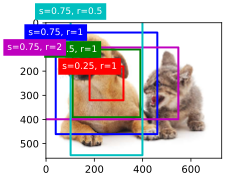

In [60]:
d2l.set_figsize()
bbox_scale = nd.array((w, h, w, h))
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, boxes[250, 250, :, :] * bbox_scale,
            ['s=0.75, r=1', 's=0.5, r=1', 's=0.25, r=1', 's=0.75, r=2',
             's=0.75, r=0.5'])

## 1.2.标注训练集的锚框

在训练集中，我们将每个锚框视为一个训练样本。为了训练目标检测模型，我们需要为每个锚框标注两类标签：
- 锚框所含目标的类别，简称类别
- 真实边界框相对锚框的偏移量，简称偏移量(offset)。

在目标检测时，我们首先生成多个锚框，然后为每个锚框预测类别以及偏移量，接着根据预测的偏移量调整锚框位置从而得到预测边界框，最后筛选需要输出的预测边界框。我们知道，在目标检测的训练集中，每个图像已标注了真实边界框的位置以及所含目标的类别。在生成锚框之后，我们主要依据与锚框相似的真实边界框的位置和类别信息为锚框标注。那么，该如何为锚框分配与其相似的真实边界框呢？

![images](data:image/svg+xml;base64,PD94bWwgdmVyc2lvbj0iMS4wIiBlbmNvZGluZz0iVVRGLTgiPz4KPHN2ZyB4%0AbWxucz0iaHR0cDovL3d3dy53My5vcmcvMjAwMC9zdmciIHhtbG5zOnhsaW5r%0APSJodHRwOi8vd3d3LnczLm9yZy8xOTk5L3hsaW5rIiB3aWR0aD0iMzQ5cHQi%0AIGhlaWdodD0iMjQ2cHQiIHZpZXdCb3g9IjAgMCAzNDkgMjQ2IiB2ZXJzaW9u%0APSIxLjEiPgo8ZGVmcz4KPGc+CjxzeW1ib2wgb3ZlcmZsb3c9InZpc2libGUi%0AIGlkPSJnbHlwaDAtMCI+CjxwYXRoIHN0eWxlPSJzdHJva2U6bm9uZTsiIGQ9%0AIiIvPgo8L3N5bWJvbD4KPHN5bWJvbCBvdmVyZmxvdz0idmlzaWJsZSIgaWQ9%0AImdseXBoMC0xIj4KPHBhdGggc3R5bGU9InN0cm9rZTpub25lOyIgZD0iTSA0%0ALjAxNTYyNSAtNi4xNTYyNSBDIDIuNzY1NjI1IC02LjAxNTYyNSAyLjA2MjUg%0ALTUuODEyNSAxLjI4MTI1IC01IEMgMC42NDA2MjUgLTQuMzQzNzUgMC4zMTI1%0AIC0zLjQ4NDM3NSAwLjMxMjUgLTIuNTE1NjI1IEMgMC4zMTI1IC0xLjg3NSAw%0ALjQ4NDM3NSAtMS4yMzQzNzUgMC43MzQzNzUgLTAuNzgxMjUgQyAxLjA0Njg3%0ANSAtMC4yMDMxMjUgMS42MDkzNzUgMC4xMjUgMi4zMjgxMjUgMC4xMjUgQyAy%0ALjkyMTg3NSAwLjEyNSAzLjQyMTg3NSAtMC4xMDkzNzUgMy43NSAtMC41MzEy%0ANSBDIDQuMDQ2ODc1IC0wLjg5MDYyNSA0LjIxODc1IC0xLjM5MDYyNSA0LjIx%0AODc1IC0xLjk2ODc1IEMgNC4yMTg3NSAtMy4xMjUgMy41NjI1IC0zLjg1OTM3%0ANSAyLjUxNTYyNSAtMy44NTkzNzUgQyAyLjEwOTM3NSAtMy44NTkzNzUgMS44%0AMTI1IC0zLjc4MTI1IDEuMzc1IC0zLjQ1MzEyNSBDIDEuNjA5Mzc1IC00Ljgx%0AMjUgMi42MjUgLTUuNzgxMjUgNC4wMzEyNSAtNi4wMTU2MjUgWiBNIDMuNDA2%0AMjUgLTEuNjg3NSBDIDMuNDA2MjUgLTAuNzgxMjUgMy4wNjI1IC0wLjEyNSAy%0ALjQyMTg3NSAtMC4xMjUgQyAxLjU3ODEyNSAtMC4xMjUgMS4xNDA2MjUgLTEu%0AMDMxMjUgMS4xNDA2MjUgLTIuMzkwNjI1IEMgMS4xNDA2MjUgLTMuMjE4NzUg%0AMS42NzE4NzUgLTMuNDM3NSAyLjE4NzUgLTMuNDM3NSBDIDMuMDMxMjUgLTMu%0ANDM3NSAzLjQwNjI1IC0yLjg0Mzc1IDMuNDA2MjUgLTEuNjg3NSBaIE0gMy40%0AMDYyNSAtMS42ODc1ICIvPgo8L3N5bWJvbD4KPHN5bWJvbCBvdmVyZmxvdz0i%0AdmlzaWJsZSIgaWQ9ImdseXBoMC0yIj4KPHBhdGggc3R5bGU9InN0cm9rZTpu%0Ab25lOyIgZD0iTSA0LjA0Njg3NSAtNS44MTI1IEwgNC4wNDY4NzUgLTUuOTUz%0AMTI1IEwgMC43MTg3NSAtNS45NTMxMjUgTCAwLjE4NzUgLTQuNjQwNjI1IEwg%0AMC4zNDM3NSAtNC41NDY4NzUgQyAwLjcxODc1IC01LjE3MTg3NSAwLjg3NSAt%0ANS4yOTY4NzUgMS4zOTA2MjUgLTUuMjk2ODc1IEwgMy4zMjgxMjUgLTUuMjk2%0AODc1IEwgMS41NDY4NzUgMC4wNzgxMjUgTCAyLjE0MDYyNSAwLjA3ODEyNSBa%0AIE0gNC4wNDY4NzUgLTUuODEyNSAiLz4KPC9zeW1ib2w+CjxzeW1ib2wgb3Zl%0AcmZsb3c9InZpc2libGUiIGlkPSJnbHlwaDAtMyI+CjxwYXRoIHN0eWxlPSJz%0AdHJva2U6bm9uZTsiIGQ9Ik0gNCAtMS4zOTA2MjUgQyA0IC0yLjEwOTM3NSAz%0ALjcxODc1IC0yLjU5Mzc1IDIuNjA5Mzc1IC0zLjM0Mzc1IEMgMy41IC0zLjgx%0AMjUgMy44MTI1IC00LjEyNSAzLjgxMjUgLTQuNzk2ODc1IEMgMy44MTI1IC01%0ALjUgMy4xODc1IC02LjA3ODEyNSAyLjI5Njg3NSAtNi4wNzgxMjUgQyAxLjMx%0AMjUgLTYuMDc4MTI1IDAuNTYyNSAtNS41NDY4NzUgMC41NjI1IC00LjY4NzUg%0AQyAwLjU2MjUgLTQuMDkzNzUgMC43NSAtMy43NSAxLjY3MTg3NSAtMi45ODQz%0ANzUgQyAwLjcxODc1IC0yLjMxMjUgMC41IC0xLjk2ODc1IDAuNSAtMS4zNDM3%0ANSBDIDAuNSAtMC41IDEuMjE4NzUgMC4xMjUgMi4yMzQzNzUgMC4xMjUgQyAz%0ALjMxMjUgMC4xMjUgNCAtMC40Njg3NSA0IC0xLjM5MDYyNSBaIE0gMy4xODc1%0AIC00Ljc5Njg3NSBDIDMuMTg3NSAtNC4yMzQzNzUgMi45Njg3NSAtMy44NTkz%0ANzUgMi4zNDM3NSAtMy41IEMgMS41NjI1IC0zLjk2ODc1IDEuMjE4NzUgLTQu%0AMzkwNjI1IDEuMjE4NzUgLTQuOTM3NSBDIDEuMjE4NzUgLTUuNSAxLjYwOTM3%0ANSAtNS44MjgxMjUgMi4yMTg3NSAtNS44MjgxMjUgQyAyLjgyODEyNSAtNS44%0AMjgxMjUgMy4xODc1IC01LjQyMTg3NSAzLjE4NzUgLTQuNzk2ODc1IFogTSAy%0ALjQzNzUgLTIuNDUzMTI1IEMgMy4wNDY4NzUgLTIuMDMxMjUgMy4zMjgxMjUg%0ALTEuNjcxODc1IDMuMzI4MTI1IC0xLjEwOTM3NSBDIDMuMzI4MTI1IC0wLjUz%0AMTI1IDIuOTIxODc1IC0wLjEyNSAyLjMyODEyNSAtMC4xMjUgQyAxLjY0MDYy%0ANSAtMC4xMjUgMS4xODc1IC0wLjU5Mzc1IDEuMTg3NSAtMS40MjE4NzUgQyAx%0ALjE4NzUgLTIgMS4zNzUgLTIuMzc1IDEuOTA2MjUgLTIuODEyNSBaIE0gMi40%0AMzc1IC0yLjQ1MzEyNSAiLz4KPC9zeW1ib2w+CjxzeW1ib2wgb3ZlcmZsb3c9%0AInZpc2libGUiIGlkPSJnbHlwaDAtNCI+CjxwYXRoIHN0eWxlPSJzdHJva2U6%0Abm9uZTsiIGQ9Ik0gMC41MzEyNSAwLjIwMzEyNSBDIDEuNzAzMTI1IDAuMDMx%0AMjUgMi4yODEyNSAtMC4xODc1IDMuMDQ2ODc1IC0wLjg3NSBDIDMuNzY1NjI1%0AIC0xLjUzMTI1IDQuMTI1IC0yLjUxNTYyNSA0LjEyNSAtMy41NDY4NzUgQyA0%0ALjEyNSAtNC4yOTY4NzUgMy45MjE4NzUgLTQuOTUzMTI1IDMuNTYyNSAtNS40%0AMDYyNSBDIDMuMjAzMTI1IC01LjgyODEyNSAyLjcxODc1IC02LjA3ODEyNSAy%0ALjE0MDYyNSAtNi4wNzgxMjUgQyAxLjA3ODEyNSAtNi4wNzgxMjUgMC4yNjU2%0AMjUgLTUuMTcxODc1IDAuMjY1NjI1IC0zLjk1MzEyNSBDIDAuMjY1NjI1IC0y%0ALjg1OTM3NSAwLjkyMTg3NSAtMi4xNDA2MjUgMS44OTA2MjUgLTIuMTQwNjI1%0AIEMgMi40MjE4NzUgLTIuMTQwNjI1IDIuODU5Mzc1IC0yLjI2NTYyNSAzLjIz%0ANDM3NSAtMi42NDA2MjUgQyAyLjg3NSAtMS4xNzE4NzUgMS44NzUgLTAuMjE4%0ANzUgMC41IDAuMDE1NjI1IFogTSAzLjI2NTYyNSAtMy4xODc1IEMgMy4yNjU2%0AMjUgLTIuNzE4NzUgMi41OTM3NSAtMi41MTU2MjUgMi4yMDMxMjUgLTIuNTE1%0ANjI1IEMgMS41MzEyNSAtMi41MTU2MjUgMS4wOTM3NSAtMy4xODc1IDEuMDkz%0ANzUgLTQuMjY1NjI1IEMgMS4wOTM3NSAtNC43NSAxLjIzNDM3NSAtNS4yODEy%0ANSAxLjQwNjI1IC01LjUzMTI1IEMgMS41NjI1IC01LjcxODc1IDEuNzk2ODc1%0AIC01LjgyODEyNSAyLjA2MjUgLTUuODI4MTI1IEMgMi44NTkzNzUgLTUuODI4%0AMTI1IDMuMjY1NjI1IC01LjA2MjUgMy4yNjU2MjUgLTMuNTQ2ODc1IFogTSAz%0ALjI2NTYyNSAtMy4xODc1ICIvPgo8L3N5bWJvbD4KPHN5bWJvbCBvdmVyZmxv%0Adz0idmlzaWJsZSIgaWQ9ImdseXBoMC01Ij4KPHBhdGggc3R5bGU9InN0cm9r%0AZTpub25lOyIgZD0iTSA0LjI1IC0xLjUgTCA0LjI1IC0yLjA3ODEyNSBMIDMu%0AMzI4MTI1IC0yLjA3ODEyNSBMIDMuMzI4MTI1IC02LjA3ODEyNSBMIDIuOTM3%0ANSAtNi4wNzgxMjUgTCAwLjEwOTM3NSAtMi4wNzgxMjUgTCAwLjEwOTM3NSAt%0AMS41IEwgMi42MjUgLTEuNSBMIDIuNjI1IDAgTCAzLjMyODEyNSAwIEwgMy4z%0AMjgxMjUgLTEuNSBaIE0gMi42MjUgLTIuMDc4MTI1IEwgMC40Njg3NSAtMi4w%0ANzgxMjUgTCAyLjYyNSAtNS4xNzE4NzUgWiBNIDIuNjI1IC0yLjA3ODEyNSAi%0ALz4KPC9zeW1ib2w+CjxzeW1ib2wgb3ZlcmZsb3c9InZpc2libGUiIGlkPSJn%0AbHlwaDAtNiI+CjxwYXRoIHN0eWxlPSJzdHJva2U6bm9uZTsiIGQ9Ik0gMy45%0AMzc1IC02LjEyNSBMIDMuODU5Mzc1IC02LjE4NzUgQyAzLjcxODc1IC02IDMu%0ANjQwNjI1IC01Ljk1MzEyNSAzLjQyMTg3NSAtNS45NTMxMjUgTCAxLjU2MjUg%0ALTUuOTUzMTI1IEwgMC41NzgxMjUgLTMuODI4MTI1IEMgMC41NzgxMjUgLTMu%0AODI4MTI1IDAuNTc4MTI1IC0zLjc5Njg3NSAwLjU3ODEyNSAtMy43ODEyNSBD%0AIDAuNTc4MTI1IC0zLjcxODc1IDAuNjA5Mzc1IC0zLjcwMzEyNSAwLjY4NzUg%0ALTMuNzAzMTI1IEMgMS41NDY4NzUgLTMuNzAzMTI1IDIuMTcxODc1IC0zLjQy%0AMTg3NSAyLjU5Mzc1IC0zLjA3ODEyNSBDIDMgLTIuNzUgMy4yMDMxMjUgLTIu%0AMjk2ODc1IDMuMjAzMTI1IC0xLjczNDM3NSBDIDMuMjAzMTI1IC0wLjk1MzEy%0ANSAyLjYyNSAtMC4yMDMxMjUgMS45ODQzNzUgLTAuMjAzMTI1IEMgMS44MTI1%0AIC0wLjIwMzEyNSAxLjYwOTM3NSAtMC4yODEyNSAxLjM0Mzc1IC0wLjUgQyAx%0ALjA2MjUgLTAuNzM0Mzc1IDAuODkwNjI1IC0wLjc4MTI1IDAuNjg3NSAtMC43%0AODEyNSBDIDAuNDM3NSAtMC43ODEyNSAwLjI4MTI1IC0wLjY1NjI1IDAuMjgx%0AMjUgLTAuNDM3NSBDIDAuMjgxMjUgLTAuMDkzNzUgMC43NSAwLjEyNSAxLjQy%0AMTg3NSAwLjEyNSBDIDIuMDMxMjUgMC4xMjUgMi41MzEyNSAtMC4wMTU2MjUg%0AMi45NTMxMjUgLTAuMzEyNSBDIDMuNTYyNSAtMC43NjU2MjUgMy44MjgxMjUg%0ALTEuMzI4MTI1IDMuODI4MTI1IC0yLjE4NzUgQyAzLjgyODEyNSAtMi42NTYy%0ANSAzLjc1IC0zIDMuNTE1NjI1IC0zLjMyODEyNSBDIDMgLTQuMDQ2ODc1IDIu%0ANTYyNSAtNC4yMzQzNzUgMS4yNjU2MjUgLTQuNDg0Mzc1IEwgMS42MjUgLTUu%0AMjUgTCAzLjM3NSAtNS4yNSBDIDMuNTE1NjI1IC01LjI1IDMuNTkzNzUgLTUu%0AMjk2ODc1IDMuNjI1IC01LjM1OTM3NSBaIE0gMy45Mzc1IC02LjEyNSAiLz4K%0APC9zeW1ib2w+CjxzeW1ib2wgb3ZlcmZsb3c9InZpc2libGUiIGlkPSJnbHlw%0AaDAtNyI+CjxwYXRoIHN0eWxlPSJzdHJva2U6bm9uZTsiIGQ9Ik0gMy41NDY4%0ANzUgMCBMIDMuNTQ2ODc1IC0wLjE0MDYyNSBDIDIuODc1IC0wLjE0MDYyNSAy%0ALjY4NzUgLTAuMjk2ODc1IDIuNjg3NSAtMC42ODc1IEwgMi42ODc1IC02LjA2%0AMjUgTCAyLjYwOTM3NSAtNi4wNzgxMjUgTCAxIC01LjI2NTYyNSBMIDEgLTUu%0AMTQwNjI1IEwgMS4yMzQzNzUgLTUuMjM0Mzc1IEMgMS40MDYyNSAtNS4yOTY4%0ANzUgMS41NjI1IC01LjM0Mzc1IDEuNjQwNjI1IC01LjM0Mzc1IEMgMS44NDM3%0ANSAtNS4zNDM3NSAxLjkyMTg3NSAtNS4yMDMxMjUgMS45MjE4NzUgLTQuODkw%0ANjI1IEwgMS45MjE4NzUgLTAuODU5Mzc1IEMgMS45MjE4NzUgLTAuMzU5Mzc1%0AIDEuNzM0Mzc1IC0wLjE3MTg3NSAxLjA2MjUgLTAuMTQwNjI1IEwgMS4wNjI1%0AIDAgWiBNIDMuNTQ2ODc1IDAgIi8+Cjwvc3ltYm9sPgo8c3ltYm9sIG92ZXJm%0AbG93PSJ2aXNpYmxlIiBpZD0iZ2x5cGgwLTgiPgo8cGF0aCBzdHlsZT0ic3Ry%0Ab2tlOm5vbmU7IiBkPSJNIDAuNTQ2ODc1IC00LjU5Mzc1IEMgMC45MjE4NzUg%0ALTUuMjUgMS4zMjgxMjUgLTUuNTQ2ODc1IDEuODkwNjI1IC01LjU0Njg3NSBD%0AIDIuNDg0Mzc1IC01LjU0Njg3NSAyLjg1OTM3NSAtNS4yMzQzNzUgMi44NTkz%0ANzUgLTQuNjI1IEMgMi44NTkzNzUgLTQuMDc4MTI1IDIuNTc4MTI1IC0zLjY3%0AMTg3NSAyLjE0MDYyNSAtMy40MjE4NzUgQyAxLjk1MzEyNSAtMy4zMTI1IDEu%0ANzE4NzUgLTMuMjE4NzUgMS4zNzUgLTMuMDkzNzUgTCAxLjM3NSAtMi45Njg3%0ANSBDIDEuODkwNjI1IC0yLjk2ODc1IDIuMDkzNzUgLTIuOTM3NSAyLjI5Njg3%0ANSAtMi44NzUgQyAyLjkyMTg3NSAtMi43MDMxMjUgMy4yMzQzNzUgLTIuMjY1%0ANjI1IDMuMjM0Mzc1IC0xLjU3ODEyNSBDIDMuMjM0Mzc1IC0wLjgxMjUgMi43%0AMzQzNzUgLTAuMjAzMTI1IDIuMDYyNSAtMC4yMDMxMjUgQyAxLjgxMjUgLTAu%0AMjAzMTI1IDEuNjI1IC0wLjI1IDEuMjgxMjUgLTAuNDg0Mzc1IEMgMS4wMzEy%0ANSAtMC42NTYyNSAwLjg5MDYyNSAtMC43MTg3NSAwLjczNDM3NSAtMC43MTg3%0ANSBDIDAuNTMxMjUgLTAuNzE4NzUgMC4zNzUgLTAuNTc4MTI1IDAuMzc1IC0w%0ALjM5MDYyNSBDIDAuMzc1IC0wLjA2MjUgMC43MTg3NSAwLjEyNSAxLjM3NSAw%0ALjEyNSBDIDIuMTcxODc1IDAuMTI1IDMuMDMxMjUgLTAuMTQwNjI1IDMuNDY4%0ANzUgLTAuNzE4NzUgQyAzLjcxODc1IC0xLjA0Njg3NSAzLjg3NSAtMS41IDMu%0AODc1IC0xLjk2ODc1IEMgMy44NzUgLTIuNDM3NSAzLjczNDM3NSAtMi44NTkz%0ANzUgMy40ODQzNzUgLTMuMTI1IEMgMy4yOTY4NzUgLTMuMzI4MTI1IDMuMTI1%0AIC0zLjQzNzUgMi43MzQzNzUgLTMuNjA5Mzc1IEMgMy4zNDM3NSAtMy45Njg3%0ANSAzLjU3ODEyNSAtNC40MjE4NzUgMy41NzgxMjUgLTQuODQzNzUgQyAzLjU3%0AODEyNSAtNS41OTM3NSAzIC02LjA3ODEyNSAyLjE3MTg3NSAtNi4wNzgxMjUg%0AQyAxLjIzNDM3NSAtNi4wNzgxMjUgMC42NzE4NzUgLTUuNDg0Mzc1IDAuNDA2%0AMjUgLTQuNjI1IFogTSAwLjU0Njg3NSAtNC41OTM3NSAiLz4KPC9zeW1ib2w+%0ACjxzeW1ib2wgb3ZlcmZsb3c9InZpc2libGUiIGlkPSJnbHlwaDAtOSI+Cjxw%0AYXRoIHN0eWxlPSJzdHJva2U6bm9uZTsiIGQ9Ik0gNC4yNjU2MjUgLTEuMjM0%0AMzc1IEwgNC4xNDA2MjUgLTEuMjgxMjUgQyAzLjg0Mzc1IC0wLjc4MTI1IDMu%0ANjU2MjUgLTAuNjg3NSAzLjI4MTI1IC0wLjY4NzUgTCAxLjE3MTg3NSAtMC42%0AODc1IEwgMi42NTYyNSAtMi4yNjU2MjUgQyAzLjQ1MzEyNSAtMy4xMDkzNzUg%0AMy44MTI1IC0zLjc4MTI1IDMuODEyNSAtNC41IEMgMy44MTI1IC01LjM5MDYy%0ANSAzLjE1NjI1IC02LjA3ODEyNSAyLjE0MDYyNSAtNi4wNzgxMjUgQyAxLjAz%0AMTI1IC02LjA3ODEyNSAwLjQ1MzEyNSAtNS4zNDM3NSAwLjI2NTYyNSAtNC4y%0AOTY4NzUgTCAwLjQ1MzEyNSAtNC4yNSBDIDAuODEyNSAtNS4xMjUgMS4xNDA2%0AMjUgLTUuNDIxODc1IDEuNzgxMjUgLTUuNDIxODc1IEMgMi41NDY4NzUgLTUu%0ANDIxODc1IDMuMDMxMjUgLTQuOTY4NzUgMy4wMzEyNSAtNC4xNTYyNSBDIDMu%0AMDMxMjUgLTMuMzkwNjI1IDIuNzAzMTI1IC0yLjcwMzEyNSAxLjg1OTM3NSAt%0AMS44MTI1IEwgMC4yNjU2MjUgLTAuMTA5Mzc1IEwgMC4yNjU2MjUgMCBMIDMu%0ANzgxMjUgMCBaIE0gNC4yNjU2MjUgLTEuMjM0Mzc1ICIvPgo8L3N5bWJvbD4K%0APHN5bWJvbCBvdmVyZmxvdz0idmlzaWJsZSIgaWQ9ImdseXBoMS0wIj4KPHBh%0AdGggc3R5bGU9InN0cm9rZTpub25lOyIgZD0iIi8+Cjwvc3ltYm9sPgo8c3lt%0AYm9sIG92ZXJmbG93PSJ2aXNpYmxlIiBpZD0iZ2x5cGgxLTEiPgo8cGF0aCBz%0AdHlsZT0ic3Ryb2tlOm5vbmU7IiBkPSJNIDIuMTg3NSAtMy4xODc1IEMgMi4w%0ANjI1IC0zLjgxMjUgMS45NTMxMjUgLTMuOTY4NzUgMS43MzQzNzUgLTMuOTY4%0ANzUgQyAxLjUxNTYyNSAtMy45Njg3NSAxLjIxODc1IC0zLjkwNjI1IDAuNjcx%0AODc1IC0zLjcwMzEyNSBMIDAuNTc4MTI1IC0zLjY3MTg3NSBMIDAuNjA5Mzc1%0AIC0zLjUzMTI1IEwgMC43NjU2MjUgLTMuNTc4MTI1IEMgMC45Mzc1IC0zLjYy%0ANSAxLjA0Njg3NSAtMy42NDA2MjUgMS4xMDkzNzUgLTMuNjQwNjI1IEMgMS4z%0ANDM3NSAtMy42NDA2MjUgMS40MDYyNSAtMy41NjI1IDEuNTMxMjUgLTMuMDMx%0AMjUgTCAxLjc4MTI1IC0xLjkwNjI1IEwgMS4wNDY4NzUgLTAuODU5Mzc1IEMg%0AMC44NTkzNzUgLTAuNTkzNzUgMC42ODc1IC0wLjQyMTg3NSAwLjU3ODEyNSAt%0AMC40MjE4NzUgQyAwLjUzMTI1IC0wLjQyMTg3NSAwLjQzNzUgLTAuNDUzMTI1%0AIDAuMzQzNzUgLTAuNSBDIDAuMjM0Mzc1IC0wLjU2MjUgMC4xNDA2MjUgLTAu%0ANjA5Mzc1IDAuMDYyNSAtMC42MDkzNzUgQyAtMC4xMDkzNzUgLTAuNjA5Mzc1%0AIC0wLjI1IC0wLjQ1MzEyNSAtMC4yNSAtMC4yODEyNSBDIC0wLjI1IC0wLjA0%0ANjg3NSAtMC4wNzgxMjUgMC4wOTM3NSAwLjIwMzEyNSAwLjA5Mzc1IEMgMC40%0AODQzNzUgMC4wOTM3NSAwLjY3MTg3NSAwLjAxNTYyNSAxLjA2MjUgLTAuNTE1%0ANjI1IEwgMS44NTkzNzUgLTEuNTc4MTI1IEwgMi4xMDkzNzUgLTAuNTE1NjI1%0AIEMgMi4yMTg3NSAtMC4wNjI1IDIuMzU5Mzc1IDAuMDkzNzUgMi42NDA2MjUg%0AMC4wOTM3NSBDIDIuOTg0Mzc1IDAuMDkzNzUgMy4yMTg3NSAtMC4xMDkzNzUg%0AMy43NSAtMC45MjE4NzUgTCAzLjYwOTM3NSAtMS4wMTU2MjUgQyAzLjUzMTI1%0AIC0wLjkyMTg3NSAzLjUgLTAuODU5Mzc1IDMuNDIxODc1IC0wLjc1IEMgMy4y%0AMTg3NSAtMC40ODQzNzUgMy4xMDkzNzUgLTAuMzkwNjI1IDMgLTAuMzkwNjI1%0AIEMgMi44NzUgLTAuMzkwNjI1IDIuNzk2ODc1IC0wLjUxNTYyNSAyLjczNDM3%0ANSAtMC43NjU2MjUgTCAyLjQzNzUgLTEuOTY4NzUgQyAyLjM5MDYyNSAtMi4x%0AODc1IDIuMzU5Mzc1IC0yLjMxMjUgMi4zNTkzNzUgLTIuMzc1IEMgMi43NjU2%0AMjUgLTMuMDYyNSAzLjA5Mzc1IC0zLjQ2ODc1IDMuMjUgLTMuNDY4NzUgQyAz%0ALjQ2ODc1IC0zLjQ2ODc1IDMuNTQ2ODc1IC0zLjMxMjUgMy43MTg3NSAtMy4z%0AMTI1IEMgMy44OTA2MjUgLTMuMzEyNSA0LjAxNTYyNSAtMy40NTMxMjUgNC4w%0AMTU2MjUgLTMuNjQwNjI1IEMgNC4wMTU2MjUgLTMuODI4MTI1IDMuODc1IC0z%0ALjk2ODc1IDMuNjU2MjUgLTMuOTY4NzUgQyAzLjI2NTYyNSAtMy45Njg3NSAy%0ALjkyMTg3NSAtMy42NDA2MjUgMi4yOTY4NzUgLTIuNjg3NSBaIE0gMi4xODc1%0AIC0zLjE4NzUgIi8+Cjwvc3ltYm9sPgo8c3ltYm9sIG92ZXJmbG93PSJ2aXNp%0AYmxlIiBpZD0iZ2x5cGgyLTAiPgo8cGF0aCBzdHlsZT0ic3Ryb2tlOm5vbmU7%0AIiBkPSIiLz4KPC9zeW1ib2w+CjxzeW1ib2wgb3ZlcmZsb3c9InZpc2libGUi%0AIGlkPSJnbHlwaDItMSI+CjxwYXRoIHN0eWxlPSJzdHJva2U6bm9uZTsiIGQ9%0AIk0gMi44NDM3NSAtMC44MjgxMjUgTCAyLjc2NTYyNSAtMC44NTkzNzUgQyAy%0ALjU2MjUgLTAuNTE1NjI1IDIuNDM3NSAtMC40NTMxMjUgMi4xODc1IC0wLjQ1%0AMzEyNSBMIDAuNzgxMjUgLTAuNDUzMTI1IEwgMS43NjU2MjUgLTEuNTE1NjI1%0AIEMgMi4yOTY4NzUgLTIuMDc4MTI1IDIuNTMxMjUgLTIuNTMxMjUgMi41MzEy%0ANSAtMyBDIDIuNTMxMjUgLTMuNTkzNzUgMi4xMDkzNzUgLTQuMDYyNSAxLjQy%0AMTg3NSAtNC4wNjI1IEMgMC42ODc1IC00LjA2MjUgMC4zMTI1IC0zLjU2MjUg%0AMC4xODc1IC0yLjg1OTM3NSBMIDAuMzEyNSAtMi44MjgxMjUgQyAwLjU0Njg3%0ANSAtMy40MjE4NzUgMC43NSAtMy42MDkzNzUgMS4xODc1IC0zLjYwOTM3NSBD%0AIDEuNzAzMTI1IC0zLjYwOTM3NSAyLjAxNTYyNSAtMy4zMTI1IDIuMDE1NjI1%0AIC0yLjc2NTYyNSBDIDIuMDE1NjI1IC0yLjI1IDEuODEyNSAtMS43OTY4NzUg%0AMS4yMzQzNzUgLTEuMjAzMTI1IEwgMC4xNzE4NzUgLTAuMDc4MTI1IEwgMC4x%0ANzE4NzUgMCBMIDIuNTE1NjI1IDAgWiBNIDIuODQzNzUgLTAuODI4MTI1ICIv%0APgo8L3N5bWJvbD4KPHN5bWJvbCBvdmVyZmxvdz0idmlzaWJsZSIgaWQ9Imds%0AeXBoMi0yIj4KPHBhdGggc3R5bGU9InN0cm9rZTpub25lOyIgZD0iTSAwLjM1%0AOTM3NSAtMy4wNjI1IEMgMC42MDkzNzUgLTMuNSAwLjg5MDYyNSAtMy43MDMx%0AMjUgMS4yNjU2MjUgLTMuNzAzMTI1IEMgMS42NTYyNSAtMy43MDMxMjUgMS45%0AMDYyNSAtMy40ODQzNzUgMS45MDYyNSAtMy4wNzgxMjUgQyAxLjkwNjI1IC0y%0ALjcxODc1IDEuNzE4NzUgLTIuNDUzMTI1IDEuNDIxODc1IC0yLjI4MTI1IEMg%0AMS4yOTY4NzUgLTIuMjAzMTI1IDEuMTQwNjI1IC0yLjE0MDYyNSAwLjkyMTg3%0ANSAtMi4wNjI1IEwgMC45MjE4NzUgLTEuOTg0Mzc1IEMgMS4yNjU2MjUgLTEu%0AOTg0Mzc1IDEuMzkwNjI1IC0xLjk2ODc1IDEuNTMxMjUgLTEuOTIxODc1IEMg%0AMS45Mzc1IC0xLjc5Njg3NSAyLjE1NjI1IC0xLjUgMi4xNTYyNSAtMS4wNDY4%0ANzUgQyAyLjE1NjI1IC0wLjU0Njg3NSAxLjgxMjUgLTAuMTI1IDEuMzc1IC0w%0ALjEyNSBDIDEuMjAzMTI1IC0wLjEyNSAxLjA3ODEyNSAtMC4xNTYyNSAwLjg1%0AOTM3NSAtMC4zMTI1IEMgMC42ODc1IC0wLjQzNzUgMC41OTM3NSAtMC40Njg3%0ANSAwLjQ4NDM3NSAtMC40Njg3NSBDIDAuMzU5Mzc1IC0wLjQ2ODc1IDAuMjUg%0ALTAuMzkwNjI1IDAuMjUgLTAuMjY1NjI1IEMgMC4yNSAtMC4wNDY4NzUgMC40%0AODQzNzUgMC4wNzgxMjUgMC45MjE4NzUgMC4wNzgxMjUgQyAxLjQ1MzEyNSAw%0ALjA3ODEyNSAyLjAxNTYyNSAtMC4wOTM3NSAyLjMxMjUgLTAuNDY4NzUgQyAy%0ALjQ4NDM3NSAtMC43MDMxMjUgMi41OTM3NSAtMSAyLjU5Mzc1IC0xLjMxMjUg%0AQyAyLjU5Mzc1IC0xLjYyNSAyLjQ4NDM3NSAtMS45MDYyNSAyLjMyODEyNSAt%0AMi4wOTM3NSBDIDIuMjAzMTI1IC0yLjIxODc1IDIuMDkzNzUgLTIuMjk2ODc1%0AIDEuODI4MTI1IC0yLjQwNjI1IEMgMi4yMTg3NSAtMi42NDA2MjUgMi4zNzUg%0ALTIuOTUzMTI1IDIuMzc1IC0zLjIzNDM3NSBDIDIuMzc1IC0zLjcxODc1IDIg%0ALTQuMDYyNSAxLjQ1MzEyNSAtNC4wNjI1IEMgMC44MjgxMjUgLTQuMDYyNSAw%0ALjQzNzUgLTMuNjU2MjUgMC4yNjU2MjUgLTMuMDc4MTI1IFogTSAwLjM1OTM3%0ANSAtMy4wNjI1ICIvPgo8L3N5bWJvbD4KPHN5bWJvbCBvdmVyZmxvdz0idmlz%0AaWJsZSIgaWQ9ImdseXBoMi0zIj4KPHBhdGggc3R5bGU9InN0cm9rZTpub25l%0AOyIgZD0iTSAyLjY4NzUgLTMuODc1IEwgMi42ODc1IC0zLjk2ODc1IEwgMC40%0AODQzNzUgLTMuOTY4NzUgTCAwLjEyNSAtMy4wOTM3NSBMIDAuMjM0Mzc1IC0z%0ALjAzMTI1IEMgMC40ODQzNzUgLTMuNDM3NSAwLjU3ODEyNSAtMy41MzEyNSAw%0ALjkzNzUgLTMuNTMxMjUgTCAyLjIxODc1IC0zLjUzMTI1IEwgMS4wMzEyNSAw%0ALjA0Njg3NSBMIDEuNDIxODc1IDAuMDQ2ODc1IFogTSAyLjY4NzUgLTMuODc1%0AICIvPgo8L3N5bWJvbD4KPHN5bWJvbCBvdmVyZmxvdz0idmlzaWJsZSIgaWQ9%0AImdseXBoMi00Ij4KPHBhdGggc3R5bGU9InN0cm9rZTpub25lOyIgZD0iTSAy%0ALjM1OTM3NSAwIEwgMi4zNTkzNzUgLTAuMDkzNzUgQyAxLjkwNjI1IC0wLjA5%0AMzc1IDEuNzk2ODc1IC0wLjIwMzEyNSAxLjc5Njg3NSAtMC40NTMxMjUgTCAx%0ALjc5Njg3NSAtNC4wMzEyNSBMIDEuNzM0Mzc1IC00LjA2MjUgTCAwLjY3MTg3%0ANSAtMy41MTU2MjUgTCAwLjY3MTg3NSAtMy40MjE4NzUgTCAwLjgyODEyNSAt%0AMy40ODQzNzUgQyAwLjkzNzUgLTMuNTMxMjUgMS4wMzEyNSAtMy41NjI1IDEu%0AMDkzNzUgLTMuNTYyNSBDIDEuMjE4NzUgLTMuNTYyNSAxLjI4MTI1IC0zLjQ2%0AODc1IDEuMjgxMjUgLTMuMjY1NjI1IEwgMS4yODEyNSAtMC41NjI1IEMgMS4y%0AODEyNSAtMC4yMzQzNzUgMS4xNTYyNSAtMC4xMDkzNzUgMC43MDMxMjUgLTAu%0AMDkzNzUgTCAwLjcwMzEyNSAwIFogTSAyLjM1OTM3NSAwICIvPgo8L3N5bWJv%0AbD4KPHN5bWJvbCBvdmVyZmxvdz0idmlzaWJsZSIgaWQ9ImdseXBoMi01Ij4K%0APHBhdGggc3R5bGU9InN0cm9rZTpub25lOyIgZD0iTSAyLjYyNSAtNC4wOTM3%0ANSBMIDIuNTc4MTI1IC00LjEyNSBDIDIuNDg0Mzc1IC00IDIuNDIxODc1IC0z%0ALjk2ODc1IDIuMjgxMjUgLTMuOTY4NzUgTCAxLjA0Njg3NSAtMy45Njg3NSBM%0AIDAuMzkwNjI1IC0yLjU0Njg3NSBDIDAuMzkwNjI1IC0yLjU0Njg3NSAwLjM5%0AMDYyNSAtMi41MzEyNSAwLjM5MDYyNSAtMi41MTU2MjUgQyAwLjM5MDYyNSAt%0AMi40ODQzNzUgMC40MDYyNSAtMi40Njg3NSAwLjQ1MzEyNSAtMi40Njg3NSBD%0AIDEuMDMxMjUgLTIuNDY4NzUgMS40NTMxMjUgLTIuMjgxMjUgMS43MzQzNzUg%0ALTIuMDQ2ODc1IEMgMiAtMS44NDM3NSAyLjE0MDYyNSAtMS41MzEyNSAyLjE0%0AMDYyNSAtMS4xNTYyNSBDIDIuMTQwNjI1IC0wLjY0MDYyNSAxLjc1IC0wLjE0%0AMDYyNSAxLjMyODEyNSAtMC4xNDA2MjUgQyAxLjIwMzEyNSAtMC4xNDA2MjUg%0AMS4wNjI1IC0wLjE4NzUgMC45MDYyNSAtMC4zMjgxMjUgQyAwLjcwMzEyNSAt%0AMC40ODQzNzUgMC41OTM3NSAtMC41MTU2MjUgMC40NTMxMjUgLTAuNTE1NjI1%0AIEMgMC4yODEyNSAtMC41MTU2MjUgMC4xODc1IC0wLjQzNzUgMC4xODc1IC0w%0ALjI4MTI1IEMgMC4xODc1IC0wLjA2MjUgMC41IDAuMDc4MTI1IDAuOTUzMTI1%0AIDAuMDc4MTI1IEMgMS4zNTkzNzUgMC4wNzgxMjUgMS42ODc1IDAgMS45Njg3%0ANSAtMC4yMDMxMjUgQyAyLjM3NSAtMC41MTU2MjUgMi41NjI1IC0wLjg3NSAy%0ALjU2MjUgLTEuNDUzMTI1IEMgMi41NjI1IC0xLjc4MTI1IDIuNSAtMiAyLjM0%0AMzc1IC0yLjIxODc1IEMgMiAtMi42ODc1IDEuNzAzMTI1IC0yLjgyODEyNSAw%0ALjg0Mzc1IC0yLjk4NDM3NSBMIDEuMDkzNzUgLTMuNSBMIDIuMjUgLTMuNSBD%0AIDIuMzQzNzUgLTMuNSAyLjM5MDYyNSAtMy41MzEyNSAyLjQwNjI1IC0zLjU3%0AODEyNSBaIE0gMi42MjUgLTQuMDkzNzUgIi8+Cjwvc3ltYm9sPgo8c3ltYm9s%0AIG92ZXJmbG93PSJ2aXNpYmxlIiBpZD0iZ2x5cGgyLTYiPgo8cGF0aCBzdHls%0AZT0ic3Ryb2tlOm5vbmU7IiBkPSJNIDIuODQzNzUgLTEgTCAyLjg0Mzc1IC0x%0ALjM5MDYyNSBMIDIuMjE4NzUgLTEuMzkwNjI1IEwgMi4yMTg3NSAtNC4wNjI1%0AIEwgMS45NTMxMjUgLTQuMDYyNSBMIDAuMDc4MTI1IC0xLjM5MDYyNSBMIDAu%0AMDc4MTI1IC0xIEwgMS43NSAtMSBMIDEuNzUgMCBMIDIuMjE4NzUgMCBMIDIu%0AMjE4NzUgLTEgWiBNIDEuNzUgLTEuMzkwNjI1IEwgMC4zMTI1IC0xLjM5MDYy%0ANSBMIDEuNzUgLTMuNDM3NSBaIE0gMS43NSAtMS4zOTA2MjUgIi8+Cjwvc3lt%0AYm9sPgo8c3ltYm9sIG92ZXJmbG93PSJ2aXNpYmxlIiBpZD0iZ2x5cGgyLTci%0APgo8cGF0aCBzdHlsZT0ic3Ryb2tlOm5vbmU7IiBkPSJNIDAuMzU5Mzc1IDAu%0AMTI1IEMgMS4xNDA2MjUgMC4wMzEyNSAxLjUzMTI1IC0wLjEyNSAyLjAzMTI1%0AIC0wLjU3ODEyNSBDIDIuNTE1NjI1IC0xLjAxNTYyNSAyLjc1IC0xLjY3MTg3%0ANSAyLjc1IC0yLjM1OTM3NSBDIDIuNzUgLTIuODc1IDIuNjA5Mzc1IC0zLjI5%0ANjg3NSAyLjM3NSAtMy41OTM3NSBDIDIuMTQwNjI1IC0zLjg5MDYyNSAxLjgx%0AMjUgLTQuMDYyNSAxLjQyMTg3NSAtNC4wNjI1IEMgMC43MTg3NSAtNC4wNjI1%0AIDAuMTg3NSAtMy40NTMxMjUgMC4xODc1IC0yLjY0MDYyNSBDIDAuMTg3NSAt%0AMS45MDYyNSAwLjYwOTM3NSAtMS40MjE4NzUgMS4yNjU2MjUgLTEuNDIxODc1%0AIEMgMS42MDkzNzUgLTEuNDIxODc1IDEuOTA2MjUgLTEuNTE1NjI1IDIuMTU2%0AMjUgLTEuNzY1NjI1IEMgMS45MjE4NzUgLTAuNzgxMjUgMS4yNSAtMC4xNTYy%0ANSAwLjM0Mzc1IDAuMDE1NjI1IFogTSAyLjE3MTg3NSAtMi4xMjUgQyAyLjE3%0AMTg3NSAtMS44MTI1IDEuNzM0Mzc1IC0xLjY4NzUgMS40Njg3NSAtMS42ODc1%0AIEMgMS4wMTU2MjUgLTEuNjg3NSAwLjczNDM3NSAtMi4xMjUgMC43MzQzNzUg%0ALTIuODQzNzUgQyAwLjczNDM3NSAtMy4xNzE4NzUgMC44MjgxMjUgLTMuNTE1%0ANjI1IDAuOTM3NSAtMy42ODc1IEMgMS4wNDY4NzUgLTMuODEyNSAxLjIwMzEy%0ANSAtMy44OTA2MjUgMS4zNzUgLTMuODkwNjI1IEMgMS45MDYyNSAtMy44OTA2%0AMjUgMi4xNzE4NzUgLTMuMzc1IDIuMTcxODc1IC0yLjM1OTM3NSBaIE0gMi4x%0ANzE4NzUgLTIuMTI1ICIvPgo8L3N5bWJvbD4KPHN5bWJvbCBvdmVyZmxvdz0i%0AdmlzaWJsZSIgaWQ9ImdseXBoMy0wIj4KPHBhdGggc3R5bGU9InN0cm9rZTpu%0Ab25lOyIgZD0iIi8+Cjwvc3ltYm9sPgo8c3ltYm9sIG92ZXJmbG93PSJ2aXNp%0AYmxlIiBpZD0iZ2x5cGgzLTEiPgo8cGF0aCBzdHlsZT0ic3Ryb2tlOm5vbmU7%0AIiBkPSJNIDguMjUgLTQuMjUgTCA0LjA0Njg3NSAtNC4yNSBMIDQuMDQ2ODc1%0AIDAuNzk2ODc1IEwgNC42NTYyNSAwLjc5Njg3NSBMIDQuNjU2MjUgMC40MDYy%0ANSBMIDcuNjI1IDAuNDA2MjUgTCA3LjYyNSAwLjc5Njg3NSBMIDguMjUgMC43%0AOTY4NzUgWiBNIDQuNjU2MjUgLTAuMTg3NSBMIDQuNjU2MjUgLTEuNjQwNjI1%0AIEwgNS44NTkzNzUgLTEuNjQwNjI1IEwgNS44NTkzNzUgLTAuMTg3NSBaIE0g%0ANi40Mzc1IC0wLjE4NzUgTCA2LjQzNzUgLTEuNjQwNjI1IEwgNy42MjUgLTEu%0ANjQwNjI1IEwgNy42MjUgLTAuMTg3NSBaIE0gNC42NTYyNSAtMi4yMTg3NSBM%0AIDQuNjU2MjUgLTMuNjU2MjUgTCA1Ljg1OTM3NSAtMy42NTYyNSBMIDUuODU5%0AMzc1IC0yLjIxODc1IFogTSA2LjQzNzUgLTMuNjU2MjUgTCA3LjYyNSAtMy42%0ANTYyNSBMIDcuNjI1IC0yLjIxODc1IEwgNi40Mzc1IC0yLjIxODc1IFogTSA0%0ALjgyODEyNSAtNy4yNSBMIDQuODI4MTI1IC02LjI2NTYyNSBMIDMuNzAzMTI1%0AIC02LjI2NTYyNSBMIDMuNzAzMTI1IC01LjY1NjI1IEwgNC44MjgxMjUgLTUu%0ANjU2MjUgTCA0LjgyODEyNSAtNC43MDMxMjUgTCA1LjQzNzUgLTQuNzAzMTI1%0AIEwgNS40Mzc1IC01LjY1NjI1IEwgNi43ODEyNSAtNS42NTYyNSBMIDYuNzgx%0AMjUgLTQuNzAzMTI1IEwgNy4zOTA2MjUgLTQuNzAzMTI1IEwgNy4zOTA2MjUg%0ALTUuNjU2MjUgTCA4LjYwOTM3NSAtNS42NTYyNSBMIDguNjA5Mzc1IC02LjI2%0ANTYyNSBMIDcuMzkwNjI1IC02LjI2NTYyNSBMIDcuMzkwNjI1IC03LjI1IEwg%0ANi43ODEyNSAtNy4yNSBMIDYuNzgxMjUgLTYuMjY1NjI1IEwgNS40Mzc1IC02%0ALjI2NTYyNSBMIDUuNDM3NSAtNy4yNSBaIE0gMS41IC03LjMyODEyNSBDIDEu%0AMjk2ODc1IC02LjI1IDAuOTUzMTI1IC01LjI4MTI1IDAuNDg0Mzc1IC00LjM5%0AMDYyNSBMIDEuMDE1NjI1IC00LjA2MjUgQyAxLjI2NTYyNSAtNC41MzEyNSAx%0ALjUgLTUuMDQ2ODc1IDEuNzAzMTI1IC01LjYyNSBMIDMuNDIxODc1IC01LjYy%0ANSBMIDMuNDIxODc1IC02LjI1IEwgMS44OTA2MjUgLTYuMjUgQyAxLjk4NDM3%0ANSAtNi41NDY4NzUgMi4wNjI1IC02Ljg1OTM3NSAyLjE0MDYyNSAtNy4yMDMx%0AMjUgWiBNIDEuMzc1IC00LjUzMTI1IEwgMS4zNzUgLTMuOTUzMTI1IEwgMS44%0ANzUgLTMuOTUzMTI1IEwgMS44NzUgLTIuODI4MTI1IEwgMC43MDMxMjUgLTIu%0AODI4MTI1IEwgMC43MDMxMjUgLTIuMjM0Mzc1IEwgMS44NzUgLTIuMjM0Mzc1%0AIEwgMS44NzUgLTAuMTg3NSBDIDEuODc1IC0wLjA0Njg3NSAxLjc5Njg3NSAw%0ALjA0Njg3NSAxLjY0MDYyNSAwLjEwOTM3NSBMIDEuOTIxODc1IDAuNjcxODc1%0AIEMgMi41OTM3NSAwLjQ1MzEyNSAzLjE4NzUgMC4xNzE4NzUgMy43MTg3NSAt%0AMC4xNTYyNSBMIDMuNTkzNzUgLTAuNzM0Mzc1IEMgMy4yMzQzNzUgLTAuNDg0%0AMzc1IDIuODc1IC0wLjI4MTI1IDIuNTE1NjI1IC0wLjEyNSBMIDIuNTE1NjI1%0AIC0yLjIzNDM3NSBMIDMuNjQwNjI1IC0yLjIzNDM3NSBMIDMuNjQwNjI1IC0y%0ALjgyODEyNSBMIDIuNTE1NjI1IC0yLjgyODEyNSBMIDIuNTE1NjI1IC0zLjk1%0AMzEyNSBMIDMuNDIxODc1IC0zLjk1MzEyNSBMIDMuNDIxODc1IC00LjUzMTI1%0AIFogTSAxLjM3NSAtNC41MzEyNSAiLz4KPC9zeW1ib2w+CjxzeW1ib2wgb3Zl%0AcmZsb3c9InZpc2libGUiIGlkPSJnbHlwaDMtMiI+CjxwYXRoIHN0eWxlPSJz%0AdHJva2U6bm9uZTsiIGQ9Ik0gMi4yODEyNSAtMy43MzQzNzUgQyAyLjUgLTMu%0AMzc1IDIuNzY1NjI1IC0yLjkyMTg3NSAzLjA2MjUgLTIuMzU5Mzc1IEwgMy40%0AMjE4NzUgLTIuODc1IEMgMy4wMzEyNSAtMy40NTMxMjUgMi42NTYyNSAtMy45%0ANjg3NSAyLjI4MTI1IC00LjQyMTg3NSBMIDIuMjgxMjUgLTQuOTY4NzUgTCAz%0ALjIzNDM3NSAtNC45Njg3NSBMIDMuMjM0Mzc1IC01LjU5Mzc1IEwgMi4yODEy%0ANSAtNS41OTM3NSBMIDIuMjgxMjUgLTcuMzU5Mzc1IEwgMS42NDA2MjUgLTcu%0AMzU5Mzc1IEwgMS42NDA2MjUgLTUuNTkzNzUgTCAwLjUgLTUuNTkzNzUgTCAw%0ALjUgLTQuOTY4NzUgTCAxLjYyNSAtNC45Njg3NSBDIDEuMzc1IC0zLjgxMjUg%0AMC45MjE4NzUgLTIuNzgxMjUgMC4zMTI1IC0xLjg3NSBMIDAuNTkzNzUgLTEu%0AMTcxODc1IEMgMS4wMzEyNSAtMS44OTA2MjUgMS4zNzUgLTIuNjg3NSAxLjY0%0AMDYyNSAtMy41NDY4NzUgTCAxLjY0MDYyNSAwLjg3NSBMIDIuMjgxMjUgMC44%0ANzUgWiBNIDQuOTM3NSAtNS41MzEyNSBMIDQuOTM3NSAtNC45NTMxMjUgTCA2%0ALjI2NTYyNSAtNC45NTMxMjUgTCA2LjI2NTYyNSAtMy40ODQzNzUgTCA1LjEy%0ANSAtMy40ODQzNzUgTCA1LjEyNSAtMi45MDYyNSBMIDYuMjY1NjI1IC0yLjkw%0ANjI1IEwgNi4yNjU2MjUgLTEuMjk2ODc1IEwgNC44MjgxMjUgLTEuMjk2ODc1%0AIEwgNC44MjgxMjUgLTAuNzE4NzUgTCA4LjM1OTM3NSAtMC43MTg3NSBMIDgu%0AMzU5Mzc1IC0xLjI5Njg3NSBMIDYuODc1IC0xLjI5Njg3NSBMIDYuODc1IC0y%0ALjkwNjI1IEwgOC4wNjI1IC0yLjkwNjI1IEwgOC4wNjI1IC0zLjQ4NDM3NSBM%0AIDYuODc1IC0zLjQ4NDM3NSBMIDYuODc1IC00Ljk1MzEyNSBMIDguMjAzMTI1%0AIC00Ljk1MzEyNSBMIDguMjAzMTI1IC01LjUzMTI1IFogTSAzLjczNDM3NSAt%0ANy4wNDY4NzUgTCAzLjczNDM3NSAwLjY4NzUgTCA4LjY1NjI1IDAuNjg3NSBM%0AIDguNjU2MjUgMC4wNzgxMjUgTCA0LjM1OTM3NSAwLjA3ODEyNSBMIDQuMzU5%0AMzc1IC02LjQzNzUgTCA4LjQ4NDM3NSAtNi40Mzc1IEwgOC40ODQzNzUgLTcu%0AMDQ2ODc1IFogTSAzLjczNDM3NSAtNy4wNDY4NzUgIi8+Cjwvc3ltYm9sPgo8%0Ac3ltYm9sIG92ZXJmbG93PSJ2aXNpYmxlIiBpZD0iZ2x5cGgzLTMiPgo8cGF0%0AaCBzdHlsZT0ic3Ryb2tlOm5vbmU7IiBkPSJNIDEuMTQwNjI1IC02LjY0MDYy%0ANSBMIDEuMTQwNjI1IC02LjA0Njg3NSBMIDQuMTcxODc1IC02LjA0Njg3NSBM%0AIDQuMTcxODc1IC01LjI2NTYyNSBMIDAuNzY1NjI1IC01LjI2NTYyNSBMIDAu%0ANzY1NjI1IC0zLjYyNSBMIDEuMzkwNjI1IC0zLjYyNSBMIDEuMzkwNjI1IC00%0ALjcwMzEyNSBMIDQuMDc4MTI1IC00LjcwMzEyNSBDIDMuNTYyNSAtNC4yNSAz%0AIC0zLjg1OTM3NSAyLjQwNjI1IC0zLjUxNTYyNSBDIDIuMjgxMjUgLTMuNDUz%0AMTI1IDIuMTQwNjI1IC0zLjM5MDYyNSAyIC0zLjM1OTM3NSBMIDIuMTQwNjI1%0AIC0yLjg3NSBDIDIuOTIxODc1IC0yLjg5MDYyNSAzLjYwOTM3NSAtMi45MjE4%0ANzUgNC4yMTg3NSAtMi45Mzc1IEMgMy40MjE4NzUgLTIuNDg0Mzc1IDIuNjcx%0AODc1IC0yLjE1NjI1IDEuOTM3NSAtMS45NTMxMjUgQyAxLjc1IC0xLjk1MzEy%0ANSAxLjU2MjUgLTEuOTY4NzUgMS4zNzUgLTEuOTY4NzUgTCAxLjUgLTEuMzkw%0ANjI1IEMgMi4zMjgxMjUgLTEuNDA2MjUgMy4yMzQzNzUgLTEuNDM3NSA0LjIz%0ANDM3NSAtMS40ODQzNzUgTCA0LjIzNDM3NSAwLjA0Njg3NSBDIDQuMjM0Mzc1%0AIDAuMjM0Mzc1IDQuMTI1IDAuMzI4MTI1IDMuOTIxODc1IDAuMzI4MTI1IEMg%0AMy42ODc1IDAuMzI4MTI1IDMuNDM3NSAwLjMxMjUgMy4xODc1IDAuMjgxMjUg%0ATCAzLjMyODEyNSAwLjg5MDYyNSBMIDQuMTQwNjI1IDAuODkwNjI1IEMgNC42%0AMjUgMC44OTA2MjUgNC44NzUgMC42NTYyNSA0Ljg3NSAwLjIwMzEyNSBMIDQu%0AODc1IC0xLjUxNTYyNSBDIDUuNTMxMjUgLTEuNTQ2ODc1IDYuMjAzMTI1IC0x%0ALjU5Mzc1IDYuOTM3NSAtMS42NDA2MjUgQyA3LjEyNSAtMS40MjE4NzUgNy4y%0AODEyNSAtMS4yMDMxMjUgNy40MjE4NzUgLTAuOTg0Mzc1IEwgNy45MDYyNSAt%0AMS4zNDM3NSBDIDcuNTYyNSAtMS44MjgxMjUgNy4wNjI1IC0yLjM5MDYyNSA2%0ALjQwNjI1IC0zLjAzMTI1IEwgNS45Mzc1IC0yLjczNDM3NSBDIDYuMTQwNjI1%0AIC0yLjUxNTYyNSA2LjM1OTM3NSAtMi4yOTY4NzUgNi41NDY4NzUgLTIuMDkz%0ANzUgQyA1LjM3NSAtMiA0LjIxODc1IC0xLjkzNzUgMy4wNDY4NzUgLTEuOTA2%0AMjUgQyA0LjI4MTI1IC0yLjM0Mzc1IDUuNDA2MjUgLTIuOTM3NSA2LjQ2ODc1%0AIC0zLjczNDM3NSBMIDUuOTUzMTI1IC00LjA5Mzc1IEMgNS42MjUgLTMuODU5%0AMzc1IDUuMjk2ODc1IC0zLjYyNSA0Ljk4NDM3NSAtMy40MDYyNSBDIDQuNDg0%0AMzc1IC0zLjM3NSAzLjgxMjUgLTMuMzU5Mzc1IDIuOTg0Mzc1IC0zLjM0Mzc1%0AIEMgMy41NjI1IC0zLjY1NjI1IDQuMTI1IC00LjAxNTYyNSA0LjY1NjI1IC00%0ALjQ1MzEyNSBMIDQuMTcxODc1IC00LjcwMzEyNSBMIDcuNjA5Mzc1IC00Ljcw%0AMzEyNSBMIDcuNjA5Mzc1IC0zLjYyNSBMIDguMjM0Mzc1IC0zLjYyNSBMIDgu%0AMjM0Mzc1IC01LjI2NTYyNSBMIDQuODI4MTI1IC01LjI2NTYyNSBMIDQuODI4%0AMTI1IC02LjA0Njg3NSBMIDcuODU5Mzc1IC02LjA0Njg3NSBMIDcuODU5Mzc1%0AIC02LjY0MDYyNSBMIDQuODI4MTI1IC02LjY0MDYyNSBMIDQuODI4MTI1IC03%0ALjM1OTM3NSBMIDQuMTcxODc1IC03LjM1OTM3NSBMIDQuMTcxODc1IC02LjY0%0AMDYyNSBaIE0gNS44MjgxMjUgLTEuMDMxMjUgTCA1LjUxNTYyNSAtMC41NjI1%0AIEMgNi4zNzUgLTAuMjUgNy4yMTg3NSAwLjE4NzUgOC4wNDY4NzUgMC43MzQz%0ANzUgTCA4LjM3NSAwLjIwMzEyNSBDIDcuNjA5Mzc1IC0wLjI4MTI1IDYuNzY1%0ANjI1IC0wLjY4NzUgNS44MjgxMjUgLTEuMDMxMjUgWiBNIDMgLTEuMDQ2ODc1%0AIEMgMi4zNTkzNzUgLTAuNTYyNSAxLjU0Njg3NSAtMC4xNzE4NzUgMC41NjI1%0AIDAuMTI1IEwgMC44NDM3NSAwLjcwMzEyNSBDIDEuODU5Mzc1IDAuMzQzNzUg%0AMi43MDMxMjUgLTAuMDkzNzUgMy4zNzUgLTAuNjI1IFogTSAzIC0xLjA0Njg3%0ANSAiLz4KPC9zeW1ib2w+CjxzeW1ib2wgb3ZlcmZsb3c9InZpc2libGUiIGlk%0APSJnbHlwaDMtNCI+CjxwYXRoIHN0eWxlPSJzdHJva2U6bm9uZTsiIGQ9Ik0g%0ANi45NTMxMjUgLTcuMzU5Mzc1IEwgNi45NTMxMjUgMC45MDYyNSBMIDcuNjA5%0AMzc1IDAuOTA2MjUgTCA3LjYwOTM3NSAtNy4zNTkzNzUgWiBNIDEuNjcxODc1%0AIC00LjM5MDYyNSBMIDQuNzY1NjI1IC00LjM5MDYyNSBMIDQuNzY1NjI1IC03%0AIEwgMC44NDM3NSAtNyBMIDAuODQzNzUgLTYuNDA2MjUgTCA0LjEyNSAtNi40%0AMDYyNSBMIDQuMTI1IC01IEwgMS4xMjUgLTUgTCAwLjY1NjI1IC0yLjMxMjUg%0ATCA0LjIwMzEyNSAtMi4zMTI1IEMgNC4yMDMxMjUgLTEuMjY1NjI1IDQuMTU2%0AMjUgLTAuNTYyNSA0LjA0Njg3NSAtMC4yMzQzNzUgQyAzLjkzNzUgMC4wNzgx%0AMjUgMy41MzEyNSAwLjI1IDIuODU5Mzc1IDAuMjUgQyAyLjU2MjUgMC4yNSAy%0ALjI4MTI1IDAuMjE4NzUgMS45ODQzNzUgMC4yMDMxMjUgTCAyLjE1NjI1IDAu%0AODEyNSBDIDIuNDM3NSAwLjgyODEyNSAyLjcxODc1IDAuODQzNzUgMyAwLjg0%0AMzc1IEMgMy45ODQzNzUgMC44MTI1IDQuNTMxMjUgMC41NDY4NzUgNC42NTYy%0ANSAwLjAzMTI1IEMgNC43ODEyNSAtMC40Mzc1IDQuODQzNzUgLTEuNDA2MjUg%0ANC44NDM3NSAtMi44OTA2MjUgTCAxLjM0Mzc1IC0yLjg5MDYyNSBaIE0gMS42%0ANzE4NzUgLTQuMzkwNjI1ICIvPgo8L3N5bWJvbD4KPHN5bWJvbCBvdmVyZmxv%0Adz0idmlzaWJsZSIgaWQ9ImdseXBoMy01Ij4KPHBhdGggc3R5bGU9InN0cm9r%0AZTpub25lOyIgZD0iTSAwLjg1OTM3NSAtNi43MDMxMjUgTCAwLjg1OTM3NSAt%0ANi4xMjUgTCA0LjE4NzUgLTYuMTI1IEMgNC4xNTYyNSAtNS45Mzc1IDQuMTA5%0AMzc1IC01LjczNDM3NSA0LjA2MjUgLTUuNTMxMjUgTCAxLjg1OTM3NSAtNS41%0AMzEyNSBMIDEuODU5Mzc1IC0xLjI5Njg3NSBMIDAuNTE1NjI1IC0xLjI5Njg3%0ANSBMIDAuNTE1NjI1IC0wLjcxODc1IEwgMy4xNzE4NzUgLTAuNzE4NzUgQyAy%0ALjUzMTI1IC0wLjI2NTYyNSAxLjczNDM3NSAwLjA5Mzc1IDAuNzM0Mzc1IDAu%0AMzc1IEwgMS4wMTU2MjUgMC45MjE4NzUgQyAyLjAzMTI1IDAuNjA5Mzc1IDIu%0AODc1IDAuMjAzMTI1IDMuNTYyNSAtMC4yODEyNSBMIDMuMTg3NSAtMC43MTg3%0ANSBMIDUuNzY1NjI1IC0wLjcxODc1IEwgNS40Njg3NSAtMC4yODEyNSBDIDYu%0AMzQzNzUgMC4wMTU2MjUgNy4xODc1IDAuNDA2MjUgOC4wMTU2MjUgMC45Mzc1%0AIEwgOC4zNTkzNzUgMC40MjE4NzUgQyA3LjU5Mzc1IC0wLjAxNTYyNSA2Ljcz%0ANDM3NSAtMC4zOTA2MjUgNS43OTY4NzUgLTAuNzE4NzUgTCA4LjQ4NDM3NSAt%0AMC43MTg3NSBMIDguNDg0Mzc1IC0xLjI5Njg3NSBMIDcuMjk2ODc1IC0xLjI5%0ANjg3NSBMIDcuMjk2ODc1IC01LjUzMTI1IEwgNC43MTg3NSAtNS41MzEyNSBD%0AIDQuNzY1NjI1IC01LjczNDM3NSA0LjgxMjUgLTUuOTM3NSA0Ljg0Mzc1IC02%0ALjEyNSBMIDguMTQwNjI1IC02LjEyNSBMIDguMTQwNjI1IC02LjcwMzEyNSBM%0AIDQuOTUzMTI1IC02LjcwMzEyNSBDIDQuOTg0Mzc1IC02Ljg5MDYyNSA1IC03%0ALjA5Mzc1IDUuMDE1NjI1IC03LjI5Njg3NSBMIDQuMzU5Mzc1IC03LjM3NSBM%0AIDQuMjgxMjUgLTYuNzAzMTI1IFogTSAyLjQ2ODc1IC0xLjI5Njg3NSBMIDIu%0ANDY4NzUgLTEuODc1IEwgNi42NzE4NzUgLTEuODc1IEwgNi42NzE4NzUgLTEu%0AMjk2ODc1IFogTSAyLjQ2ODc1IC0yLjM1OTM3NSBMIDIuNDY4NzUgLTIuOTIx%0AODc1IEwgNi42NzE4NzUgLTIuOTIxODc1IEwgNi42NzE4NzUgLTIuMzU5Mzc1%0AIFogTSAyLjQ2ODc1IC0zLjQwNjI1IEwgMi40Njg3NSAtMy45NTMxMjUgTCA2%0ALjY3MTg3NSAtMy45NTMxMjUgTCA2LjY3MTg3NSAtMy40MDYyNSBaIE0gMi40%0ANjg3NSAtNC40NTMxMjUgTCAyLjQ2ODc1IC01LjAxNTYyNSBMIDYuNjcxODc1%0AIC01LjAxNTYyNSBMIDYuNjcxODc1IC00LjQ1MzEyNSBaIE0gMi40Njg3NSAt%0ANC40NTMxMjUgIi8+Cjwvc3ltYm9sPgo8c3ltYm9sIG92ZXJmbG93PSJ2aXNp%0AYmxlIiBpZD0iZ2x5cGgzLTYiPgo8cGF0aCBzdHlsZT0ic3Ryb2tlOm5vbmU7%0AIiBkPSJNIDQuNTQ2ODc1IC0wLjkwNjI1IEMgNS43NSAtMC40Mzc1IDYuOTIx%0AODc1IDAuMTg3NSA4LjA3ODEyNSAwLjk1MzEyNSBMIDguNDIxODc1IDAuMzkw%0ANjI1IEMgNy4zNTkzNzUgLTAuMjgxMjUgNi4xODc1IC0wLjg3NSA0LjkwNjI1%0AIC0xLjM3NSBDIDQuOTg0Mzc1IC0xLjUgNS4wNjI1IC0xLjY0MDYyNSA1LjE0%0AMDYyNSAtMS43ODEyNSBMIDguMzEyNSAtMS43ODEyNSBMIDguMzEyNSAtMi4z%0AOTA2MjUgTCA1LjQyMTg3NSAtMi4zOTA2MjUgQyA1LjYwOTM3NSAtMi45NTMx%0AMjUgNS43MTg3NSAtMy41OTM3NSA1Ljc1IC00LjI5Njg3NSBMIDUuNzUgLTUu%0AMzU5Mzc1IEwgNS4xMjUgLTUuMzU5Mzc1IEwgNS4xMjUgLTQuMjk2ODc1IEMg%0ANS4wOTM3NSAtMy41OTM3NSA0Ljk2ODc1IC0yLjk1MzEyNSA0LjczNDM3NSAt%0AMi4zOTA2MjUgTCAwLjcwMzEyNSAtMi4zOTA2MjUgTCAwLjcwMzEyNSAtMS43%0AODEyNSBMIDQuNDIxODc1IC0xLjc4MTI1IEMgNC4zMjgxMjUgLTEuNjQwNjI1%0AIDQuMjM0Mzc1IC0xLjUgNC4xMjUgLTEuMzc1IEMgMy40Njg3NSAtMC42NTYy%0ANSAyLjI5Njg3NSAtMC4wNzgxMjUgMC42MjUgMC4zNTkzNzUgTCAwLjk4NDM3%0ANSAwLjkwNjI1IEMgMi42MjUgMC40ODQzNzUgMy44MTI1IC0wLjEyNSA0LjU0%0ANjg3NSAtMC45MDYyNSBaIE0gMS45MDYyNSAtNC4xMjUgTCAxLjU3ODEyNSAt%0AMy42NDA2MjUgQyAyLjE4NzUgLTMuNDA2MjUgMi43OTY4NzUgLTMuMDYyNSAz%0ALjM1OTM3NSAtMi42MjUgTCAzLjcwMzEyNSAtMy4xNDA2MjUgQyAzLjE1NjI1%0AIC0zLjUxNTYyNSAyLjU2MjUgLTMuODU5Mzc1IDEuOTA2MjUgLTQuMTI1IFog%0ATSAyLjcwMzEyNSAtNS40MjE4NzUgTCAyLjM3NSAtNC45Mzc1IEMgMyAtNC42%0AODc1IDMuNjI1IC00LjMyODEyNSA0LjIzNDM3NSAtMy44NzUgTCA0LjU2MjUg%0ALTQuMzkwNjI1IEMgNCAtNC43OTY4NzUgMy4zOTA2MjUgLTUuMTQwNjI1IDIu%0ANzAzMTI1IC01LjQyMTg3NSBaIE0gOC4xNTYyNSAtNi40Njg3NSBMIDQuODkw%0ANjI1IC02LjQ2ODc1IEMgNC43ODEyNSAtNi44MjgxMjUgNC42NTYyNSAtNy4x%0ANDA2MjUgNC41NDY4NzUgLTcuNDA2MjUgTCAzLjg3NSAtNy4yOTY4NzUgQyA0%0ALjAxNTYyNSAtNy4wNDY4NzUgNC4xNDA2MjUgLTYuNzgxMjUgNC4yNSAtNi40%0ANjg3NSBMIDAuODI4MTI1IC02LjQ2ODc1IEwgMC44MjgxMjUgLTQuNzUgTCAx%0ALjQ1MzEyNSAtNC43NSBMIDEuNDUzMTI1IC01Ljg3NSBMIDcuNTMxMjUgLTUu%0AODc1IEwgNy41MzEyNSAtNC43NSBMIDguMTU2MjUgLTQuNzUgWiBNIDguMTU2%0AMjUgLTYuNDY4NzUgIi8+Cjwvc3ltYm9sPgo8c3ltYm9sIG92ZXJmbG93PSJ2%0AaXNpYmxlIiBpZD0iZ2x5cGgzLTciPgo8cGF0aCBzdHlsZT0ic3Ryb2tlOm5v%0AbmU7IiBkPSJNIDQuOTA2MjUgLTcuMzQzNzUgTCA0LjkwNjI1IC01LjkwNjI1%0AIEwgMy4xODc1IC01LjkwNjI1IEwgMy4xODc1IC01LjI5Njg3NSBMIDQuODkw%0ANjI1IC01LjI5Njg3NSBDIDQuODI4MTI1IC0zLjM5MDYyNSA0LjE4NzUgLTEu%0AOTg0Mzc1IDMgLTEuMDkzNzUgTCAzLjQ4NDM3NSAtMC42NTYyNSBDIDQuNzgx%0AMjUgLTEuNjQwNjI1IDUuNDY4NzUgLTMuMTg3NSA1LjU0Njg3NSAtNS4yOTY4%0ANzUgTCA3LjUxNTYyNSAtNS4yOTY4NzUgQyA3LjQ4NDM3NSAtMy41IDcuNDA2%0AMjUgLTIuMzkwNjI1IDcuMjgxMjUgLTEuOTg0Mzc1IEMgNy4xNDA2MjUgLTEu%0ANTQ2ODc1IDYuNzk2ODc1IC0xLjMyODEyNSA2LjI1IC0xLjMyODEyNSBDIDYu%0AMDc4MTI1IC0xLjMyODEyNSA1Ljg3NSAtMS4zNDM3NSA1LjYwOTM3NSAtMS4z%0ANTkzNzUgTCA1Ljc4MTI1IC0wLjc1IEMgNi4wMTU2MjUgLTAuNzM0Mzc1IDYu%0AMjM0Mzc1IC0wLjcxODc1IDYuNDA2MjUgLTAuNzE4NzUgQyA3LjA0Njg3NSAt%0AMC43MTg3NSA3LjUgLTAuOTY4NzUgNy43NjU2MjUgLTEuNDUzMTI1IEMgOC4w%0AMTU2MjUgLTEuOTM3NSA4LjE0MDYyNSAtMy40MjE4NzUgOC4xNTYyNSAtNS45%0AMDYyNSBMIDUuNTYyNSAtNS45MDYyNSBMIDUuNTYyNSAtNy4zNDM3NSBaIE0g%0AMS4xMDkzNzUgLTcuMjAzMTI1IEwgMC42NTYyNSAtNi43ODEyNSBDIDEuMzEy%0ANSAtNi4yNjU2MjUgMS44MTI1IC01Ljc5Njg3NSAyLjE3MTg3NSAtNS4zNDM3%0ANSBMIDIuNjQwNjI1IC01LjgyODEyNSBDIDIuMjM0Mzc1IC02LjI4MTI1IDEu%0ANzE4NzUgLTYuNzM0Mzc1IDEuMTA5Mzc1IC03LjIwMzEyNSBaIE0gNi41Nzgx%0AMjUgMC43MzQzNzUgTCA4LjQ4NDM3NSAwLjczNDM3NSBMIDguNjQwNjI1IDAu%0AMDc4MTI1IEMgOC40MjE4NzUgMC4wOTM3NSA4LjEwOTM3NSAwLjEwOTM3NSA3%0ALjcwMzEyNSAwLjEwOTM3NSBDIDcuMjk2ODc1IDAuMTA5Mzc1IDYuODkwNjI1%0AIDAuMTI1IDYuNSAwLjEyNSBDIDUuNzY1NjI1IDAuMTI1IDUuMTQwNjI1IDAu%0AMTA5Mzc1IDQuNjQwNjI1IDAuMTA5Mzc1IEMgNC4wOTM3NSAwLjA5Mzc1IDMu%0ANjU2MjUgMC4wMzEyNSAzLjM1OTM3NSAtMC4wOTM3NSBDIDMuMTA5Mzc1IC0w%0ALjIxODc1IDIuODU5Mzc1IC0wLjQwNjI1IDIuNjI1IC0wLjY1NjI1IEMgMi41%0ANDY4NzUgLTAuNzUgMi40Njg3NSAtMC44MTI1IDIuMzkwNjI1IC0wLjg1OTM3%0ANSBMIDIuMzkwNjI1IC00LjI1IEwgMC40ODQzNzUgLTQuMjUgTCAwLjQ4NDM3%0ANSAtMy42MjUgTCAxLjc2NTYyNSAtMy42MjUgTCAxLjc2NTYyNSAtMC45MDYy%0ANSBDIDEuMzkwNjI1IC0wLjczNDM3NSAwLjk2ODc1IC0wLjI2NTYyNSAwLjQ4%0ANDM3NSAwLjUgTCAwLjk2ODc1IDAuOTM3NSBDIDEuNDY4NzUgMC4wOTM3NSAx%0ALjg0Mzc1IC0wLjMyODEyNSAyLjA2MjUgLTAuMzI4MTI1IEMgMi4xNzE4NzUg%0ALTAuMzI4MTI1IDIuMjk2ODc1IC0wLjI1IDIuNDM3NSAtMC4wOTM3NSBDIDIu%0ANzE4NzUgMC4yMTg3NSAzLjA0Njg3NSAwLjQ1MzEyNSAzLjQyMTg3NSAwLjU2%0AMjUgQyAzLjc5Njg3NSAwLjY1NjI1IDQuMjk2ODc1IDAuNzE4NzUgNC45MDYy%0ANSAwLjcxODc1IEMgNS41MTU2MjUgMC43MzQzNzUgNi4wNjI1IDAuNzM0Mzc1%0AIDYuNTc4MTI1IDAuNzM0Mzc1IFogTSA2LjU3ODEyNSAwLjczNDM3NSAiLz4K%0APC9zeW1ib2w+CjxzeW1ib2wgb3ZlcmZsb3c9InZpc2libGUiIGlkPSJnbHlw%0AaDMtOCI+CjxwYXRoIHN0eWxlPSJzdHJva2U6bm9uZTsiIGQ9Ik0gMS40MDYy%0ANSAtNyBMIDEuNDA2MjUgLTMuNDIxODc1IEwgMy4wOTM3NSAtMy40MjE4NzUg%0AQyAyLjUgLTIuNzk2ODc1IDEuNTc4MTI1IC0yLjI2NTYyNSAwLjMyODEyNSAt%0AMS44NTkzNzUgTCAwLjY3MTg3NSAtMS4yODEyNSBDIDIuMTA5Mzc1IC0xLjg1%0AOTM3NSAzLjE0MDYyNSAtMi41NjI1IDMuNzY1NjI1IC0zLjQyMTg3NSBMIDUu%0AMjE4NzUgLTMuNDIxODc1IEMgNS40Mzc1IC0zLjA5Mzc1IDUuNzM0Mzc1IC0y%0ALjc2NTYyNSA2LjEyNSAtMi40Njg3NSBMIDUuNTkzNzUgLTIuNDY4NzUgTCA1%0ALjU5Mzc1IDAuOTIxODc1IEwgNi4yMzQzNzUgMC45MjE4NzUgTCA2LjIzNDM3%0ANSAtMi4zNTkzNzUgQyA2Ljc5Njg3NSAtMS45MjE4NzUgNy41MTU2MjUgLTEu%0ANTMxMjUgOC4zOTA2MjUgLTEuMjE4NzUgTCA4LjY3MTg3NSAtMS43ODEyNSBD%0AIDcuNDIxODc1IC0yLjE4NzUgNi40ODQzNzUgLTIuNzM0Mzc1IDUuODkwNjI1%0AIC0zLjQyMTg3NSBMIDcuNjI1IC0zLjQyMTg3NSBMIDcuNjI1IC03IFogTSA3%0AIC00IEwgNC44MTI1IC00IEwgNC44MTI1IC00Ljk1MzEyNSBMIDcgLTQuOTUz%0AMTI1IFogTSA0LjE4NzUgLTQgTCAyLjAzMTI1IC00IEwgMi4wMzEyNSAtNC45%0ANTMxMjUgTCA0LjE4NzUgLTQuOTUzMTI1IFogTSAyLjAzMTI1IC01LjUgTCAy%0ALjAzMTI1IC02LjQyMTg3NSBMIDQuMTg3NSAtNi40MjE4NzUgTCA0LjE4NzUg%0ALTUuNSBaIE0gNC44MTI1IC02LjQyMTg3NSBMIDcgLTYuNDIxODc1IEwgNyAt%0ANS41IEwgNC44MTI1IC01LjUgWiBNIDIuOTA2MjUgLTIuNDY4NzUgQyAyLjg5%0AMDYyNSAtMS44MTI1IDIuNzk2ODc1IC0xLjI4MTI1IDIuNTkzNzUgLTAuODQz%0ANzUgQyAyLjMyODEyNSAtMC4zNDM3NSAxLjc2NTYyNSAwLjA3ODEyNSAwLjk2%0AODc1IDAuNDA2MjUgTCAxLjM5MDYyNSAwLjkyMTg3NSBDIDIuMzQzNzUgMC41%0AMTU2MjUgMi45Njg3NSAtMC4wMTU2MjUgMy4yMzQzNzUgLTAuNjcxODc1IEMg%0AMy40NTMxMjUgLTEuMTU2MjUgMy41NjI1IC0xLjc2NTYyNSAzLjU2MjUgLTIu%0ANDY4NzUgWiBNIDIuOTA2MjUgLTIuNDY4NzUgIi8+Cjwvc3ltYm9sPgo8L2c+%0ACjwvZGVmcz4KPGcgaWQ9InN1cmZhY2UxIj4KPGcgc3R5bGU9ImZpbGw6cmdi%0AKDAlLDAlLDAlKTtmaWxsLW9wYWNpdHk6MTsiPgogIDx1c2UgeGxpbms6aHJl%0AZj0iI2dseXBoMC0xIiB4PSIyNy45MDQ2NyIgeT0iMTY4Ljk2NCIvPgo8L2c+%0ACjxnIHN0eWxlPSJmaWxsOnJnYigwJSwwJSwwJSk7ZmlsbC1vcGFjaXR5OjE7%0AIj4KICA8dXNlIHhsaW5rOmhyZWY9IiNnbHlwaDAtMiIgeD0iMjcuOTA0Njci%0AIHk9IjE5MS4yNzMzIi8+CjwvZz4KPGcgc3R5bGU9ImZpbGw6cmdiKDAlLDAl%0ALDAlKTtmaWxsLW9wYWNpdHk6MTsiPgogIDx1c2UgeGxpbms6aHJlZj0iI2ds%0AeXBoMC0zIiB4PSIyNy45MDQ2NyIgeT0iMjEzLjU4MjciLz4KPC9nPgo8ZyBz%0AdHlsZT0iZmlsbDpyZ2IoMCUsMCUsMCUpO2ZpbGwtb3BhY2l0eToxOyI+CiAg%0APHVzZSB4bGluazpocmVmPSIjZ2x5cGgwLTQiIHg9IjI3LjkwNDY3IiB5PSIy%0AMzUuODkyIi8+CjwvZz4KPGcgc3R5bGU9ImZpbGw6cmdiKDAlLDAlLDAlKTtm%0AaWxsLW9wYWNpdHk6MTsiPgogIDx1c2UgeGxpbms6aHJlZj0iI2dseXBoMC01%0AIiB4PSIyNy45MDQ2NyIgeT0iMTI0LjM0NTMzIi8+CjwvZz4KPGcgc3R5bGU9%0AImZpbGw6cmdiKDAlLDAlLDAlKTtmaWxsLW9wYWNpdHk6MTsiPgogIDx1c2Ug%0AeGxpbms6aHJlZj0iI2dseXBoMC02IiB4PSIyNy45MDQ2NyIgeT0iMTQ2LjY1%0ANDciLz4KPC9nPgo8ZyBzdHlsZT0iZmlsbDpyZ2IoMCUsMCUsMCUpO2ZpbGwt%0Ab3BhY2l0eToxOyI+CiAgPHVzZSB4bGluazpocmVmPSIjZ2x5cGgwLTciIHg9%0AIjI3LjkwNDY3IiB5PSI1Ny40MTczMyIvPgo8L2c+CjxnIHN0eWxlPSJmaWxs%0AOnJnYigwJSwwJSwwJSk7ZmlsbC1vcGFjaXR5OjE7Ij4KICA8dXNlIHhsaW5r%0AOmhyZWY9IiNnbHlwaDAtOCIgeD0iMjcuOTA0NjciIHk9IjEwMi4wMzYiLz4K%0APC9nPgo8ZyBzdHlsZT0iZmlsbDpyZ2IoMCUsMCUsMCUpO2ZpbGwtb3BhY2l0%0AeToxOyI+CiAgPHVzZSB4bGluazpocmVmPSIjZ2x5cGgwLTkiIHg9IjI3Ljkw%0ANDY3IiB5PSI3OS43MjY2NyIvPgo8L2c+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1%0AbGU6bm9uemVybztmaWxsOnJnYig2OS44MDQzODIlLDg1LjA5ODI2NyUsMTAw%0AJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVj%0AYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUs%0AMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7%0AIiBkPSJNIDExOS4yMzgyODEgOTUgTCAxNDEuNTQ2ODc1IDk1IEwgMTQxLjU0%0ANjg3NSAxMTcuMzA4NTk0IEwgMTE5LjIzODI4MSAxMTcuMzA4NTk0IFogTSAx%0AMTkuMjM4MjgxIDk1ICIgdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEs%0AMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJn%0AYigxMDAlLDEwMCUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRo%0AOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5k%0AO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tl%0ALW1pdGVybGltaXQ6MTA7IiBkPSJNIDk2LjkyOTY4OCA1MC4zODI4MTIgTCAx%0AMTkuMjM4MjgxIDUwLjM4MjgxMiBMIDExOS4yMzgyODEgNzIuNjkxNDA2IEwg%0AOTYuOTI5Njg4IDcyLjY5MTQwNiBaIE0gOTYuOTI5Njg4IDUwLjM4MjgxMiAi%0AIHRyYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0aCBz%0AdHlsZT0iZmlsbC1ydWxlOm5vbnplcm87ZmlsbDpyZ2IoNjkuODA0MzgyJSw4%0ANS4wOTgyNjclLDEwMCUpO2ZpbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0aDox%0AO3N0cm9rZS1saW5lY2FwOnJvdW5kO3N0cm9rZS1saW5lam9pbjpyb3VuZDtz%0AdHJva2U6cmdiKDAlLDAlLDAlKTtzdHJva2Utb3BhY2l0eToxO3N0cm9rZS1t%0AaXRlcmxpbWl0OjEwOyIgZD0iTSAxMTkuMjM4MjgxIDE4NC4yMzgyODEgTCAx%0ANDEuNTQ2ODc1IDE4NC4yMzgyODEgTCAxNDEuNTQ2ODc1IDIwNi41NDY4NzUg%0ATCAxMTkuMjM4MjgxIDIwNi41NDY4NzUgWiBNIDExOS4yMzgyODEgMTg0LjIz%0AODI4MSAiIHRyYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4KSIvPgo8%0AZyBzdHlsZT0iZmlsbDpyZ2IoMCUsMCUsMCUpO2ZpbGwtb3BhY2l0eToxOyI+%0ACiAgPHVzZSB4bGluazpocmVmPSIjZ2x5cGgwLTUiIHg9IjExNy4xNDIiIHk9%0AIjM1LjEwOCIvPgo8L2c+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVy%0AbztmaWxsOnJnYig2OS44MDQzODIlLDg1LjA5ODI2NyUsMTAwJSk7ZmlsbC1v%0AcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7%0Ac3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0%0Acm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDEx%0AOS4yMzgyODEgMTE3LjMwODU5NCBMIDE0MS41NDY4NzUgMTE3LjMwODU5NCBM%0AIDE0MS41NDY4NzUgMTM5LjYxNzE4OCBMIDExOS4yMzgyODEgMTM5LjYxNzE4%0AOCBaIE0gMTE5LjIzODI4MSAxMTcuMzA4NTk0ICIgdHJhbnNmb3JtPSJtYXRy%0AaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6%0Abm9uemVybztmaWxsOnJnYigxMDAlLDEwMCUsMTAwJSk7ZmlsbC1vcGFjaXR5%0AOjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tl%0ALWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1v%0AcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDk2LjkyOTY4%0AOCAyOC4wNzAzMTIgTCAxMTkuMjM4MjgxIDI4LjA3MDMxMiBMIDExOS4yMzgy%0AODEgNTAuMzgyODEyIEwgOTYuOTI5Njg4IDUwLjM4MjgxMiBaIE0gOTYuOTI5%0ANjg4IDI4LjA3MDMxMiAiIHRyYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEsLTEx%0ALDM4KSIvPgo8ZyBzdHlsZT0iZmlsbDpyZ2IoMCUsMCUsMCUpO2ZpbGwtb3Bh%0AY2l0eToxOyI+CiAgPHVzZSB4bGluazpocmVmPSIjZ2x5cGgxLTEiIHg9Ijky%0ALjA4NDciIHk9Ijc4LjcyNjY3Ii8+CjwvZz4KPGcgc3R5bGU9ImZpbGw6cmdi%0AKDAlLDAlLDAlKTtmaWxsLW9wYWNpdHk6MTsiPgogIDx1c2UgeGxpbms6aHJl%0AZj0iI2dseXBoMi0xIiB4PSI5Ni4wODA3IiB5PSI4MS43MjY2NyIvPgogIDx1%0Ac2UgeGxpbms6aHJlZj0iI2dseXBoMi0yIiB4PSI5OS4wODA3IiB5PSI4MS43%0AMjY2NyIvPgo8L2c+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztm%0AaWxsOnJnYig2OS44MDQzODIlLDg1LjA5ODI2NyUsMTAwJSk7ZmlsbC1vcGFj%0AaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ry%0Ab2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9r%0AZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDc0LjYx%0ANzE4OCA1MC4zODI4MTIgTCA5Ni45Mjk2ODggNTAuMzgyODEyIEwgOTYuOTI5%0ANjg4IDcyLjY5MTQwNiBMIDc0LjYxNzE4OCA3Mi42OTE0MDYgWiBNIDc0LjYx%0ANzE4OCA1MC4zODI4MTIgIiB0cmFuc2Zvcm09Im1hdHJpeCgxLDAsMCwxLC0x%0AMSwzOCkiLz4KPHBhdGggc3R5bGU9ImZpbGwtcnVsZTpub256ZXJvO2ZpbGw6%0AcmdiKDY5LjgwNDM4MiUsODUuMDk4MjY3JSwxMDAlKTtmaWxsLW9wYWNpdHk6%0AMTtzdHJva2Utd2lkdGg6MTtzdHJva2UtbGluZWNhcDpyb3VuZDtzdHJva2Ut%0AbGluZWpvaW46cm91bmQ7c3Ryb2tlOnJnYigwJSwwJSwwJSk7c3Ryb2tlLW9w%0AYWNpdHk6MTtzdHJva2UtbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0gNzQuNjE3MTg4%0AIDExNy4zMDg1OTQgTCA1Mi4zMDg1OTQgMTE3LjMwODU5NCBMIDUyLjMwODU5%0ANCAxMzkuNjE3MTg4IEwgNzQuNjE3MTg4IDEzOS42MTcxODggWiBNIDc0LjYx%0ANzE4OCAxMTcuMzA4NTk0ICIgdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwt%0AMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxs%0AOnJnYig2OS44MDQzODIlLDg1LjA5ODI2NyUsMTAwJSk7ZmlsbC1vcGFjaXR5%0AOjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tl%0ALWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1v%0AcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDc0LjYxNzE4%0AOCAxMzkuNjE3MTg4IEwgNTIuMzA4NTk0IDEzOS42MTcxODggTCA1Mi4zMDg1%0AOTQgMTYxLjkyOTY4OCBMIDc0LjYxNzE4OCAxNjEuOTI5Njg4IFogTSA3NC42%0AMTcxODggMTM5LjYxNzE4OCAiIHRyYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEs%0ALTExLDM4KSIvPgo8ZyBzdHlsZT0iZmlsbDpyZ2IoMCUsMCUsMCUpO2ZpbGwt%0Ab3BhY2l0eToxOyI+CiAgPHVzZSB4bGluazpocmVmPSIjZ2x5cGgxLTEiIHg9%0AIjQ3LjQ2NiIgeT0iMTkwLjI3MzMiLz4KPC9nPgo8ZyBzdHlsZT0iZmlsbDpy%0AZ2IoMCUsMCUsMCUpO2ZpbGwtb3BhY2l0eToxOyI+CiAgPHVzZSB4bGluazpo%0AcmVmPSIjZ2x5cGgyLTMiIHg9IjUxLjQ2MiIgeT0iMTkzLjI3MzMiLz4KICA8%0AdXNlIHhsaW5rOmhyZWY9IiNnbHlwaDItNCIgeD0iNTQuNDYyIiB5PSIxOTMu%0AMjczMyIvPgo8L2c+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztm%0AaWxsOnJnYigxMDAlLDEwMCUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tl%0ALXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2lu%0AOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7%0Ac3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDk2LjkyOTY4OCAxODQuMjM4%0AMjgxIEwgMTE5LjIzODI4MSAxODQuMjM4MjgxIEwgMTE5LjIzODI4MSAyMDYu%0ANTQ2ODc1IEwgOTYuOTI5Njg4IDIwNi41NDY4NzUgWiBNIDk2LjkyOTY4OCAx%0AODQuMjM4MjgxICIgdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgp%0AIi8+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYig2%0AOS44MDQzODIlLDg1LjA5ODI2NyUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ry%0Ab2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVq%0Ab2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5%0AOjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDExOS4yMzgyODEgNzIu%0ANjkxNDA2IEwgMTQxLjU0Njg3NSA3Mi42OTE0MDYgTCAxNDEuNTQ2ODc1IDk1%0AIEwgMTE5LjIzODI4MSA5NSBaIE0gMTE5LjIzODI4MSA3Mi42OTE0MDYgIiB0%0AcmFuc2Zvcm09Im1hdHJpeCgxLDAsMCwxLC0xMSwzOCkiLz4KPHBhdGggc3R5%0AbGU9ImZpbGwtcnVsZTpub256ZXJvO2ZpbGw6cmdiKDEwMCUsMTAwJSwxMDAl%0AKTtmaWxsLW9wYWNpdHk6MTtzdHJva2Utd2lkdGg6MTtzdHJva2UtbGluZWNh%0AcDpyb3VuZDtzdHJva2UtbGluZWpvaW46cm91bmQ7c3Ryb2tlOnJnYigwJSww%0AJSwwJSk7c3Ryb2tlLW9wYWNpdHk6MTtzdHJva2UtbWl0ZXJsaW1pdDoxMDsi%0AIGQ9Ik0gOTYuOTI5Njg4IDk1IEwgMTE5LjIzODI4MSA5NSBMIDExOS4yMzgy%0AODEgMTE3LjMwODU5NCBMIDk2LjkyOTY4OCAxMTcuMzA4NTk0IFogTSA5Ni45%0AMjk2ODggOTUgIiB0cmFuc2Zvcm09Im1hdHJpeCgxLDAsMCwxLC0xMSwzOCki%0ALz4KPHBhdGggc3R5bGU9ImZpbGwtcnVsZTpub256ZXJvO2ZpbGw6cmdiKDEw%0AMCUsMTAwJSwxMDAlKTtmaWxsLW9wYWNpdHk6MTtzdHJva2Utd2lkdGg6MTtz%0AdHJva2UtbGluZWNhcDpyb3VuZDtzdHJva2UtbGluZWpvaW46cm91bmQ7c3Ry%0Ab2tlOnJnYigwJSwwJSwwJSk7c3Ryb2tlLW9wYWNpdHk6MTtzdHJva2UtbWl0%0AZXJsaW1pdDoxMDsiIGQ9Ik0gOTYuOTI5Njg4IDExNy4zMDg1OTQgTCAxMTku%0AMjM4MjgxIDExNy4zMDg1OTQgTCAxMTkuMjM4MjgxIDEzOS42MTcxODggTCA5%0ANi45Mjk2ODggMTM5LjYxNzE4OCBaIE0gOTYuOTI5Njg4IDExNy4zMDg1OTQg%0AIiB0cmFuc2Zvcm09Im1hdHJpeCgxLDAsMCwxLC0xMSwzOCkiLz4KPHBhdGgg%0Ac3R5bGU9ImZpbGwtcnVsZTpub256ZXJvO2ZpbGw6cmdiKDY5LjgwNDM4MiUs%0AODUuMDk4MjY3JSwxMDAlKTtmaWxsLW9wYWNpdHk6MTtzdHJva2Utd2lkdGg6%0AMTtzdHJva2UtbGluZWNhcDpyb3VuZDtzdHJva2UtbGluZWpvaW46cm91bmQ7%0Ac3Ryb2tlOnJnYigwJSwwJSwwJSk7c3Ryb2tlLW9wYWNpdHk6MTtzdHJva2Ut%0AbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0gMTE5LjIzODI4MSA1MC4zODI4MTIgTCAx%0ANDEuNTQ2ODc1IDUwLjM4MjgxMiBMIDE0MS41NDY4NzUgNzIuNjkxNDA2IEwg%0AMTE5LjIzODI4MSA3Mi42OTE0MDYgWiBNIDExOS4yMzgyODEgNTAuMzgyODEy%0AICIgdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRo%0AIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYig2OS44MDQzODIl%0ALDg1LjA5ODI2NyUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRo%0AOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5k%0AO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tl%0ALW1pdGVybGltaXQ6MTA7IiBkPSJNIDc0LjYxNzE4OCAxMTcuMzA4NTk0IEwg%0AOTYuOTI5Njg4IDExNy4zMDg1OTQgTCA5Ni45Mjk2ODggMTM5LjYxNzE4OCBM%0AIDc0LjYxNzE4OCAxMzkuNjE3MTg4IFogTSA3NC42MTcxODggMTE3LjMwODU5%0ANCAiIHRyYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0%0AaCBzdHlsZT0iZmlsbC1ydWxlOm5vbnplcm87ZmlsbDpyZ2IoMTAwJSwxMDAl%0ALDEwMCUpO2ZpbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0cm9rZS1s%0AaW5lY2FwOnJvdW5kO3N0cm9rZS1saW5lam9pbjpyb3VuZDtzdHJva2U6cmdi%0AKDAlLDAlLDAlKTtzdHJva2Utb3BhY2l0eToxO3N0cm9rZS1taXRlcmxpbWl0%0AOjEwOyIgZD0iTSA3NC42MTcxODggMjguMDcwMzEyIEwgOTYuOTI5Njg4IDI4%0ALjA3MDMxMiBMIDk2LjkyOTY4OCA1MC4zODI4MTIgTCA3NC42MTcxODggNTAu%0AMzgyODEyIFogTSA3NC42MTcxODggMjguMDcwMzEyICIgdHJhbnNmb3JtPSJt%0AYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1%0AbGU6bm9uemVybztmaWxsOnJnYigxMDAlLDEwMCUsMTAwJSk7ZmlsbC1vcGFj%0AaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ry%0Ab2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9r%0AZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDk2Ljky%0AOTY4OCA3Mi42OTE0MDYgTCAxMTkuMjM4MjgxIDcyLjY5MTQwNiBMIDExOS4y%0AMzgyODEgOTUgTCA5Ni45Mjk2ODggOTUgWiBNIDk2LjkyOTY4OCA3Mi42OTE0%0AMDYgIiB0cmFuc2Zvcm09Im1hdHJpeCgxLDAsMCwxLC0xMSwzOCkiLz4KPHBh%0AdGggc3R5bGU9ImZpbGwtcnVsZTpub256ZXJvO2ZpbGw6cmdiKDY5LjgwNDM4%0AMiUsODUuMDk4MjY3JSwxMDAlKTtmaWxsLW9wYWNpdHk6MTtzdHJva2Utd2lk%0AdGg6MTtzdHJva2UtbGluZWNhcDpyb3VuZDtzdHJva2UtbGluZWpvaW46cm91%0AbmQ7c3Ryb2tlOnJnYigwJSwwJSwwJSk7c3Ryb2tlLW9wYWNpdHk6MTtzdHJv%0Aa2UtbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0gNzQuNjE3MTg4IDcyLjY5MTQwNiBM%0AIDk2LjkyOTY4OCA3Mi42OTE0MDYgTCA5Ni45Mjk2ODggOTUgTCA3NC42MTcx%0AODggOTUgWiBNIDc0LjYxNzE4OCA3Mi42OTE0MDYgIiB0cmFuc2Zvcm09Im1h%0AdHJpeCgxLDAsMCwxLC0xMSwzOCkiLz4KPHBhdGggc3R5bGU9ImZpbGwtcnVs%0AZTpub256ZXJvO2ZpbGw6cmdiKDY5LjgwNDM4MiUsODUuMDk4MjY3JSwxMDAl%0AKTtmaWxsLW9wYWNpdHk6MTtzdHJva2Utd2lkdGg6MTtzdHJva2UtbGluZWNh%0AcDpyb3VuZDtzdHJva2UtbGluZWpvaW46cm91bmQ7c3Ryb2tlOnJnYigwJSww%0AJSwwJSk7c3Ryb2tlLW9wYWNpdHk6MTtzdHJva2UtbWl0ZXJsaW1pdDoxMDsi%0AIGQ9Ik0gNzQuNjE3MTg4IDE2MS45Mjk2ODggTCA1Mi4zMDg1OTQgMTYxLjky%0AOTY4OCBMIDUyLjMwODU5NCAxODQuMjM4MjgxIEwgNzQuNjE3MTg4IDE4NC4y%0AMzgyODEgWiBNIDc0LjYxNzE4OCAxNjEuOTI5Njg4ICIgdHJhbnNmb3JtPSJt%0AYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1%0AbGU6bm9uemVybztmaWxsOnJnYig2OS44MDQzODIlLDg1LjA5ODI2NyUsMTAw%0AJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVj%0AYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUs%0AMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7%0AIiBkPSJNIDc0LjYxNzE4OCA1Ljc2MTcxOSBMIDk2LjkyOTY4OCA1Ljc2MTcx%0AOSBMIDk2LjkyOTY4OCAyOC4wNzAzMTIgTCA3NC42MTcxODggMjguMDcwMzEy%0AIFogTSA3NC42MTcxODggNS43NjE3MTkgIiB0cmFuc2Zvcm09Im1hdHJpeCgx%0ALDAsMCwxLC0xMSwzOCkiLz4KPHBhdGggc3R5bGU9ImZpbGwtcnVsZTpub256%0AZXJvO2ZpbGw6cmdiKDY5LjgwNDM4MiUsODUuMDk4MjY3JSwxMDAlKTtmaWxs%0ALW9wYWNpdHk6MTtzdHJva2Utd2lkdGg6MTtzdHJva2UtbGluZWNhcDpyb3Vu%0AZDtzdHJva2UtbGluZWpvaW46cm91bmQ7c3Ryb2tlOnJnYigwJSwwJSwwJSk7%0Ac3Ryb2tlLW9wYWNpdHk6MTtzdHJva2UtbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0g%0ANzQuNjE3MTg4IDE2MS45Mjk2ODggTCA5Ni45Mjk2ODggMTYxLjkyOTY4OCBM%0AIDk2LjkyOTY4OCAxODQuMjM4MjgxIEwgNzQuNjE3MTg4IDE4NC4yMzgyODEg%0AWiBNIDc0LjYxNzE4OCAxNjEuOTI5Njg4ICIgdHJhbnNmb3JtPSJtYXRyaXgo%0AMSwwLDAsMSwtMTEsMzgpIi8+CjxnIHN0eWxlPSJmaWxsOnJnYigwJSwwJSww%0AJSk7ZmlsbC1vcGFjaXR5OjE7Ij4KICA8dXNlIHhsaW5rOmhyZWY9IiNnbHlw%0AaDAtOCIgeD0iOTQuODMyNyIgeT0iMzUuMTA4Ii8+CjwvZz4KPHBhdGggc3R5%0AbGU9ImZpbGwtcnVsZTpub256ZXJvO2ZpbGw6cmdiKDY5LjgwNDM4MiUsODUu%0AMDk4MjY3JSwxMDAlKTtmaWxsLW9wYWNpdHk6MTtzdHJva2Utd2lkdGg6MTtz%0AdHJva2UtbGluZWNhcDpyb3VuZDtzdHJva2UtbGluZWpvaW46cm91bmQ7c3Ry%0Ab2tlOnJnYigwJSwwJSwwJSk7c3Ryb2tlLW9wYWNpdHk6MTtzdHJva2UtbWl0%0AZXJsaW1pdDoxMDsiIGQ9Ik0gNzQuNjE3MTg4IDE4NC4yMzgyODEgTCA1Mi4z%0AMDg1OTQgMTg0LjIzODI4MSBMIDUyLjMwODU5NCAyMDYuNTQ2ODc1IEwgNzQu%0ANjE3MTg4IDIwNi41NDY4NzUgWiBNIDc0LjYxNzE4OCAxODQuMjM4MjgxICIg%0AdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0%0AeWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYig2OS44MDQzODIlLDg1%0ALjA5ODI2NyUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7%0Ac3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0%0Acm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1p%0AdGVybGltaXQ6MTA7IiBkPSJNIDc0LjYxNzE4OCA3Mi42OTE0MDYgTCA1Mi4z%0AMDg1OTQgNzIuNjkxNDA2IEwgNTIuMzA4NTk0IDk1IEwgNzQuNjE3MTg4IDk1%0AIFogTSA3NC42MTcxODggNzIuNjkxNDA2ICIgdHJhbnNmb3JtPSJtYXRyaXgo%0AMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9u%0AemVybztmaWxsOnJnYig2OS44MDQzODIlLDg1LjA5ODI2NyUsMTAwJSk7Zmls%0AbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91%0AbmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUp%0AO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJN%0AIDc0LjYxNzE4OCAxMzkuNjE3MTg4IEwgOTYuOTI5Njg4IDEzOS42MTcxODgg%0ATCA5Ni45Mjk2ODggMTYxLjkyOTY4OCBMIDc0LjYxNzE4OCAxNjEuOTI5Njg4%0AIFogTSA3NC42MTcxODggMTM5LjYxNzE4OCAiIHRyYW5zZm9ybT0ibWF0cml4%0AKDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0aCBzdHlsZT0iZmlsbC1ydWxlOm5v%0Abnplcm87ZmlsbDpyZ2IoNjkuODA0MzgyJSw4NS4wOTgyNjclLDEwMCUpO2Zp%0AbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0cm9rZS1saW5lY2FwOnJv%0AdW5kO3N0cm9rZS1saW5lam9pbjpyb3VuZDtzdHJva2U6cmdiKDAlLDAlLDAl%0AKTtzdHJva2Utb3BhY2l0eToxO3N0cm9rZS1taXRlcmxpbWl0OjEwOyIgZD0i%0ATSAxMTkuMjM4MjgxIDEzOS42MTcxODggTCAxNDEuNTQ2ODc1IDEzOS42MTcx%0AODggTCAxNDEuNTQ2ODc1IDE2MS45Mjk2ODggTCAxMTkuMjM4MjgxIDE2MS45%0AMjk2ODggWiBNIDExOS4yMzgyODEgMTM5LjYxNzE4OCAiIHRyYW5zZm9ybT0i%0AbWF0cml4KDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0aCBzdHlsZT0iZmlsbC1y%0AdWxlOm5vbnplcm87ZmlsbDpyZ2IoMTAwJSwxMDAlLDEwMCUpO2ZpbGwtb3Bh%0AY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0cm9rZS1saW5lY2FwOnJvdW5kO3N0%0Acm9rZS1saW5lam9pbjpyb3VuZDtzdHJva2U6cmdiKDAlLDAlLDAlKTtzdHJv%0Aa2Utb3BhY2l0eToxO3N0cm9rZS1taXRlcmxpbWl0OjEwOyIgZD0iTSA5Ni45%0AMjk2ODggMTM5LjYxNzE4OCBMIDExOS4yMzgyODEgMTM5LjYxNzE4OCBMIDEx%0AOS4yMzgyODEgMTYxLjkyOTY4OCBMIDk2LjkyOTY4OCAxNjEuOTI5Njg4IFog%0ATSA5Ni45Mjk2ODggMTM5LjYxNzE4OCAiIHRyYW5zZm9ybT0ibWF0cml4KDEs%0AMCwwLDEsLTExLDM4KSIvPgo8cGF0aCBzdHlsZT0iZmlsbC1ydWxlOm5vbnpl%0Acm87ZmlsbDpyZ2IoNjkuODA0MzgyJSw4NS4wOTgyNjclLDEwMCUpO2ZpbGwt%0Ab3BhY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0cm9rZS1saW5lY2FwOnJvdW5k%0AO3N0cm9rZS1saW5lam9pbjpyb3VuZDtzdHJva2U6cmdiKDAlLDAlLDAlKTtz%0AdHJva2Utb3BhY2l0eToxO3N0cm9rZS1taXRlcmxpbWl0OjEwOyIgZD0iTSAx%0AMTkuMjM4MjgxIDUuNzYxNzE5IEwgMTQxLjU0Njg3NSA1Ljc2MTcxOSBMIDE0%0AMS41NDY4NzUgMjguMDcwMzEyIEwgMTE5LjIzODI4MSAyOC4wNzAzMTIgWiBN%0AIDExOS4yMzgyODEgNS43NjE3MTkgIiB0cmFuc2Zvcm09Im1hdHJpeCgxLDAs%0AMCwxLC0xMSwzOCkiLz4KPHBhdGggc3R5bGU9ImZpbGwtcnVsZTpub256ZXJv%0AO2ZpbGw6cmdiKDY5LjgwNDM4MiUsODUuMDk4MjY3JSwxMDAlKTtmaWxsLW9w%0AYWNpdHk6MTtzdHJva2Utd2lkdGg6MTtzdHJva2UtbGluZWNhcDpyb3VuZDtz%0AdHJva2UtbGluZWpvaW46cm91bmQ7c3Ryb2tlOnJnYigwJSwwJSwwJSk7c3Ry%0Ab2tlLW9wYWNpdHk6MTtzdHJva2UtbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0gNzQu%0ANjE3MTg4IDk1IEwgNTIuMzA4NTk0IDk1IEwgNTIuMzA4NTk0IDExNy4zMDg1%0AOTQgTCA3NC42MTcxODggMTE3LjMwODU5NCBaIE0gNzQuNjE3MTg4IDk1ICIg%0AdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0%0AeWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYigxMDAlLDEwMCUsMTAw%0AJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVj%0AYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUs%0AMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7%0AIiBkPSJNIDk2LjkyOTY4OCAxNjEuOTI5Njg4IEwgMTE5LjIzODI4MSAxNjEu%0AOTI5Njg4IEwgMTE5LjIzODI4MSAxODQuMjM4MjgxIEwgOTYuOTI5Njg4IDE4%0ANC4yMzgyODEgWiBNIDk2LjkyOTY4OCAxNjEuOTI5Njg4ICIgdHJhbnNmb3Jt%0APSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxs%0ALXJ1bGU6bm9uemVybztmaWxsOnJnYig2OS44MDQzODIlLDg1LjA5ODI2NyUs%0AMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxp%0AbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2Io%0AMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6%0AMTA7IiBkPSJNIDc0LjYxNzE4OCA5NSBMIDk2LjkyOTY4OCA5NSBMIDk2Ljky%0AOTY4OCAxMTcuMzA4NTk0IEwgNzQuNjE3MTg4IDExNy4zMDg1OTQgWiBNIDc0%0ALjYxNzE4OCA5NSAiIHRyYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4%0AKSIvPgo8cGF0aCBzdHlsZT0iZmlsbC1ydWxlOm5vbnplcm87ZmlsbDpyZ2Io%0AMTAwJSwxMDAlLDEwMCUpO2ZpbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0aDox%0AO3N0cm9rZS1saW5lY2FwOnJvdW5kO3N0cm9rZS1saW5lam9pbjpyb3VuZDtz%0AdHJva2U6cmdiKDAlLDAlLDAlKTtzdHJva2Utb3BhY2l0eToxO3N0cm9rZS1t%0AaXRlcmxpbWl0OjEwOyIgZD0iTSA5Ni45Mjk2ODggNS43NjE3MTkgTCAxMTku%0AMjM4MjgxIDUuNzYxNzE5IEwgMTE5LjIzODI4MSAyOC4wNzAzMTIgTCA5Ni45%0AMjk2ODggMjguMDcwMzEyIFogTSA5Ni45Mjk2ODggNS43NjE3MTkgIiB0cmFu%0Ac2Zvcm09Im1hdHJpeCgxLDAsMCwxLC0xMSwzOCkiLz4KPHBhdGggc3R5bGU9%0AImZpbGwtcnVsZTpub256ZXJvO2ZpbGw6cmdiKDY5LjgwNDM4MiUsODUuMDk4%0AMjY3JSwxMDAlKTtmaWxsLW9wYWNpdHk6MTtzdHJva2Utd2lkdGg6MTtzdHJv%0Aa2UtbGluZWNhcDpyb3VuZDtzdHJva2UtbGluZWpvaW46cm91bmQ7c3Ryb2tl%0AOnJnYigwJSwwJSwwJSk7c3Ryb2tlLW9wYWNpdHk6MTtzdHJva2UtbWl0ZXJs%0AaW1pdDoxMDsiIGQ9Ik0gNzQuNjE3MTg4IDE4NC4yMzgyODEgTCA5Ni45Mjk2%0AODggMTg0LjIzODI4MSBMIDk2LjkyOTY4OCAyMDYuNTQ2ODc1IEwgNzQuNjE3%0AMTg4IDIwNi41NDY4NzUgWiBNIDc0LjYxNzE4OCAxODQuMjM4MjgxICIgdHJh%0AbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxnIHN0eWxlPSJm%0AaWxsOnJnYigwJSwwJSwwJSk7ZmlsbC1vcGFjaXR5OjE7Ij4KICA8dXNlIHhs%0AaW5rOmhyZWY9IiNnbHlwaDAtNyIgeD0iNTAuMjE0IiB5PSIzNS4xMDgiLz4K%0APC9nPgo8ZyBzdHlsZT0iZmlsbDpyZ2IoMCUsMCUsMCUpO2ZpbGwtb3BhY2l0%0AeToxOyI+CiAgPHVzZSB4bGluazpocmVmPSIjZ2x5cGgwLTkiIHg9IjcyLjUy%0AMzMzIiB5PSIzNS4xMDgiLz4KPC9nPgo8cGF0aCBzdHlsZT0iZmlsbC1ydWxl%0AOm5vbnplcm87ZmlsbDpyZ2IoNjkuODA0MzgyJSw4NS4wOTgyNjclLDEwMCUp%0AO2ZpbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0cm9rZS1saW5lY2Fw%0AOnJvdW5kO3N0cm9rZS1saW5lam9pbjpyb3VuZDtzdHJva2U6cmdiKDAlLDAl%0ALDAlKTtzdHJva2Utb3BhY2l0eToxO3N0cm9rZS1taXRlcmxpbWl0OjEwOyIg%0AZD0iTSA1Mi4zMDg1OTQgNS43NjE3MTkgTCA3NC42MTcxODggNS43NjE3MTkg%0ATCA3NC42MTcxODggMjguMDcwMzEyIEwgNTIuMzA4NTk0IDI4LjA3MDMxMiBa%0AIE0gNTIuMzA4NTk0IDUuNzYxNzE5ICIgdHJhbnNmb3JtPSJtYXRyaXgoMSww%0ALDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVy%0AbztmaWxsOnJnYig2OS44MDQzODIlLDg1LjA5ODI2NyUsMTAwJSk7ZmlsbC1v%0AcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7%0Ac3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0%0Acm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDUy%0ALjMwODU5NCA1MC4zODI4MTIgTCA3NC42MTcxODggNTAuMzgyODEyIEwgNzQu%0ANjE3MTg4IDcyLjY5MTQwNiBMIDUyLjMwODU5NCA3Mi42OTE0MDYgWiBNIDUy%0ALjMwODU5NCA1MC4zODI4MTIgIiB0cmFuc2Zvcm09Im1hdHJpeCgxLDAsMCwx%0ALC0xMSwzOCkiLz4KPHBhdGggc3R5bGU9ImZpbGwtcnVsZTpub256ZXJvO2Zp%0AbGw6cmdiKDEwMCUsMTAwJSwxMDAlKTtmaWxsLW9wYWNpdHk6MTtzdHJva2Ut%0Ad2lkdGg6MTtzdHJva2UtbGluZWNhcDpyb3VuZDtzdHJva2UtbGluZWpvaW46%0Acm91bmQ7c3Ryb2tlOnJnYigwJSwwJSwwJSk7c3Ryb2tlLW9wYWNpdHk6MTtz%0AdHJva2UtbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0gNTIuMzA4NTk0IDI4LjA3MDMx%0AMiBMIDc0LjYxNzE4OCAyOC4wNzAzMTIgTCA3NC42MTcxODggNTAuMzgyODEy%0AIEwgNTIuMzA4NTk0IDUwLjM4MjgxMiBaIE0gNTIuMzA4NTk0IDI4LjA3MDMx%0AMiAiIHRyYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0%0AaCBzdHlsZT0iZmlsbC1ydWxlOm5vbnplcm87ZmlsbDpyZ2IoNjkuODA0Mzgy%0AJSw4NS4wOTgyNjclLDEwMCUpO2ZpbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0%0AaDoxO3N0cm9rZS1saW5lY2FwOnJvdW5kO3N0cm9rZS1saW5lam9pbjpyb3Vu%0AZDtzdHJva2U6cmdiKDAlLDAlLDAlKTtzdHJva2Utb3BhY2l0eToxO3N0cm9r%0AZS1taXRlcmxpbWl0OjEwOyIgZD0iTSAxMTkuMjM4MjgxIDE2MS45Mjk2ODgg%0ATCAxNDEuNTQ2ODc1IDE2MS45Mjk2ODggTCAxNDEuNTQ2ODc1IDE4NC4yMzgy%0AODEgTCAxMTkuMjM4MjgxIDE4NC4yMzgyODEgWiBNIDExOS4yMzgyODEgMTYx%0ALjkyOTY4OCAiIHRyYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4KSIv%0APgo8cGF0aCBzdHlsZT0iZmlsbC1ydWxlOm5vbnplcm87ZmlsbDpyZ2IoMTAw%0AJSwxMDAlLDEwMCUpO2ZpbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0%0Acm9rZS1saW5lY2FwOnJvdW5kO3N0cm9rZS1saW5lam9pbjpyb3VuZDtzdHJv%0Aa2U6cmdiKDAlLDAlLDAlKTtzdHJva2Utb3BhY2l0eToxO3N0cm9rZS1taXRl%0AcmxpbWl0OjEwOyIgZD0iTSAxMTkuMjM4MjgxIDI4LjA3MDMxMiBMIDE0MS41%0ANDY4NzUgMjguMDcwMzEyIEwgMTQxLjU0Njg3NSA1MC4zODI4MTIgTCAxMTku%0AMjM4MjgxIDUwLjM4MjgxMiBaIE0gMTE5LjIzODI4MSAyOC4wNzAzMTIgIiB0%0AcmFuc2Zvcm09Im1hdHJpeCgxLDAsMCwxLC0xMSwzOCkiLz4KPGcgc3R5bGU9%0AImZpbGw6cmdiKDAlLDAlLDAlKTtmaWxsLW9wYWNpdHk6MTsiPgogIDx1c2Ug%0AeGxpbms6aHJlZj0iI2dseXBoMy0xIiB4PSI1IiB5PSIxMzAuNCIvPgo8L2c+%0ACjxnIHN0eWxlPSJmaWxsOnJnYigwJSwwJSwwJSk7ZmlsbC1vcGFjaXR5OjE7%0AIj4KICA8dXNlIHhsaW5rOmhyZWY9IiNnbHlwaDMtMiIgeD0iNSIgeT0iMTQw%0ALjgiLz4KPC9nPgo8ZyBzdHlsZT0iZmlsbDpyZ2IoMCUsMCUsMCUpO2ZpbGwt%0Ab3BhY2l0eToxOyI+CiAgPHVzZSB4bGluazpocmVmPSIjZ2x5cGgzLTMiIHg9%0AIjUiIHk9IjE1MS4yIi8+CjwvZz4KPGcgc3R5bGU9ImZpbGw6cmdiKDAlLDAl%0ALDAlKTtmaWxsLW9wYWNpdHk6MTsiPgogIDx1c2UgeGxpbms6aHJlZj0iI2ds%0AeXBoMy00IiB4PSI1IiB5PSIxNjEuNiIvPgo8L2c+CjxnIHN0eWxlPSJmaWxs%0AOnJnYigwJSwwJSwwJSk7ZmlsbC1vcGFjaXR5OjE7Ij4KICA8dXNlIHhsaW5r%0AOmhyZWY9IiNnbHlwaDMtNSIgeD0iMTYzLjExODciIHk9IjE1LjUiLz4KICA8%0AdXNlIHhsaW5rOmhyZWY9IiNnbHlwaDMtNiIgeD0iMTcyLjExODciIHk9IjE1%0ALjUiLz4KICA8dXNlIHhsaW5rOmhyZWY9IiNnbHlwaDMtNyIgeD0iMTgxLjEx%0AODciIHk9IjE1LjUiLz4KICA8dXNlIHhsaW5rOmhyZWY9IiNnbHlwaDMtOCIg%0AeD0iMTkwLjExODciIHk9IjE1LjUiLz4KICA8dXNlIHhsaW5rOmhyZWY9IiNn%0AbHlwaDMtMiIgeD0iMTk5LjExODciIHk9IjE1LjUiLz4KICA8dXNlIHhsaW5r%0AOmhyZWY9IiNnbHlwaDMtMyIgeD0iMjA4LjExODciIHk9IjE1LjUiLz4KICA8%0AdXNlIHhsaW5rOmhyZWY9IiNnbHlwaDMtNCIgeD0iMjE3LjExODciIHk9IjE1%0ALjUiLz4KPC9nPgo8ZyBzdHlsZT0iZmlsbDpyZ2IoMCUsMCUsMCUpO2ZpbGwt%0Ab3BhY2l0eToxOyI+CiAgPHVzZSB4bGluazpocmVmPSIjZ2x5cGgwLTgiIHg9%0AIjIwMy41MjMzIiB5PSIzNS4xMDgiLz4KPC9nPgo8ZyBzdHlsZT0iZmlsbDpy%0AZ2IoMCUsMCUsMCUpO2ZpbGwtb3BhY2l0eToxOyI+CiAgPHVzZSB4bGluazpo%0AcmVmPSIjZ2x5cGgwLTkiIHg9IjE4MS4yMTQiIHk9IjM1LjEwOCIvPgo8L2c+%0ACjxnIHN0eWxlPSJmaWxsOnJnYigwJSwwJSwwJSk7ZmlsbC1vcGFjaXR5OjE7%0AIj4KICA8dXNlIHhsaW5rOmhyZWY9IiNnbHlwaDAtNSIgeD0iMjI1LjgzMjci%0AIHk9IjM1LjEwOCIvPgo8L2c+CjxnIHN0eWxlPSJmaWxsOnJnYigwJSwwJSww%0AJSk7ZmlsbC1vcGFjaXR5OjE7Ij4KICA8dXNlIHhsaW5rOmhyZWY9IiNnbHlw%0AaDAtNyIgeD0iMTU4LjkwNDciIHk9IjM1LjEwOCIvPgo8L2c+CjxwYXRoIHN0%0AeWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYigxMDAlLDEwMCUsMTAw%0AJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVj%0AYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUs%0AMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7%0AIiBkPSJNIDIyNy45Mjk2ODggMTM5LjYxNzE4OCBMIDI1MC4yMzgyODEgMTM5%0ALjYxNzE4OCBMIDI1MC4yMzgyODEgMTYxLjkyOTY4OCBMIDIyNy45Mjk2ODgg%0AMTYxLjkyOTY4OCBaIE0gMjI3LjkyOTY4OCAxMzkuNjE3MTg4ICIgdHJhbnNm%0Ab3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJm%0AaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYig2OS44MDQzODIlLDg1LjA5ODI2%0ANyUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tl%0ALWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpy%0AZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGlt%0AaXQ6MTA7IiBkPSJNIDIyNy45Mjk2ODggMTYxLjkyOTY4OCBMIDI1MC4yMzgy%0AODEgMTYxLjkyOTY4OCBMIDI1MC4yMzgyODEgMTg0LjIzODI4MSBMIDIyNy45%0AMjk2ODggMTg0LjIzODI4MSBaIE0gMjI3LjkyOTY4OCAxNjEuOTI5Njg4ICIg%0AdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0%0AeWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYig2OS44MDQzODIlLDg1%0ALjA5ODI2NyUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7%0Ac3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0%0Acm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1p%0AdGVybGltaXQ6MTA7IiBkPSJNIDE4My4zMDg1OTQgMTE3LjMwODU5NCBMIDIw%0ANS42MTcxODggMTE3LjMwODU5NCBMIDIwNS42MTcxODggMTM5LjYxNzE4OCBM%0AIDE4My4zMDg1OTQgMTM5LjYxNzE4OCBaIE0gMTgzLjMwODU5NCAxMTcuMzA4%0ANTk0ICIgdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+Cjxw%0AYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYigxMDAlLDEw%0AMCUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tl%0ALWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpy%0AZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGlt%0AaXQ6MTA7IiBkPSJNIDIwNS42MTcxODggMTE3LjMwODU5NCBMIDIyNy45Mjk2%0AODggMTE3LjMwODU5NCBMIDIyNy45Mjk2ODggMTM5LjYxNzE4OCBMIDIwNS42%0AMTcxODggMTM5LjYxNzE4OCBaIE0gMjA1LjYxNzE4OCAxMTcuMzA4NTk0ICIg%0AdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0%0AeWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYigxMDAlLDEwMCUsMTAw%0AJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVj%0AYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUs%0AMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7%0AIiBkPSJNIDIwNS42MTcxODggMTYxLjkyOTY4OCBMIDIyNy45Mjk2ODggMTYx%0ALjkyOTY4OCBMIDIyNy45Mjk2ODggMTg0LjIzODI4MSBMIDIwNS42MTcxODgg%0AMTg0LjIzODI4MSBaIE0gMjA1LjYxNzE4OCAxNjEuOTI5Njg4ICIgdHJhbnNm%0Ab3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJm%0AaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYigxMDAlLDEwMCUsMTAwJSk7Zmls%0AbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91%0AbmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUp%0AO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJN%0AIDE4My4zMDg1OTQgMTM5LjYxNzE4OCBMIDIwNS42MTcxODggMTM5LjYxNzE4%0AOCBMIDIwNS42MTcxODggMTYxLjkyOTY4OCBMIDE4My4zMDg1OTQgMTYxLjky%0AOTY4OCBaIE0gMTgzLjMwODU5NCAxMzkuNjE3MTg4ICIgdHJhbnNmb3JtPSJt%0AYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1%0AbGU6bm9uemVybztmaWxsOnJnYig2OS44MDQzODIlLDg1LjA5ODI2NyUsMTAw%0AJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVj%0AYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUs%0AMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7%0AIiBkPSJNIDIyNy45Mjk2ODggNTAuMzgyODEyIEwgMjUwLjIzODI4MSA1MC4z%0AODI4MTIgTCAyNTAuMjM4MjgxIDcyLjY5MTQwNiBMIDIyNy45Mjk2ODggNzIu%0ANjkxNDA2IFogTSAyMjcuOTI5Njg4IDUwLjM4MjgxMiAiIHRyYW5zZm9ybT0i%0AbWF0cml4KDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0aCBzdHlsZT0iZmlsbC1y%0AdWxlOm5vbnplcm87ZmlsbDpyZ2IoMTAwJSwxMDAlLDEwMCUpO2ZpbGwtb3Bh%0AY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0cm9rZS1saW5lY2FwOnJvdW5kO3N0%0Acm9rZS1saW5lam9pbjpyb3VuZDtzdHJva2U6cmdiKDAlLDAlLDAlKTtzdHJv%0Aa2Utb3BhY2l0eToxO3N0cm9rZS1taXRlcmxpbWl0OjEwOyIgZD0iTSAyMjcu%0AOTI5Njg4IDI4LjA3MDMxMiBMIDI1MC4yMzgyODEgMjguMDcwMzEyIEwgMjUw%0ALjIzODI4MSA1MC4zODI4MTIgTCAyMjcuOTI5Njg4IDUwLjM4MjgxMiBaIE0g%0AMjI3LjkyOTY4OCAyOC4wNzAzMTIgIiB0cmFuc2Zvcm09Im1hdHJpeCgxLDAs%0AMCwxLC0xMSwzOCkiLz4KPHBhdGggc3R5bGU9ImZpbGwtcnVsZTpub256ZXJv%0AO2ZpbGw6cmdiKDEwMCUsMTAwJSwxMDAlKTtmaWxsLW9wYWNpdHk6MTtzdHJv%0Aa2Utd2lkdGg6MTtzdHJva2UtbGluZWNhcDpyb3VuZDtzdHJva2UtbGluZWpv%0AaW46cm91bmQ7c3Ryb2tlOnJnYigwJSwwJSwwJSk7c3Ryb2tlLW9wYWNpdHk6%0AMTtzdHJva2UtbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0gMjA1LjYxNzE4OCA1Ljc2%0AMTcxOSBMIDIyNy45Mjk2ODggNS43NjE3MTkgTCAyMjcuOTI5Njg4IDI4LjA3%0AMDMxMiBMIDIwNS42MTcxODggMjguMDcwMzEyIFogTSAyMDUuNjE3MTg4IDUu%0ANzYxNzE5ICIgdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+%0ACjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYig2OS44%0AMDQzODIlLDg1LjA5ODI2NyUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tl%0ALXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2lu%0AOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7%0Ac3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDE4My4zMDg1OTQgOTUgTCAy%0AMDUuNjE3MTg4IDk1IEwgMjA1LjYxNzE4OCAxMTcuMzA4NTk0IEwgMTgzLjMw%0AODU5NCAxMTcuMzA4NTk0IFogTSAxODMuMzA4NTk0IDk1ICIgdHJhbnNmb3Jt%0APSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxs%0ALXJ1bGU6bm9uemVybztmaWxsOnJnYig2OS44MDQzODIlLDg1LjA5ODI2NyUs%0AMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxp%0AbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2Io%0AMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6%0AMTA7IiBkPSJNIDE4My4zMDg1OTQgMTYxLjkyOTY4OCBMIDIwNS42MTcxODgg%0AMTYxLjkyOTY4OCBMIDIwNS42MTcxODggMTg0LjIzODI4MSBMIDE4My4zMDg1%0AOTQgMTg0LjIzODI4MSBaIE0gMTgzLjMwODU5NCAxNjEuOTI5Njg4ICIgdHJh%0AbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0eWxl%0APSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYig2OS44MDQzODIlLDg1LjA5%0AODI2NyUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ry%0Ab2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9r%0AZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVy%0AbGltaXQ6MTA7IiBkPSJNIDE4My4zMDg1OTQgMTg0LjIzODI4MSBMIDIwNS42%0AMTcxODggMTg0LjIzODI4MSBMIDIwNS42MTcxODggMjA2LjU0Njg3NSBMIDE4%0AMy4zMDg1OTQgMjA2LjU0Njg3NSBaIE0gMTgzLjMwODU5NCAxODQuMjM4Mjgx%0AICIgdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRo%0AIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYigxMDAlLDEwMCUs%0AMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxp%0AbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2Io%0AMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6%0AMTA7IiBkPSJNIDIwNS42MTcxODggOTUgTCAyMjcuOTI5Njg4IDk1IEwgMjI3%0ALjkyOTY4OCAxMTcuMzA4NTk0IEwgMjA1LjYxNzE4OCAxMTcuMzA4NTk0IFog%0ATSAyMDUuNjE3MTg4IDk1ICIgdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwt%0AMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxs%0AOnJnYigxMDAlLDEwMCUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdp%0AZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJv%0AdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ry%0Ab2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDE2MSAyOC4wNzAzMTIgTCAxODMu%0AMzA4NTk0IDI4LjA3MDMxMiBMIDE4My4zMDg1OTQgNTAuMzgyODEyIEwgMTYx%0AIDUwLjM4MjgxMiBaIE0gMTYxIDI4LjA3MDMxMiAiIHRyYW5zZm9ybT0ibWF0%0Acml4KDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0aCBzdHlsZT0iZmlsbC1ydWxl%0AOm5vbnplcm87ZmlsbDpyZ2IoNjkuODA0MzgyJSw4NS4wOTgyNjclLDEwMCUp%0AO2ZpbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0cm9rZS1saW5lY2Fw%0AOnJvdW5kO3N0cm9rZS1saW5lam9pbjpyb3VuZDtzdHJva2U6cmdiKDAlLDAl%0ALDAlKTtzdHJva2Utb3BhY2l0eToxO3N0cm9rZS1taXRlcmxpbWl0OjEwOyIg%0AZD0iTSAyMjcuOTI5Njg4IDk1IEwgMjUwLjIzODI4MSA5NSBMIDI1MC4yMzgy%0AODEgMTE3LjMwODU5NCBMIDIyNy45Mjk2ODggMTE3LjMwODU5NCBaIE0gMjI3%0ALjkyOTY4OCA5NSAiIHRyYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4%0AKSIvPgo8ZyBzdHlsZT0iZmlsbDpyZ2IoMCUsMCUsMCUpO2ZpbGwtb3BhY2l0%0AeToxOyI+CiAgPHVzZSB4bGluazpocmVmPSIjZ2x5cGgxLTEiIHg9IjIyMy4w%0AODQ3IiB5PSIxNDUuNjU0NyIvPgo8L2c+CjxnIHN0eWxlPSJmaWxsOnJnYigw%0AJSwwJSwwJSk7ZmlsbC1vcGFjaXR5OjE7Ij4KICA8dXNlIHhsaW5rOmhyZWY9%0AIiNnbHlwaDItNSIgeD0iMjI3LjA4MDciIHk9IjE0OC42NTQ3Ii8+CiAgPHVz%0AZSB4bGluazpocmVmPSIjZ2x5cGgyLTYiIHg9IjIzMC4wODA3IiB5PSIxNDgu%0ANjU0NyIvPgo8L2c+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztm%0AaWxsOnJnYigxMDAlLDEwMCUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tl%0ALXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2lu%0AOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7%0Ac3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDE4My4zMDg1OTQgOTUgTCAx%0ANjEgOTUgTCAxNjEgMTE3LjMwODU5NCBMIDE4My4zMDg1OTQgMTE3LjMwODU5%0ANCBaIE0gMTgzLjMwODU5NCA5NSAiIHRyYW5zZm9ybT0ibWF0cml4KDEsMCww%0ALDEsLTExLDM4KSIvPgo8cGF0aCBzdHlsZT0iZmlsbC1ydWxlOm5vbnplcm87%0AZmlsbDpyZ2IoMTAwJSwxMDAlLDEwMCUpO2ZpbGwtb3BhY2l0eToxO3N0cm9r%0AZS13aWR0aDoxO3N0cm9rZS1saW5lY2FwOnJvdW5kO3N0cm9rZS1saW5lam9p%0Abjpyb3VuZDtzdHJva2U6cmdiKDAlLDAlLDAlKTtzdHJva2Utb3BhY2l0eTox%0AO3N0cm9rZS1taXRlcmxpbWl0OjEwOyIgZD0iTSAxODMuMzA4NTk0IDcyLjY5%0AMTQwNiBMIDE2MSA3Mi42OTE0MDYgTCAxNjEgOTUgTCAxODMuMzA4NTk0IDk1%0AIFogTSAxODMuMzA4NTk0IDcyLjY5MTQwNiAiIHRyYW5zZm9ybT0ibWF0cml4%0AKDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0aCBzdHlsZT0iZmlsbC1ydWxlOm5v%0Abnplcm87ZmlsbDpyZ2IoMTAwJSwxMDAlLDEwMCUpO2ZpbGwtb3BhY2l0eTox%0AO3N0cm9rZS13aWR0aDoxO3N0cm9rZS1saW5lY2FwOnJvdW5kO3N0cm9rZS1s%0AaW5lam9pbjpyb3VuZDtzdHJva2U6cmdiKDAlLDAlLDAlKTtzdHJva2Utb3Bh%0AY2l0eToxO3N0cm9rZS1taXRlcmxpbWl0OjEwOyIgZD0iTSAyMDUuNjE3MTg4%0AIDUwLjM4MjgxMiBMIDIyNy45Mjk2ODggNTAuMzgyODEyIEwgMjI3LjkyOTY4%0AOCA3Mi42OTE0MDYgTCAyMDUuNjE3MTg4IDcyLjY5MTQwNiBaIE0gMjA1LjYx%0ANzE4OCA1MC4zODI4MTIgIiB0cmFuc2Zvcm09Im1hdHJpeCgxLDAsMCwxLC0x%0AMSwzOCkiLz4KPHBhdGggc3R5bGU9ImZpbGwtcnVsZTpub256ZXJvO2ZpbGw6%0AcmdiKDEwMCUsMTAwJSwxMDAlKTtmaWxsLW9wYWNpdHk6MTtzdHJva2Utd2lk%0AdGg6MTtzdHJva2UtbGluZWNhcDpyb3VuZDtzdHJva2UtbGluZWpvaW46cm91%0AbmQ7c3Ryb2tlOnJnYigwJSwwJSwwJSk7c3Ryb2tlLW9wYWNpdHk6MTtzdHJv%0Aa2UtbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0gMjA1LjYxNzE4OCAyOC4wNzAzMTIg%0ATCAyMjcuOTI5Njg4IDI4LjA3MDMxMiBMIDIyNy45Mjk2ODggNTAuMzgyODEy%0AIEwgMjA1LjYxNzE4OCA1MC4zODI4MTIgWiBNIDIwNS42MTcxODggMjguMDcw%0AMzEyICIgdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+Cjxn%0AIHN0eWxlPSJmaWxsOnJnYigwJSwwJSwwJSk7ZmlsbC1vcGFjaXR5OjE7Ij4K%0AICA8dXNlIHhsaW5rOmhyZWY9IiNnbHlwaDEtMSIgeD0iMjAwLjc3NTMiIHk9%0AIjc4LjcyNjY3Ii8+CjwvZz4KPGcgc3R5bGU9ImZpbGw6cmdiKDAlLDAlLDAl%0AKTtmaWxsLW9wYWNpdHk6MTsiPgogIDx1c2UgeGxpbms6aHJlZj0iI2dseXBo%0AMi0xIiB4PSIyMDQuNzcxMyIgeT0iODEuNzI2NjciLz4KICA8dXNlIHhsaW5r%0AOmhyZWY9IiNnbHlwaDItMiIgeD0iMjA3Ljc3MTMiIHk9IjgxLjcyNjY3Ii8+%0ACjwvZz4KPHBhdGggc3R5bGU9ImZpbGwtcnVsZTpub256ZXJvO2ZpbGw6cmdi%0AKDEwMCUsMTAwJSwxMDAlKTtmaWxsLW9wYWNpdHk6MTtzdHJva2Utd2lkdGg6%0AMTtzdHJva2UtbGluZWNhcDpyb3VuZDtzdHJva2UtbGluZWpvaW46cm91bmQ7%0Ac3Ryb2tlOnJnYigwJSwwJSwwJSk7c3Ryb2tlLW9wYWNpdHk6MTtzdHJva2Ut%0AbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0gMjA1LjYxNzE4OCA3Mi42OTE0MDYgTCAy%0AMjcuOTI5Njg4IDcyLjY5MTQwNiBMIDIyNy45Mjk2ODggOTUgTCAyMDUuNjE3%0AMTg4IDk1IFogTSAyMDUuNjE3MTg4IDcyLjY5MTQwNiAiIHRyYW5zZm9ybT0i%0AbWF0cml4KDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0aCBzdHlsZT0iZmlsbC1y%0AdWxlOm5vbnplcm87ZmlsbDpyZ2IoNjkuODA0MzgyJSw4NS4wOTgyNjclLDEw%0AMCUpO2ZpbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0cm9rZS1saW5l%0AY2FwOnJvdW5kO3N0cm9rZS1saW5lam9pbjpyb3VuZDtzdHJva2U6cmdiKDAl%0ALDAlLDAlKTtzdHJva2Utb3BhY2l0eToxO3N0cm9rZS1taXRlcmxpbWl0OjEw%0AOyIgZD0iTSAyMjcuOTI5Njg4IDE4NC4yMzgyODEgTCAyNTAuMjM4MjgxIDE4%0ANC4yMzgyODEgTCAyNTAuMjM4MjgxIDIwNi41NDY4NzUgTCAyMjcuOTI5Njg4%0AIDIwNi41NDY4NzUgWiBNIDIyNy45Mjk2ODggMTg0LjIzODI4MSAiIHRyYW5z%0AZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0aCBzdHlsZT0i%0AZmlsbC1ydWxlOm5vbnplcm87ZmlsbDpyZ2IoNjkuODA0MzgyJSw4NS4wOTgy%0ANjclLDEwMCUpO2ZpbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0cm9r%0AZS1saW5lY2FwOnJvdW5kO3N0cm9rZS1saW5lam9pbjpyb3VuZDtzdHJva2U6%0AcmdiKDAlLDAlLDAlKTtzdHJva2Utb3BhY2l0eToxO3N0cm9rZS1taXRlcmxp%0AbWl0OjEwOyIgZD0iTSAxODMuMzA4NTk0IDUuNzYxNzE5IEwgMjA1LjYxNzE4%0AOCA1Ljc2MTcxOSBMIDIwNS42MTcxODggMjguMDcwMzEyIEwgMTgzLjMwODU5%0ANCAyOC4wNzAzMTIgWiBNIDE4My4zMDg1OTQgNS43NjE3MTkgIiB0cmFuc2Zv%0Acm09Im1hdHJpeCgxLDAsMCwxLC0xMSwzOCkiLz4KPHBhdGggc3R5bGU9ImZp%0AbGwtcnVsZTpub256ZXJvO2ZpbGw6cmdiKDEwMCUsMTAwJSwxMDAlKTtmaWxs%0ALW9wYWNpdHk6MTtzdHJva2Utd2lkdGg6MTtzdHJva2UtbGluZWNhcDpyb3Vu%0AZDtzdHJva2UtbGluZWpvaW46cm91bmQ7c3Ryb2tlOnJnYigwJSwwJSwwJSk7%0Ac3Ryb2tlLW9wYWNpdHk6MTtzdHJva2UtbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0g%0AMTYxIDUwLjM4MjgxMiBMIDE4My4zMDg1OTQgNTAuMzgyODEyIEwgMTgzLjMw%0AODU5NCA3Mi42OTE0MDYgTCAxNjEgNzIuNjkxNDA2IFogTSAxNjEgNTAuMzgy%0AODEyICIgdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+Cjxw%0AYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYigxMDAlLDEw%0AMCUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tl%0ALWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpy%0AZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGlt%0AaXQ6MTA7IiBkPSJNIDE4My4zMDg1OTQgMTg0LjIzODI4MSBMIDE2MSAxODQu%0AMjM4MjgxIEwgMTYxIDIwNi41NDY4NzUgTCAxODMuMzA4NTk0IDIwNi41NDY4%0ANzUgWiBNIDE4My4zMDg1OTQgMTg0LjIzODI4MSAiIHRyYW5zZm9ybT0ibWF0%0Acml4KDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0aCBzdHlsZT0iZmlsbC1ydWxl%0AOm5vbnplcm87ZmlsbDpyZ2IoMTAwJSwxMDAlLDEwMCUpO2ZpbGwtb3BhY2l0%0AeToxO3N0cm9rZS13aWR0aDoxO3N0cm9rZS1saW5lY2FwOnJvdW5kO3N0cm9r%0AZS1saW5lam9pbjpyb3VuZDtzdHJva2U6cmdiKDAlLDAlLDAlKTtzdHJva2Ut%0Ab3BhY2l0eToxO3N0cm9rZS1taXRlcmxpbWl0OjEwOyIgZD0iTSAxODMuMzA4%0ANTk0IDExNy4zMDg1OTQgTCAxNjEgMTE3LjMwODU5NCBMIDE2MSAxMzkuNjE3%0AMTg4IEwgMTgzLjMwODU5NCAxMzkuNjE3MTg4IFogTSAxODMuMzA4NTk0IDEx%0ANy4zMDg1OTQgIiB0cmFuc2Zvcm09Im1hdHJpeCgxLDAsMCwxLC0xMSwzOCki%0ALz4KPHBhdGggc3R5bGU9ImZpbGwtcnVsZTpub256ZXJvO2ZpbGw6cmdiKDY5%0ALjgwNDM4MiUsODUuMDk4MjY3JSwxMDAlKTtmaWxsLW9wYWNpdHk6MTtzdHJv%0Aa2Utd2lkdGg6MTtzdHJva2UtbGluZWNhcDpyb3VuZDtzdHJva2UtbGluZWpv%0AaW46cm91bmQ7c3Ryb2tlOnJnYigwJSwwJSwwJSk7c3Ryb2tlLW9wYWNpdHk6%0AMTtzdHJva2UtbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0gMjI3LjkyOTY4OCA1Ljc2%0AMTcxOSBMIDI1MC4yMzgyODEgNS43NjE3MTkgTCAyNTAuMjM4MjgxIDI4LjA3%0AMDMxMiBMIDIyNy45Mjk2ODggMjguMDcwMzEyIFogTSAyMjcuOTI5Njg4IDUu%0ANzYxNzE5ICIgdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+%0ACjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYigxMDAl%0ALDEwMCUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ry%0Ab2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9r%0AZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVy%0AbGltaXQ6MTA7IiBkPSJNIDE4My4zMDg1OTQgMTM5LjYxNzE4OCBMIDE2MSAx%0AMzkuNjE3MTg4IEwgMTYxIDE2MS45Mjk2ODggTCAxODMuMzA4NTk0IDE2MS45%0AMjk2ODggWiBNIDE4My4zMDg1OTQgMTM5LjYxNzE4OCAiIHRyYW5zZm9ybT0i%0AbWF0cml4KDEsMCwwLDEsLTExLDM4KSIvPgo8ZyBzdHlsZT0iZmlsbDpyZ2Io%0AMCUsMCUsMCUpO2ZpbGwtb3BhY2l0eToxOyI+CiAgPHVzZSB4bGluazpocmVm%0APSIjZ2x5cGgxLTEiIHg9IjE1Ni4xNTY3IiB5PSIxOTAuMjczMyIvPgo8L2c+%0ACjxnIHN0eWxlPSJmaWxsOnJnYigwJSwwJSwwJSk7ZmlsbC1vcGFjaXR5OjE7%0AIj4KICA8dXNlIHhsaW5rOmhyZWY9IiNnbHlwaDItMyIgeD0iMTYwLjE1Mjci%0AIHk9IjE5My4yNzMzIi8+CiAgPHVzZSB4bGluazpocmVmPSIjZ2x5cGgyLTQi%0AIHg9IjE2My4xNTI3IiB5PSIxOTMuMjczMyIvPgo8L2c+CjxwYXRoIHN0eWxl%0APSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYig2OS44MDQzODIlLDg1LjA5%0AODI2NyUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ry%0Ab2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9r%0AZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVy%0AbGltaXQ6MTA7IiBkPSJNIDIyNy45Mjk2ODggNzIuNjkxNDA2IEwgMjUwLjIz%0AODI4MSA3Mi42OTE0MDYgTCAyNTAuMjM4MjgxIDk1IEwgMjI3LjkyOTY4OCA5%0ANSBaIE0gMjI3LjkyOTY4OCA3Mi42OTE0MDYgIiB0cmFuc2Zvcm09Im1hdHJp%0AeCgxLDAsMCwxLC0xMSwzOCkiLz4KPHBhdGggc3R5bGU9ImZpbGwtcnVsZTpu%0Ab256ZXJvO2ZpbGw6cmdiKDY5LjgwNDM4MiUsODUuMDk4MjY3JSwxMDAlKTtm%0AaWxsLW9wYWNpdHk6MTtzdHJva2Utd2lkdGg6MTtzdHJva2UtbGluZWNhcDpy%0Ab3VuZDtzdHJva2UtbGluZWpvaW46cm91bmQ7c3Ryb2tlOnJnYigwJSwwJSww%0AJSk7c3Ryb2tlLW9wYWNpdHk6MTtzdHJva2UtbWl0ZXJsaW1pdDoxMDsiIGQ9%0AIk0gMjI3LjkyOTY4OCAxMTcuMzA4NTk0IEwgMjUwLjIzODI4MSAxMTcuMzA4%0ANTk0IEwgMjUwLjIzODI4MSAxMzkuNjE3MTg4IEwgMjI3LjkyOTY4OCAxMzku%0ANjE3MTg4IFogTSAyMjcuOTI5Njg4IDExNy4zMDg1OTQgIiB0cmFuc2Zvcm09%0AIm1hdHJpeCgxLDAsMCwxLC0xMSwzOCkiLz4KPHBhdGggc3R5bGU9ImZpbGwt%0AcnVsZTpub256ZXJvO2ZpbGw6cmdiKDEwMCUsMTAwJSwxMDAlKTtmaWxsLW9w%0AYWNpdHk6MTtzdHJva2Utd2lkdGg6MTtzdHJva2UtbGluZWNhcDpyb3VuZDtz%0AdHJva2UtbGluZWpvaW46cm91bmQ7c3Ryb2tlOnJnYigwJSwwJSwwJSk7c3Ry%0Ab2tlLW9wYWNpdHk6MTtzdHJva2UtbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0gMTgz%0ALjMwODU5NCAxNjEuOTI5Njg4IEwgMTYxIDE2MS45Mjk2ODggTCAxNjEgMTg0%0ALjIzODI4MSBMIDE4My4zMDg1OTQgMTg0LjIzODI4MSBaIE0gMTgzLjMwODU5%0ANCAxNjEuOTI5Njg4ICIgdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEs%0AMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJn%0AYig2OS44MDQzODIlLDg1LjA5ODI2NyUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7%0Ac3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxp%0AbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFj%0AaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDE4My4zMDg1OTQg%0ANTAuMzgyODEyIEwgMjA1LjYxNzE4OCA1MC4zODI4MTIgTCAyMDUuNjE3MTg4%0AIDcyLjY5MTQwNiBMIDE4My4zMDg1OTQgNzIuNjkxNDA2IFogTSAxODMuMzA4%0ANTk0IDUwLjM4MjgxMiAiIHRyYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEsLTEx%0ALDM4KSIvPgo8cGF0aCBzdHlsZT0iZmlsbC1ydWxlOm5vbnplcm87ZmlsbDpy%0AZ2IoMTAwJSwxMDAlLDEwMCUpO2ZpbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0%0AaDoxO3N0cm9rZS1saW5lY2FwOnJvdW5kO3N0cm9rZS1saW5lam9pbjpyb3Vu%0AZDtzdHJva2U6cmdiKDAlLDAlLDAlKTtzdHJva2Utb3BhY2l0eToxO3N0cm9r%0AZS1taXRlcmxpbWl0OjEwOyIgZD0iTSAxNjEgNS43NjE3MTkgTCAxODMuMzA4%0ANTk0IDUuNzYxNzE5IEwgMTgzLjMwODU5NCAyOC4wNzAzMTIgTCAxNjEgMjgu%0AMDcwMzEyIFogTSAxNjEgNS43NjE3MTkgIiB0cmFuc2Zvcm09Im1hdHJpeCgx%0ALDAsMCwxLC0xMSwzOCkiLz4KPHBhdGggc3R5bGU9ImZpbGwtcnVsZTpub256%0AZXJvO2ZpbGw6cmdiKDEwMCUsMTAwJSwxMDAlKTtmaWxsLW9wYWNpdHk6MTtz%0AdHJva2Utd2lkdGg6MTtzdHJva2UtbGluZWNhcDpyb3VuZDtzdHJva2UtbGlu%0AZWpvaW46cm91bmQ7c3Ryb2tlOnJnYigwJSwwJSwwJSk7c3Ryb2tlLW9wYWNp%0AdHk6MTtzdHJva2UtbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0gMjA1LjYxNzE4OCAx%0AMzkuNjE3MTg4IEwgMjI3LjkyOTY4OCAxMzkuNjE3MTg4IEwgMjI3LjkyOTY4%0AOCAxNjEuOTI5Njg4IEwgMjA1LjYxNzE4OCAxNjEuOTI5Njg4IFogTSAyMDUu%0ANjE3MTg4IDEzOS42MTcxODggIiB0cmFuc2Zvcm09Im1hdHJpeCgxLDAsMCwx%0ALC0xMSwzOCkiLz4KPHBhdGggc3R5bGU9ImZpbGwtcnVsZTpub256ZXJvO2Zp%0AbGw6cmdiKDEwMCUsMTAwJSwxMDAlKTtmaWxsLW9wYWNpdHk6MTtzdHJva2Ut%0Ad2lkdGg6MTtzdHJva2UtbGluZWNhcDpyb3VuZDtzdHJva2UtbGluZWpvaW46%0Acm91bmQ7c3Ryb2tlOnJnYigwJSwwJSwwJSk7c3Ryb2tlLW9wYWNpdHk6MTtz%0AdHJva2UtbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0gMjA1LjYxNzE4OCAxODQuMjM4%0AMjgxIEwgMjI3LjkyOTY4OCAxODQuMjM4MjgxIEwgMjI3LjkyOTY4OCAyMDYu%0ANTQ2ODc1IEwgMjA1LjYxNzE4OCAyMDYuNTQ2ODc1IFogTSAyMDUuNjE3MTg4%0AIDE4NC4yMzgyODEgIiB0cmFuc2Zvcm09Im1hdHJpeCgxLDAsMCwxLC0xMSwz%0AOCkiLz4KPHBhdGggc3R5bGU9ImZpbGwtcnVsZTpub256ZXJvO2ZpbGw6cmdi%0AKDEwMCUsMTAwJSwxMDAlKTtmaWxsLW9wYWNpdHk6MTtzdHJva2Utd2lkdGg6%0AMTtzdHJva2UtbGluZWNhcDpyb3VuZDtzdHJva2UtbGluZWpvaW46cm91bmQ7%0Ac3Ryb2tlOnJnYigwJSwwJSwwJSk7c3Ryb2tlLW9wYWNpdHk6MTtzdHJva2Ut%0AbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0gMTgzLjMwODU5NCAyOC4wNzAzMTIgTCAy%0AMDUuNjE3MTg4IDI4LjA3MDMxMiBMIDIwNS42MTcxODggNTAuMzgyODEyIEwg%0AMTgzLjMwODU5NCA1MC4zODI4MTIgWiBNIDE4My4zMDg1OTQgMjguMDcwMzEy%0AICIgdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRo%0AIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYig2OS44MDQzODIl%0ALDg1LjA5ODI2NyUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRo%0AOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5k%0AO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tl%0ALW1pdGVybGltaXQ6MTA7IiBkPSJNIDE4My4zMDg1OTQgNzIuNjkxNDA2IEwg%0AMjA1LjYxNzE4OCA3Mi42OTE0MDYgTCAyMDUuNjE3MTg4IDk1IEwgMTgzLjMw%0AODU5NCA5NSBaIE0gMTgzLjMwODU5NCA3Mi42OTE0MDYgIiB0cmFuc2Zvcm09%0AIm1hdHJpeCgxLDAsMCwxLC0xMSwzOCkiLz4KPGcgc3R5bGU9ImZpbGw6cmdi%0AKDAlLDAlLDAlKTtmaWxsLW9wYWNpdHk6MTsiPgogIDx1c2UgeGxpbms6aHJl%0AZj0iI2dseXBoMC04IiB4PSIzMTIuMjE0IiB5PSIzNS4xMDgiLz4KPC9nPgo8%0AZyBzdHlsZT0iZmlsbDpyZ2IoMCUsMCUsMCUpO2ZpbGwtb3BhY2l0eToxOyI+%0ACiAgPHVzZSB4bGluazpocmVmPSIjZ2x5cGgwLTkiIHg9IjI4OS45MDQ3IiB5%0APSIzNS4xMDgiLz4KPC9nPgo8ZyBzdHlsZT0iZmlsbDpyZ2IoMCUsMCUsMCUp%0AO2ZpbGwtb3BhY2l0eToxOyI+CiAgPHVzZSB4bGluazpocmVmPSIjZ2x5cGgw%0ALTUiIHg9IjMzNC41MjMzIiB5PSIzNS4xMDgiLz4KPC9nPgo8ZyBzdHlsZT0i%0AZmlsbDpyZ2IoMCUsMCUsMCUpO2ZpbGwtb3BhY2l0eToxOyI+CiAgPHVzZSB4%0AbGluazpocmVmPSIjZ2x5cGgwLTciIHg9IjI2Ny41OTUzIiB5PSIzNS4xMDgi%0ALz4KPC9nPgo8cGF0aCBzdHlsZT0iZmlsbC1ydWxlOm5vbnplcm87ZmlsbDpy%0AZ2IoMTAwJSwxMDAlLDEwMCUpO2ZpbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0%0AaDoxO3N0cm9rZS1saW5lY2FwOnJvdW5kO3N0cm9rZS1saW5lam9pbjpyb3Vu%0AZDtzdHJva2U6cmdiKDAlLDAlLDAlKTtzdHJva2Utb3BhY2l0eToxO3N0cm9r%0AZS1taXRlcmxpbWl0OjEwOyIgZD0iTSAzMzYuNjE3MTg4IDEzOS42MTcxODgg%0ATCAzNTguOTI5Njg4IDEzOS42MTcxODggTCAzNTguOTI5Njg4IDE2MS45Mjk2%0AODggTCAzMzYuNjE3MTg4IDE2MS45Mjk2ODggWiBNIDMzNi42MTcxODggMTM5%0ALjYxNzE4OCAiIHRyYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4KSIv%0APgo8cGF0aCBzdHlsZT0iZmlsbC1ydWxlOm5vbnplcm87ZmlsbDpyZ2IoMTAw%0AJSwxMDAlLDEwMCUpO2ZpbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0%0Acm9rZS1saW5lY2FwOnJvdW5kO3N0cm9rZS1saW5lam9pbjpyb3VuZDtzdHJv%0Aa2U6cmdiKDAlLDAlLDAlKTtzdHJva2Utb3BhY2l0eToxO3N0cm9rZS1taXRl%0AcmxpbWl0OjEwOyIgZD0iTSAzMzYuNjE3MTg4IDE2MS45Mjk2ODggTCAzNTgu%0AOTI5Njg4IDE2MS45Mjk2ODggTCAzNTguOTI5Njg4IDE4NC4yMzgyODEgTCAz%0AMzYuNjE3MTg4IDE4NC4yMzgyODEgWiBNIDMzNi42MTcxODggMTYxLjkyOTY4%0AOCAiIHRyYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0%0AaCBzdHlsZT0iZmlsbC1ydWxlOm5vbnplcm87ZmlsbDpyZ2IoNjkuODA0Mzgy%0AJSw4NS4wOTgyNjclLDEwMCUpO2ZpbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0%0AaDoxO3N0cm9rZS1saW5lY2FwOnJvdW5kO3N0cm9rZS1saW5lam9pbjpyb3Vu%0AZDtzdHJva2U6cmdiKDAlLDAlLDAlKTtzdHJva2Utb3BhY2l0eToxO3N0cm9r%0AZS1taXRlcmxpbWl0OjEwOyIgZD0iTSAyOTIgMTE3LjMwODU5NCBMIDMxNC4z%0AMDg1OTQgMTE3LjMwODU5NCBMIDMxNC4zMDg1OTQgMTM5LjYxNzE4OCBMIDI5%0AMiAxMzkuNjE3MTg4IFogTSAyOTIgMTE3LjMwODU5NCAiIHRyYW5zZm9ybT0i%0AbWF0cml4KDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0aCBzdHlsZT0iZmlsbC1y%0AdWxlOm5vbnplcm87ZmlsbDpyZ2IoMTAwJSwxMDAlLDEwMCUpO2ZpbGwtb3Bh%0AY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0cm9rZS1saW5lY2FwOnJvdW5kO3N0%0Acm9rZS1saW5lam9pbjpyb3VuZDtzdHJva2U6cmdiKDAlLDAlLDAlKTtzdHJv%0Aa2Utb3BhY2l0eToxO3N0cm9rZS1taXRlcmxpbWl0OjEwOyIgZD0iTSAzMTQu%0AMzA4NTk0IDExNy4zMDg1OTQgTCAzMzYuNjE3MTg4IDExNy4zMDg1OTQgTCAz%0AMzYuNjE3MTg4IDEzOS42MTcxODggTCAzMTQuMzA4NTk0IDEzOS42MTcxODgg%0AWiBNIDMxNC4zMDg1OTQgMTE3LjMwODU5NCAiIHRyYW5zZm9ybT0ibWF0cml4%0AKDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0aCBzdHlsZT0iZmlsbC1ydWxlOm5v%0Abnplcm87ZmlsbDpyZ2IoMTAwJSwxMDAlLDEwMCUpO2ZpbGwtb3BhY2l0eTox%0AO3N0cm9rZS13aWR0aDoxO3N0cm9rZS1saW5lY2FwOnJvdW5kO3N0cm9rZS1s%0AaW5lam9pbjpyb3VuZDtzdHJva2U6cmdiKDAlLDAlLDAlKTtzdHJva2Utb3Bh%0AY2l0eToxO3N0cm9rZS1taXRlcmxpbWl0OjEwOyIgZD0iTSAzMTQuMzA4NTk0%0AIDE2MS45Mjk2ODggTCAzMzYuNjE3MTg4IDE2MS45Mjk2ODggTCAzMzYuNjE3%0AMTg4IDE4NC4yMzgyODEgTCAzMTQuMzA4NTk0IDE4NC4yMzgyODEgWiBNIDMx%0ANC4zMDg1OTQgMTYxLjkyOTY4OCAiIHRyYW5zZm9ybT0ibWF0cml4KDEsMCww%0ALDEsLTExLDM4KSIvPgo8cGF0aCBzdHlsZT0iZmlsbC1ydWxlOm5vbnplcm87%0AZmlsbDpyZ2IoMTAwJSwxMDAlLDEwMCUpO2ZpbGwtb3BhY2l0eToxO3N0cm9r%0AZS13aWR0aDoxO3N0cm9rZS1saW5lY2FwOnJvdW5kO3N0cm9rZS1saW5lam9p%0Abjpyb3VuZDtzdHJva2U6cmdiKDAlLDAlLDAlKTtzdHJva2Utb3BhY2l0eTox%0AO3N0cm9rZS1taXRlcmxpbWl0OjEwOyIgZD0iTSAyOTIgMTM5LjYxNzE4OCBM%0AIDMxNC4zMDg1OTQgMTM5LjYxNzE4OCBMIDMxNC4zMDg1OTQgMTYxLjkyOTY4%0AOCBMIDI5MiAxNjEuOTI5Njg4IFogTSAyOTIgMTM5LjYxNzE4OCAiIHRyYW5z%0AZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0aCBzdHlsZT0i%0AZmlsbC1ydWxlOm5vbnplcm87ZmlsbDpyZ2IoMTAwJSwxMDAlLDEwMCUpO2Zp%0AbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0cm9rZS1saW5lY2FwOnJv%0AdW5kO3N0cm9rZS1saW5lam9pbjpyb3VuZDtzdHJva2U6cmdiKDAlLDAlLDAl%0AKTtzdHJva2Utb3BhY2l0eToxO3N0cm9rZS1taXRlcmxpbWl0OjEwOyIgZD0i%0ATSAzMzYuNjE3MTg4IDUwLjM4MjgxMiBMIDM1OC45Mjk2ODggNTAuMzgyODEy%0AIEwgMzU4LjkyOTY4OCA3Mi42OTE0MDYgTCAzMzYuNjE3MTg4IDcyLjY5MTQw%0ANiBaIE0gMzM2LjYxNzE4OCA1MC4zODI4MTIgIiB0cmFuc2Zvcm09Im1hdHJp%0AeCgxLDAsMCwxLC0xMSwzOCkiLz4KPHBhdGggc3R5bGU9ImZpbGwtcnVsZTpu%0Ab256ZXJvO2ZpbGw6cmdiKDEwMCUsMTAwJSwxMDAlKTtmaWxsLW9wYWNpdHk6%0AMTtzdHJva2Utd2lkdGg6MTtzdHJva2UtbGluZWNhcDpyb3VuZDtzdHJva2Ut%0AbGluZWpvaW46cm91bmQ7c3Ryb2tlOnJnYigwJSwwJSwwJSk7c3Ryb2tlLW9w%0AYWNpdHk6MTtzdHJva2UtbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0gMzM2LjYxNzE4%0AOCAyOC4wNzAzMTIgTCAzNTguOTI5Njg4IDI4LjA3MDMxMiBMIDM1OC45Mjk2%0AODggNTAuMzgyODEyIEwgMzM2LjYxNzE4OCA1MC4zODI4MTIgWiBNIDMzNi42%0AMTcxODggMjguMDcwMzEyICIgdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwt%0AMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxs%0AOnJnYigxMDAlLDEwMCUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdp%0AZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJv%0AdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ry%0Ab2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDMxNC4zMDg1OTQgNS43NjE3MTkg%0ATCAzMzYuNjE3MTg4IDUuNzYxNzE5IEwgMzM2LjYxNzE4OCAyOC4wNzAzMTIg%0ATCAzMTQuMzA4NTk0IDI4LjA3MDMxMiBaIE0gMzE0LjMwODU5NCA1Ljc2MTcx%0AOSAiIHRyYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0%0AaCBzdHlsZT0iZmlsbC1ydWxlOm5vbnplcm87ZmlsbDpyZ2IoMTAwJSwxMDAl%0ALDEwMCUpO2ZpbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0cm9rZS1s%0AaW5lY2FwOnJvdW5kO3N0cm9rZS1saW5lam9pbjpyb3VuZDtzdHJva2U6cmdi%0AKDAlLDAlLDAlKTtzdHJva2Utb3BhY2l0eToxO3N0cm9rZS1taXRlcmxpbWl0%0AOjEwOyIgZD0iTSAyOTIgOTUgTCAzMTQuMzA4NTk0IDk1IEwgMzE0LjMwODU5%0ANCAxMTcuMzA4NTk0IEwgMjkyIDExNy4zMDg1OTQgWiBNIDI5MiA5NSAiIHRy%0AYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0aCBzdHls%0AZT0iZmlsbC1ydWxlOm5vbnplcm87ZmlsbDpyZ2IoNjkuODA0MzgyJSw4NS4w%0AOTgyNjclLDEwMCUpO2ZpbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0%0Acm9rZS1saW5lY2FwOnJvdW5kO3N0cm9rZS1saW5lam9pbjpyb3VuZDtzdHJv%0Aa2U6cmdiKDAlLDAlLDAlKTtzdHJva2Utb3BhY2l0eToxO3N0cm9rZS1taXRl%0AcmxpbWl0OjEwOyIgZD0iTSAyOTIgMTYxLjkyOTY4OCBMIDMxNC4zMDg1OTQg%0AMTYxLjkyOTY4OCBMIDMxNC4zMDg1OTQgMTg0LjIzODI4MSBMIDI5MiAxODQu%0AMjM4MjgxIFogTSAyOTIgMTYxLjkyOTY4OCAiIHRyYW5zZm9ybT0ibWF0cml4%0AKDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0aCBzdHlsZT0iZmlsbC1ydWxlOm5v%0Abnplcm87ZmlsbDpyZ2IoNjkuODA0MzgyJSw4NS4wOTgyNjclLDEwMCUpO2Zp%0AbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0cm9rZS1saW5lY2FwOnJv%0AdW5kO3N0cm9rZS1saW5lam9pbjpyb3VuZDtzdHJva2U6cmdiKDAlLDAlLDAl%0AKTtzdHJva2Utb3BhY2l0eToxO3N0cm9rZS1taXRlcmxpbWl0OjEwOyIgZD0i%0ATSAyOTIgMTg0LjIzODI4MSBMIDMxNC4zMDg1OTQgMTg0LjIzODI4MSBMIDMx%0ANC4zMDg1OTQgMjA2LjU0Njg3NSBMIDI5MiAyMDYuNTQ2ODc1IFogTSAyOTIg%0AMTg0LjIzODI4MSAiIHRyYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4%0AKSIvPgo8ZyBzdHlsZT0iZmlsbDpyZ2IoMCUsMCUsMCUpO2ZpbGwtb3BhY2l0%0AeToxOyI+CiAgPHVzZSB4bGluazpocmVmPSIjZ2x5cGgxLTEiIHg9IjI4Ny4x%0ANTY3IiB5PSIyMzQuODkyIi8+CjwvZz4KPGcgc3R5bGU9ImZpbGw6cmdiKDAl%0ALDAlLDAlKTtmaWxsLW9wYWNpdHk6MTsiPgogIDx1c2UgeGxpbms6aHJlZj0i%0AI2dseXBoMi03IiB4PSIyOTEuMTUyNyIgeT0iMjM3Ljg5MiIvPgogIDx1c2Ug%0AeGxpbms6aHJlZj0iI2dseXBoMi0xIiB4PSIyOTQuMTUyNyIgeT0iMjM3Ljg5%0AMiIvPgo8L2c+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxs%0AOnJnYigxMDAlLDEwMCUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdp%0AZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJv%0AdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ry%0Ab2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDMxNC4zMDg1OTQgOTUgTCAzMzYu%0ANjE3MTg4IDk1IEwgMzM2LjYxNzE4OCAxMTcuMzA4NTk0IEwgMzE0LjMwODU5%0ANCAxMTcuMzA4NTk0IFogTSAzMTQuMzA4NTk0IDk1ICIgdHJhbnNmb3JtPSJt%0AYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1%0AbGU6bm9uemVybztmaWxsOnJnYigxMDAlLDEwMCUsMTAwJSk7ZmlsbC1vcGFj%0AaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ry%0Ab2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9r%0AZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDI2OS42%0AOTE0MDYgMjguMDcwMzEyIEwgMjkyIDI4LjA3MDMxMiBMIDI5MiA1MC4zODI4%0AMTIgTCAyNjkuNjkxNDA2IDUwLjM4MjgxMiBaIE0gMjY5LjY5MTQwNiAyOC4w%0ANzAzMTIgIiB0cmFuc2Zvcm09Im1hdHJpeCgxLDAsMCwxLC0xMSwzOCkiLz4K%0APHBhdGggc3R5bGU9ImZpbGwtcnVsZTpub256ZXJvO2ZpbGw6cmdiKDEwMCUs%0AMTAwJSwxMDAlKTtmaWxsLW9wYWNpdHk6MTtzdHJva2Utd2lkdGg6MTtzdHJv%0Aa2UtbGluZWNhcDpyb3VuZDtzdHJva2UtbGluZWpvaW46cm91bmQ7c3Ryb2tl%0AOnJnYigwJSwwJSwwJSk7c3Ryb2tlLW9wYWNpdHk6MTtzdHJva2UtbWl0ZXJs%0AaW1pdDoxMDsiIGQ9Ik0gMzM2LjYxNzE4OCA5NSBMIDM1OC45Mjk2ODggOTUg%0ATCAzNTguOTI5Njg4IDExNy4zMDg1OTQgTCAzMzYuNjE3MTg4IDExNy4zMDg1%0AOTQgWiBNIDMzNi42MTcxODggOTUgIiB0cmFuc2Zvcm09Im1hdHJpeCgxLDAs%0AMCwxLC0xMSwzOCkiLz4KPGcgc3R5bGU9ImZpbGw6cmdiKDAlLDAlLDAlKTtm%0AaWxsLW9wYWNpdHk6MTsiPgogIDx1c2UgeGxpbms6aHJlZj0iI2dseXBoMS0x%0AIiB4PSIzMzEuNzc1MyIgeT0iMTQ1LjY1NDciLz4KPC9nPgo8ZyBzdHlsZT0i%0AZmlsbDpyZ2IoMCUsMCUsMCUpO2ZpbGwtb3BhY2l0eToxOyI+CiAgPHVzZSB4%0AbGluazpocmVmPSIjZ2x5cGgyLTUiIHg9IjMzNS43NzEzIiB5PSIxNDguNjU0%0ANyIvPgogIDx1c2UgeGxpbms6aHJlZj0iI2dseXBoMi02IiB4PSIzMzguNzcx%0AMyIgeT0iMTQ4LjY1NDciLz4KPC9nPgo8cGF0aCBzdHlsZT0iZmlsbC1ydWxl%0AOm5vbnplcm87ZmlsbDpyZ2IoMTAwJSwxMDAlLDEwMCUpO2ZpbGwtb3BhY2l0%0AeToxO3N0cm9rZS13aWR0aDoxO3N0cm9rZS1saW5lY2FwOnJvdW5kO3N0cm9r%0AZS1saW5lam9pbjpyb3VuZDtzdHJva2U6cmdiKDAlLDAlLDAlKTtzdHJva2Ut%0Ab3BhY2l0eToxO3N0cm9rZS1taXRlcmxpbWl0OjEwOyIgZD0iTSAyOTIgOTUg%0ATCAyNjkuNjkxNDA2IDk1IEwgMjY5LjY5MTQwNiAxMTcuMzA4NTk0IEwgMjky%0AIDExNy4zMDg1OTQgWiBNIDI5MiA5NSAiIHRyYW5zZm9ybT0ibWF0cml4KDEs%0AMCwwLDEsLTExLDM4KSIvPgo8cGF0aCBzdHlsZT0iZmlsbC1ydWxlOm5vbnpl%0Acm87ZmlsbDpyZ2IoMTAwJSwxMDAlLDEwMCUpO2ZpbGwtb3BhY2l0eToxO3N0%0Acm9rZS13aWR0aDoxO3N0cm9rZS1saW5lY2FwOnJvdW5kO3N0cm9rZS1saW5l%0Aam9pbjpyb3VuZDtzdHJva2U6cmdiKDAlLDAlLDAlKTtzdHJva2Utb3BhY2l0%0AeToxO3N0cm9rZS1taXRlcmxpbWl0OjEwOyIgZD0iTSAyOTIgNzIuNjkxNDA2%0AIEwgMjY5LjY5MTQwNiA3Mi42OTE0MDYgTCAyNjkuNjkxNDA2IDk1IEwgMjky%0AIDk1IFogTSAyOTIgNzIuNjkxNDA2ICIgdHJhbnNmb3JtPSJtYXRyaXgoMSww%0ALDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVy%0AbztmaWxsOnJnYigxMDAlLDEwMCUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ry%0Ab2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVq%0Ab2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5%0AOjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDMxNC4zMDg1OTQgNTAu%0AMzgyODEyIEwgMzM2LjYxNzE4OCA1MC4zODI4MTIgTCAzMzYuNjE3MTg4IDcy%0ALjY5MTQwNiBMIDMxNC4zMDg1OTQgNzIuNjkxNDA2IFogTSAzMTQuMzA4NTk0%0AIDUwLjM4MjgxMiAiIHRyYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4%0AKSIvPgo8cGF0aCBzdHlsZT0iZmlsbC1ydWxlOm5vbnplcm87ZmlsbDpyZ2Io%0AMTAwJSwxMDAlLDEwMCUpO2ZpbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0aDox%0AO3N0cm9rZS1saW5lY2FwOnJvdW5kO3N0cm9rZS1saW5lam9pbjpyb3VuZDtz%0AdHJva2U6cmdiKDAlLDAlLDAlKTtzdHJva2Utb3BhY2l0eToxO3N0cm9rZS1t%0AaXRlcmxpbWl0OjEwOyIgZD0iTSAzMTQuMzA4NTk0IDI4LjA3MDMxMiBMIDMz%0ANi42MTcxODggMjguMDcwMzEyIEwgMzM2LjYxNzE4OCA1MC4zODI4MTIgTCAz%0AMTQuMzA4NTk0IDUwLjM4MjgxMiBaIE0gMzE0LjMwODU5NCAyOC4wNzAzMTIg%0AIiB0cmFuc2Zvcm09Im1hdHJpeCgxLDAsMCwxLC0xMSwzOCkiLz4KPGcgc3R5%0AbGU9ImZpbGw6cmdiKDAlLDAlLDAlKTtmaWxsLW9wYWNpdHk6MTsiPgogIDx1%0Ac2UgeGxpbms6aHJlZj0iI2dseXBoMS0xIiB4PSIzMDkuNDY2IiB5PSI3OC43%0AMjY2NyIvPgo8L2c+CjxnIHN0eWxlPSJmaWxsOnJnYigwJSwwJSwwJSk7Zmls%0AbC1vcGFjaXR5OjE7Ij4KICA8dXNlIHhsaW5rOmhyZWY9IiNnbHlwaDItMSIg%0AeD0iMzEzLjQ2MiIgeT0iODEuNzI2NjciLz4KICA8dXNlIHhsaW5rOmhyZWY9%0AIiNnbHlwaDItMiIgeD0iMzE2LjQ2MiIgeT0iODEuNzI2NjciLz4KPC9nPgo8%0AcGF0aCBzdHlsZT0iZmlsbC1ydWxlOm5vbnplcm87ZmlsbDpyZ2IoMTAwJSwx%0AMDAlLDEwMCUpO2ZpbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0cm9r%0AZS1saW5lY2FwOnJvdW5kO3N0cm9rZS1saW5lam9pbjpyb3VuZDtzdHJva2U6%0AcmdiKDAlLDAlLDAlKTtzdHJva2Utb3BhY2l0eToxO3N0cm9rZS1taXRlcmxp%0AbWl0OjEwOyIgZD0iTSAzMTQuMzA4NTk0IDcyLjY5MTQwNiBMIDMzNi42MTcx%0AODggNzIuNjkxNDA2IEwgMzM2LjYxNzE4OCA5NSBMIDMxNC4zMDg1OTQgOTUg%0AWiBNIDMxNC4zMDg1OTQgNzIuNjkxNDA2ICIgdHJhbnNmb3JtPSJtYXRyaXgo%0AMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9u%0AemVybztmaWxsOnJnYigxMDAlLDEwMCUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7%0Ac3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxp%0AbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFj%0AaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDMzNi42MTcxODgg%0AMTg0LjIzODI4MSBMIDM1OC45Mjk2ODggMTg0LjIzODI4MSBMIDM1OC45Mjk2%0AODggMjA2LjU0Njg3NSBMIDMzNi42MTcxODggMjA2LjU0Njg3NSBaIE0gMzM2%0ALjYxNzE4OCAxODQuMjM4MjgxICIgdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAs%0AMSwtMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztm%0AaWxsOnJnYig2OS44MDQzODIlLDg1LjA5ODI2NyUsMTAwJSk7ZmlsbC1vcGFj%0AaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ry%0Ab2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9r%0AZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDI5MiA1%0ALjc2MTcxOSBMIDMxNC4zMDg1OTQgNS43NjE3MTkgTCAzMTQuMzA4NTk0IDI4%0ALjA3MDMxMiBMIDI5MiAyOC4wNzAzMTIgWiBNIDI5MiA1Ljc2MTcxOSAiIHRy%0AYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0aCBzdHls%0AZT0iZmlsbC1ydWxlOm5vbnplcm87ZmlsbDpyZ2IoMTAwJSwxMDAlLDEwMCUp%0AO2ZpbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0cm9rZS1saW5lY2Fw%0AOnJvdW5kO3N0cm9rZS1saW5lam9pbjpyb3VuZDtzdHJva2U6cmdiKDAlLDAl%0ALDAlKTtzdHJva2Utb3BhY2l0eToxO3N0cm9rZS1taXRlcmxpbWl0OjEwOyIg%0AZD0iTSAyNjkuNjkxNDA2IDUwLjM4MjgxMiBMIDI5MiA1MC4zODI4MTIgTCAy%0AOTIgNzIuNjkxNDA2IEwgMjY5LjY5MTQwNiA3Mi42OTE0MDYgWiBNIDI2OS42%0AOTE0MDYgNTAuMzgyODEyICIgdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwt%0AMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxs%0AOnJnYigxMDAlLDEwMCUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdp%0AZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJv%0AdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ry%0Ab2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDI5MiAxODQuMjM4MjgxIEwgMjY5%0ALjY5MTQwNiAxODQuMjM4MjgxIEwgMjY5LjY5MTQwNiAyMDYuNTQ2ODc1IEwg%0AMjkyIDIwNi41NDY4NzUgWiBNIDI5MiAxODQuMjM4MjgxICIgdHJhbnNmb3Jt%0APSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxs%0ALXJ1bGU6bm9uemVybztmaWxsOnJnYigxMDAlLDEwMCUsMTAwJSk7ZmlsbC1v%0AcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7%0Ac3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0%0Acm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDI5%0AMiAxMTcuMzA4NTk0IEwgMjY5LjY5MTQwNiAxMTcuMzA4NTk0IEwgMjY5LjY5%0AMTQwNiAxMzkuNjE3MTg4IEwgMjkyIDEzOS42MTcxODggWiBNIDI5MiAxMTcu%0AMzA4NTk0ICIgdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+%0ACjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYigxMDAl%0ALDEwMCUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ry%0Ab2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJvdW5kO3N0cm9r%0AZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVy%0AbGltaXQ6MTA7IiBkPSJNIDMzNi42MTcxODggNS43NjE3MTkgTCAzNTguOTI5%0ANjg4IDUuNzYxNzE5IEwgMzU4LjkyOTY4OCAyOC4wNzAzMTIgTCAzMzYuNjE3%0AMTg4IDI4LjA3MDMxMiBaIE0gMzM2LjYxNzE4OCA1Ljc2MTcxOSAiIHRyYW5z%0AZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4KSIvPgo8cGF0aCBzdHlsZT0i%0AZmlsbC1ydWxlOm5vbnplcm87ZmlsbDpyZ2IoMTAwJSwxMDAlLDEwMCUpO2Zp%0AbGwtb3BhY2l0eToxO3N0cm9rZS13aWR0aDoxO3N0cm9rZS1saW5lY2FwOnJv%0AdW5kO3N0cm9rZS1saW5lam9pbjpyb3VuZDtzdHJva2U6cmdiKDAlLDAlLDAl%0AKTtzdHJva2Utb3BhY2l0eToxO3N0cm9rZS1taXRlcmxpbWl0OjEwOyIgZD0i%0ATSAyOTIgMTM5LjYxNzE4OCBMIDI2OS42OTE0MDYgMTM5LjYxNzE4OCBMIDI2%0AOS42OTE0MDYgMTYxLjkyOTY4OCBMIDI5MiAxNjEuOTI5Njg4IFogTSAyOTIg%0AMTM5LjYxNzE4OCAiIHRyYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4%0AKSIvPgo8ZyBzdHlsZT0iZmlsbDpyZ2IoMCUsMCUsMCUpO2ZpbGwtb3BhY2l0%0AeToxOyI+CiAgPHVzZSB4bGluazpocmVmPSIjZ2x5cGgxLTEiIHg9IjI2NC44%0ANDczIiB5PSIxOTAuMjczMyIvPgo8L2c+CjxnIHN0eWxlPSJmaWxsOnJnYigw%0AJSwwJSwwJSk7ZmlsbC1vcGFjaXR5OjE7Ij4KICA8dXNlIHhsaW5rOmhyZWY9%0AIiNnbHlwaDItMyIgeD0iMjY4Ljg0MzMiIHk9IjE5My4yNzMzIi8+CiAgPHVz%0AZSB4bGluazpocmVmPSIjZ2x5cGgyLTQiIHg9IjI3MS44NDMzIiB5PSIxOTMu%0AMjczMyIvPgo8L2c+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztm%0AaWxsOnJnYigxMDAlLDEwMCUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tl%0ALXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2lu%0AOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7%0Ac3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDMzNi42MTcxODggNzIuNjkx%0ANDA2IEwgMzU4LjkyOTY4OCA3Mi42OTE0MDYgTCAzNTguOTI5Njg4IDk1IEwg%0AMzM2LjYxNzE4OCA5NSBaIE0gMzM2LjYxNzE4OCA3Mi42OTE0MDYgIiB0cmFu%0Ac2Zvcm09Im1hdHJpeCgxLDAsMCwxLC0xMSwzOCkiLz4KPHBhdGggc3R5bGU9%0AImZpbGwtcnVsZTpub256ZXJvO2ZpbGw6cmdiKDEwMCUsMTAwJSwxMDAlKTtm%0AaWxsLW9wYWNpdHk6MTtzdHJva2Utd2lkdGg6MTtzdHJva2UtbGluZWNhcDpy%0Ab3VuZDtzdHJva2UtbGluZWpvaW46cm91bmQ7c3Ryb2tlOnJnYigwJSwwJSww%0AJSk7c3Ryb2tlLW9wYWNpdHk6MTtzdHJva2UtbWl0ZXJsaW1pdDoxMDsiIGQ9%0AIk0gMzM2LjYxNzE4OCAxMTcuMzA4NTk0IEwgMzU4LjkyOTY4OCAxMTcuMzA4%0ANTk0IEwgMzU4LjkyOTY4OCAxMzkuNjE3MTg4IEwgMzM2LjYxNzE4OCAxMzku%0ANjE3MTg4IFogTSAzMzYuNjE3MTg4IDExNy4zMDg1OTQgIiB0cmFuc2Zvcm09%0AIm1hdHJpeCgxLDAsMCwxLC0xMSwzOCkiLz4KPHBhdGggc3R5bGU9ImZpbGwt%0AcnVsZTpub256ZXJvO2ZpbGw6cmdiKDEwMCUsMTAwJSwxMDAlKTtmaWxsLW9w%0AYWNpdHk6MTtzdHJva2Utd2lkdGg6MTtzdHJva2UtbGluZWNhcDpyb3VuZDtz%0AdHJva2UtbGluZWpvaW46cm91bmQ7c3Ryb2tlOnJnYigwJSwwJSwwJSk7c3Ry%0Ab2tlLW9wYWNpdHk6MTtzdHJva2UtbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0gMjky%0AIDE2MS45Mjk2ODggTCAyNjkuNjkxNDA2IDE2MS45Mjk2ODggTCAyNjkuNjkx%0ANDA2IDE4NC4yMzgyODEgTCAyOTIgMTg0LjIzODI4MSBaIE0gMjkyIDE2MS45%0AMjk2ODggIiB0cmFuc2Zvcm09Im1hdHJpeCgxLDAsMCwxLC0xMSwzOCkiLz4K%0APHBhdGggc3R5bGU9ImZpbGwtcnVsZTpub256ZXJvO2ZpbGw6cmdiKDY5Ljgw%0ANDM4MiUsODUuMDk4MjY3JSwxMDAlKTtmaWxsLW9wYWNpdHk6MTtzdHJva2Ut%0Ad2lkdGg6MTtzdHJva2UtbGluZWNhcDpyb3VuZDtzdHJva2UtbGluZWpvaW46%0Acm91bmQ7c3Ryb2tlOnJnYigwJSwwJSwwJSk7c3Ryb2tlLW9wYWNpdHk6MTtz%0AdHJva2UtbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0gMjkyIDUwLjM4MjgxMiBMIDMx%0ANC4zMDg1OTQgNTAuMzgyODEyIEwgMzE0LjMwODU5NCA3Mi42OTE0MDYgTCAy%0AOTIgNzIuNjkxNDA2IFogTSAyOTIgNTAuMzgyODEyICIgdHJhbnNmb3JtPSJt%0AYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+CjxwYXRoIHN0eWxlPSJmaWxsLXJ1%0AbGU6bm9uemVybztmaWxsOnJnYigxMDAlLDEwMCUsMTAwJSk7ZmlsbC1vcGFj%0AaXR5OjE7c3Ryb2tlLXdpZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ry%0Ab2tlLWxpbmVqb2luOnJvdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9r%0AZS1vcGFjaXR5OjE7c3Ryb2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDI2OS42%0AOTE0MDYgNS43NjE3MTkgTCAyOTIgNS43NjE3MTkgTCAyOTIgMjguMDcwMzEy%0AIEwgMjY5LjY5MTQwNiAyOC4wNzAzMTIgWiBNIDI2OS42OTE0MDYgNS43NjE3%0AMTkgIiB0cmFuc2Zvcm09Im1hdHJpeCgxLDAsMCwxLC0xMSwzOCkiLz4KPHBh%0AdGggc3R5bGU9ImZpbGwtcnVsZTpub256ZXJvO2ZpbGw6cmdiKDEwMCUsMTAw%0AJSwxMDAlKTtmaWxsLW9wYWNpdHk6MTtzdHJva2Utd2lkdGg6MTtzdHJva2Ut%0AbGluZWNhcDpyb3VuZDtzdHJva2UtbGluZWpvaW46cm91bmQ7c3Ryb2tlOnJn%0AYigwJSwwJSwwJSk7c3Ryb2tlLW9wYWNpdHk6MTtzdHJva2UtbWl0ZXJsaW1p%0AdDoxMDsiIGQ9Ik0gMzE0LjMwODU5NCAxMzkuNjE3MTg4IEwgMzM2LjYxNzE4%0AOCAxMzkuNjE3MTg4IEwgMzM2LjYxNzE4OCAxNjEuOTI5Njg4IEwgMzE0LjMw%0AODU5NCAxNjEuOTI5Njg4IFogTSAzMTQuMzA4NTk0IDEzOS42MTcxODggIiB0%0AcmFuc2Zvcm09Im1hdHJpeCgxLDAsMCwxLC0xMSwzOCkiLz4KPHBhdGggc3R5%0AbGU9ImZpbGwtcnVsZTpub256ZXJvO2ZpbGw6cmdiKDEwMCUsMTAwJSwxMDAl%0AKTtmaWxsLW9wYWNpdHk6MTtzdHJva2Utd2lkdGg6MTtzdHJva2UtbGluZWNh%0AcDpyb3VuZDtzdHJva2UtbGluZWpvaW46cm91bmQ7c3Ryb2tlOnJnYigwJSww%0AJSwwJSk7c3Ryb2tlLW9wYWNpdHk6MTtzdHJva2UtbWl0ZXJsaW1pdDoxMDsi%0AIGQ9Ik0gMzE0LjMwODU5NCAxODQuMjM4MjgxIEwgMzM2LjYxNzE4OCAxODQu%0AMjM4MjgxIEwgMzM2LjYxNzE4OCAyMDYuNTQ2ODc1IEwgMzE0LjMwODU5NCAy%0AMDYuNTQ2ODc1IFogTSAzMTQuMzA4NTk0IDE4NC4yMzgyODEgIiB0cmFuc2Zv%0Acm09Im1hdHJpeCgxLDAsMCwxLC0xMSwzOCkiLz4KPHBhdGggc3R5bGU9ImZp%0AbGwtcnVsZTpub256ZXJvO2ZpbGw6cmdiKDEwMCUsMTAwJSwxMDAlKTtmaWxs%0ALW9wYWNpdHk6MTtzdHJva2Utd2lkdGg6MTtzdHJva2UtbGluZWNhcDpyb3Vu%0AZDtzdHJva2UtbGluZWpvaW46cm91bmQ7c3Ryb2tlOnJnYigwJSwwJSwwJSk7%0Ac3Ryb2tlLW9wYWNpdHk6MTtzdHJva2UtbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0g%0AMjkyIDI4LjA3MDMxMiBMIDMxNC4zMDg1OTQgMjguMDcwMzEyIEwgMzE0LjMw%0AODU5NCA1MC4zODI4MTIgTCAyOTIgNTAuMzgyODEyIFogTSAyOTIgMjguMDcw%0AMzEyICIgdHJhbnNmb3JtPSJtYXRyaXgoMSwwLDAsMSwtMTEsMzgpIi8+Cjxw%0AYXRoIHN0eWxlPSJmaWxsLXJ1bGU6bm9uemVybztmaWxsOnJnYig2OS44MDQz%0AODIlLDg1LjA5ODI2NyUsMTAwJSk7ZmlsbC1vcGFjaXR5OjE7c3Ryb2tlLXdp%0AZHRoOjE7c3Ryb2tlLWxpbmVjYXA6cm91bmQ7c3Ryb2tlLWxpbmVqb2luOnJv%0AdW5kO3N0cm9rZTpyZ2IoMCUsMCUsMCUpO3N0cm9rZS1vcGFjaXR5OjE7c3Ry%0Ab2tlLW1pdGVybGltaXQ6MTA7IiBkPSJNIDI5MiA3Mi42OTE0MDYgTCAzMTQu%0AMzA4NTk0IDcyLjY5MTQwNiBMIDMxNC4zMDg1OTQgOTUgTCAyOTIgOTUgWiBN%0AIDI5MiA3Mi42OTE0MDYgIiB0cmFuc2Zvcm09Im1hdHJpeCgxLDAsMCwxLC0x%0AMSwzOCkiLz4KPHBhdGggc3R5bGU9ImZpbGwtcnVsZTpub256ZXJvO2ZpbGw6%0AcmdiKDY5LjgwNDM4MiUsODUuMDk4MjY3JSwxMDAlKTtmaWxsLW9wYWNpdHk6%0AMTtzdHJva2Utd2lkdGg6MTtzdHJva2UtbGluZWNhcDpyb3VuZDtzdHJva2Ut%0AbGluZWpvaW46cm91bmQ7c3Ryb2tlOnJnYigwJSwwJSwwJSk7c3Ryb2tlLW9w%0AYWNpdHk6MTtzdHJva2UtbWl0ZXJsaW1pdDoxMDsiIGQ9Ik0gNzQuNjE3MTg4%0AIDUuNzYxNzE5IEwgOTYuOTI5Njg4IDUuNzYxNzE5IEwgOTYuOTI5Njg4IDI4%0ALjA3MDMxMiBMIDc0LjYxNzE4OCAyOC4wNzAzMTIgWiBNIDc0LjYxNzE4OCA1%0ALjc2MTcxOSAiIHRyYW5zZm9ybT0ibWF0cml4KDEsMCwwLDEsLTExLDM4KSIv%0APgo8L2c+Cjwvc3ZnPgo=)

假设图像中锚框分别为$A_1,A_2,…,A_{n_a}$，真实边界框分别为$B_1,B_2,…,B_{n_b}$，且$n_a \geq n_b$。定义矩阵$X \in R^{n_a \times n_b}$，其中第$i$行第$j$列的元素$x_{ij}$为锚框$A_i$与真实边界框$B_j$的交并比。 首先，我们找出矩阵$X$中最大元素，并将该元素的行索引与列索引分别记为$i_1$,$j_1$。我们为锚框$A_{i_1}$分配真实边界框$B_{j_1}$。显然，锚框$A_{i_1}$和真实边界框$B_{j_1}$在所有的“锚框—真实边界框”的配对中相似度最高。接下来，将矩阵$X$中第$i_1$行和第$j_1$列上的所有元素丢弃。找出矩阵$X$中剩余的最大元素，并将该元素的行索引与列索引分别记为$i_2$,$j_2$。我们为锚框$A_{i_2}$分配真实边界框$B_{j_2}$，再将矩阵$X$中第$i_2$行和第$j_2$列上的所有元素丢弃。此时矩阵$X$中已有2行2列的元素被丢弃。 依此类推，直到矩阵$X$中所有$n_b$列元素全部被丢弃。这个时候，我们已为$n_b$个锚框各分配了一个真实边界框。 接下来，我们只遍历剩余的$n_a−n_b$个锚框：给定其中的锚框$A_i$，根据矩阵$X$的第$i$行找到与$A_i$交并比最大的真实边界框$B_j$，且只有当该交并比大于预先设定的阈值时，才为锚框$A_i$分配真实边界框$B_j$。

如上图，假设矩阵$X$中最大值为$x_{23}$，我们将为锚框$A_2$分配真实边界框$B_3$。然后，丢弃矩阵中第2行和第3列的所有元素，找出剩余阴影部分的最大元素$x_{71}$，为锚框$A_7$分配真实边界框$B_1$。接着如图所示，丢弃矩阵中第7行和第1列的所有元素，找出剩余阴影部分的最大元素$x_{54}$，为锚框$A_5$分配真实边界框$B_4$。最后如图所示，丢弃矩阵中第5行和第4列的所有元素，找出剩余阴影部分的最大元素$x_{92}$，为锚框$A_9$分配真实边界框$B_2$。之后，我们只需遍历除去$A_2$,$A_5$,$A_7$,$A_9$的剩余锚框，并根据阈值判断是否为剩余锚框分配真实边界框。

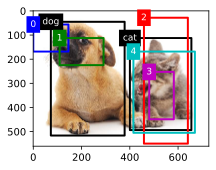

In [61]:
ground_truth = nd.array([[0, 0.1, 0.08, 0.52, 0.92],
                         [1, 0.55, 0.2, 0.9, 0.88]])
anchors = nd.array([[0, 0.1, 0.2, 0.3], [0.15, 0.2, 0.4, 0.4],
                    [0.63, 0.05, 0.88, 0.98], [0.66, 0.45, 0.8, 0.8],
                    [0.57, 0.3, 0.92, 0.9]])

fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, ground_truth[:, 1:] * bbox_scale, ['dog', 'cat'], 'k')
show_bboxes(fig.axes, anchors * bbox_scale, ['0', '1', '2', '3', '4']);

In [63]:
labels = contrib.nd.MultiBoxTarget(anchors.expand_dims(axis=0),
                                   ground_truth.expand_dims(axis=0),
                                   nd.zeros((1, 3, 5)))
labels

[
 [[ 0.00e+00  0.00e+00  0.00e+00  0.00e+00  1.40e+00  1.00e+01  2.59e+00
    7.18e+00 -1.20e+00  2.69e-01  1.68e+00 -1.57e+00  0.00e+00  0.00e+00
    0.00e+00  0.00e+00 -5.71e-01 -1.00e+00 -8.94e-07  6.26e-01]]
 <NDArray 1x20 @cpu(0)>,
 
 [[0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 1. 1.]]
 <NDArray 1x20 @cpu(0)>,
 
 [[0. 1. 2. 0. 2.]]
 <NDArray 1x5 @cpu(0)>]

## 1.3.输出预测框

在模型预测阶段，我们先为图像生成多个锚框，并为这些锚框一一预测类别和偏移量。随后，我们根据锚框及其预测偏移量得到预测边界框。当锚框数量较多时，同一个目标上可能会输出较多相似的预测边界框。为了使结果更加简洁，我们可以移除相似的预测边界框。常用的方法叫作非极大值抑制(non-maximum suppression，NMS)。

我们来描述一下非极大值抑制的工作原理。对于一个预测边界框$B$，模型会计算各个类别的预测概率。设其中最大的预测概率为$p$，该概率所对应的类别即$B$的预测类别。我们也将$p$称为预测边界框$B$的置信度。在同一图像上，我们将预测类别非背景的预测边界框按置信度从高到低排序，得到列表$L$。从$L$中选取置信度最高的预测边界框$B_1$作为基准，将所有与$B_1$的交并比大于某阈值的非基准预测边界框从$L$中移除。这里的阈值是预先设定的超参数。此时，$L$保留了置信度最高的预测边界框并移除了与其相似的其他预测边界框。 接下来，从$L$中选取置信度第二高的预测边界框$B_2$作为基准，将所有与$B_2$的交并比大于某阈值的非基准预测边界框从$L$中移除。重复这一过程，直到$L$中所有的预测边界框都曾作为基准。此时$L$中任意一对预测边界框的交并比都小于阈值。最终，输出列表$L$中的所有预测边界框。

下面来看一个具体的例子。先构造4个锚框。简单起见，我们假设预测偏移量全是0：预测边界框即锚框。最后，我们构造每个类别的预测概率。

In [64]:
anchors = nd.array([[0.1, 0.08, 0.52, 0.92], [0.08, 0.2, 0.56, 0.95],
                    [0.15, 0.3, 0.62, 0.91], [0.55, 0.2, 0.9, 0.88]])
offset_preds = nd.array([0] * anchors.size)
cls_probs = nd.array([[0] * 4,  # 背景的预测概率
                      [0.9, 0.8, 0.7, 0.1],  # 狗的预测概率
                      [0.1, 0.2, 0.3, 0.9]])  # 猫的预测概率

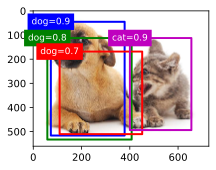

In [66]:
fig = d2l.plt.imshow(img)
show_bboxes(fig.axes, anchors * bbox_scale,
            ['dog=0.9', 'dog=0.8', 'dog=0.7', 'cat=0.9'])

我们使用contrib.nd模块的MultiBoxDetection函数来执行非极大值抑制并设阈值为0.5。这里为NDArray输入都增加了样本维。我们看到，返回的结果的形状为(批量大小, 锚框个数, 6)。其中每一行的6个元素代表同一个预测边界框的输出信息。第一个元素是索引从0开始计数的预测类别（0为狗，1为猫），其中-1表示背景或在非极大值抑制中被移除。第二个元素是预测边界框的置信度。剩余的4个元素分别是预测边界框左上角的$x$和$y$轴坐标以及右下角的$x$和$y$轴坐标（值域在0到1之间）。

In [67]:
output = contrib.ndarray.MultiBoxDetection(
    cls_probs.expand_dims(axis=0), offset_preds.expand_dims(axis=0),
    anchors.expand_dims(axis=0), nms_threshold=0.5)
output


[[[ 0.    0.9   0.1   0.08  0.52  0.92]
  [ 1.    0.9   0.55  0.2   0.9   0.88]
  [-1.    0.8   0.08  0.2   0.56  0.95]
  [-1.    0.7   0.15  0.3   0.62  0.91]]]
<NDArray 1x4x6 @cpu(0)>

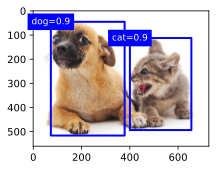

In [68]:
fig = d2l.plt.imshow(img)
for i in output[0].asnumpy():
    if i[0] == -1:
        continue
    label = ('dog=', 'cat=')[int(i[0])] + str(i[1])
    show_bboxes(fig.axes, [nd.array(i[2:]) * bbox_scale], label)

实践中，我们可以在执行非极大值抑制前将置信度较低的预测边界框移除，从而减小非极大值抑制的计算量。我们还可以筛选非极大值抑制的输出，例如，只保留其中置信度较高的结果作为最终输出。

# 2.多尺度目标检测

In [1]:
import matplotlib
%matplotlib inline
import d2lzh as d2l
from mxnet import contrib, image, nd

img = image.imread('data/catdog.jpg')
h, w = img.shape[0:2]
h, w

(561, 728)

In [4]:
d2l.set_figsize()

def display_anchors(fmap_w, fmap_h, s):
    fmap = nd.zeros((1, 10, fmap_w, fmap_h))  # 前两维的取值不影响输出结果
    anchors = contrib.nd.MultiBoxPrior(fmap, sizes=s, ratios=[1, 2, 0.5])
    print(anchors)
    bbox_scale = nd.array((w, h, w, h))
    d2l.show_bboxes(d2l.plt.imshow(img.asnumpy()).axes,
                    anchors[0] * bbox_scale)

我们先关注小目标的检测。为了在显示时更容易分辨，这里令不同中心的锚框不重合：设锚框大小为0.15，特征图的高和宽分别为4。可以看出，图像上4行4列的锚框中心分布均匀


[[[0.05       0.05       0.2        0.2       ]
  [0.01893398 0.07196699 0.23106602 0.17803301]
  [0.07196699 0.01893397 0.17803301 0.23106602]
  [0.3        0.05       0.45       0.2       ]
  [0.26893398 0.07196699 0.48106602 0.17803301]
  [0.321967   0.01893397 0.428033   0.23106602]
  [0.55       0.05       0.7        0.2       ]
  [0.518934   0.07196699 0.731066   0.17803301]
  [0.571967   0.01893397 0.678033   0.23106602]
  [0.8        0.05       0.95       0.2       ]
  [0.768934   0.07196699 0.981066   0.17803301]
  [0.821967   0.01893397 0.928033   0.23106602]
  [0.05       0.3        0.2        0.45      ]
  [0.01893398 0.32196698 0.23106602 0.42803302]
  [0.07196699 0.26893398 0.17803301 0.48106602]
  [0.3        0.3        0.45       0.45      ]
  [0.26893398 0.32196698 0.48106602 0.42803302]
  [0.321967   0.26893398 0.428033   0.48106602]
  [0.55       0.3        0.7        0.45      ]
  [0.518934   0.32196698 0.731066   0.42803302]
  [0.571967   0.26893398 0.678033   0.4

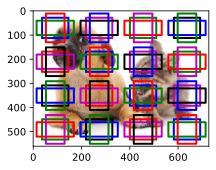

In [5]:
display_anchors(fmap_w=4, fmap_h=4, s=[0.15])

我们将特征图的高和宽分别减半，并用更大的锚框检测更大的目标。当锚框大小设0.4时，有些锚框的区域有重合。


[[[0.15       0.15       0.35       0.35      ]
  [0.10857864 0.17928931 0.39142138 0.3207107 ]
  [0.17928931 0.10857864 0.3207107  0.39142138]
  [0.65       0.15       0.85       0.35      ]
  [0.6085786  0.17928931 0.8914214  0.3207107 ]
  [0.67928934 0.10857864 0.82071066 0.39142138]
  [0.15       0.65       0.35       0.85      ]
  [0.10857864 0.67928934 0.39142138 0.82071066]
  [0.17928931 0.6085786  0.3207107  0.8914214 ]
  [0.65       0.65       0.85       0.85      ]
  [0.6085786  0.67928934 0.8914214  0.82071066]
  [0.67928934 0.6085786  0.82071066 0.8914214 ]]]
<NDArray 1x12x4 @cpu(0)>


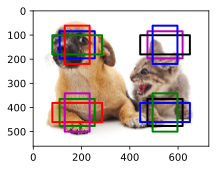

In [7]:
display_anchors(fmap_w=2, fmap_h=2, s=[0.2])

## 2.1.具体算法

我们知道$r=[1,2,0.5]$,$s=0.2$,并且特征图大小是$2 \times 2$。归一化之后，每个像素的大小是$0.25 \times 0.25$，拿第一个像素来说，它的中心点的位置在$(0.25,0.25)$，$s=0.2$说明锚框的边长为0.2，那么第一个锚框的坐标就是$[0.25-\frac{0.2}{2}=0.15, 0.25-\frac{0.2}{2}=0.15, 0.25+\frac{0.2}{2}=0.35, 0.25+\frac{0.2}{2}=0.35]$,这是一个正方形，即边长比率为$r=1$的意思。那么对于第二个$r=2$来说，长宽比率为2，则矩形的长为$0.2 \times \sqrt{2}=0.28$，宽为$\frac{0.2}{\sqrt{2}}=0.14$，那么第二个锚框的坐标就是$[0.25-\frac{0.28}{2}=0.11,0.25-\frac{0.14}{2}=0.18,0.11+0.28=0.39,0.18+0.14=0.32]$，那么第三个锚框的坐标就是$[0.18,0.11,0.32,0.39]$

## 2.2.多尺度目标检测

既然我们已在多个尺度上生成了不同大小的锚框，相应地，我们需要在不同尺度下检测不同大小的目标。在某个尺度下，假设我们依据$c_i$张形状为$h \times w$的特征图生成$h \times w$组不同中心的锚框，且每组的锚框个数为$a$。例如，在刚才实验的第一个尺度下，我们依据10（通道数）张形状为$4 \times 4$的特征图生成了16组不同中心的锚框，且每组含3个锚框。 接下来，依据真实边界框的类别和位置，每个锚框将被标注类别和偏移量。在当前的尺度下，目标检测模型需要根据输入图像预测$h \times w$组不同中心的锚框的类别和偏移量。

假设这里的$c_i$张特征图为卷积神经网络根据输入图像做前向计算所得的中间输出。既然每张特征图上都有$h \times w$个不同的空间位置，那么相同空间位置可以看作含有$c_i$个单元。 根据“二维卷积层”一节中感受野的定义，特征图在相同空间位置的$c_i$个单元在输入图像上的感受野相同，并表征了同一感受野内的输入图像信息。 因此，我们可以将特征图在相同空间位置的$c_i$个单元变换为以该位置为中心生成的$a$个锚框的类别和偏移量。不难发现，本质上，我们用输入图像在某个感受野区域内的信息来预测输入图像上与该区域位置相近的锚框的类别和偏移量。

当不同层的特征图在输入图像上分别拥有不同大小的感受野时，它们将分别用来检测不同大小的目标。例如，我们可以通过设计网络，令较接近输出层的特征图中每个单元拥有更广阔的感受野，从而检测输入图像中更大尺寸的目标。具体的可以参考[SSD的介绍](02.一阶段.02.SSD.ipynb)